In [9]:
import numpy as np
import pandas as pd
from shutil import copyfile
# from astropy.cosmology import Planck13 as cosmo
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
from astropy.cosmology import z_at_value
import fsps
from matplotlib import gridspec
import matplotlib as mpl
from astropy.io import fits
from astropy import wcs
from astropy.table import Table
import astropy.units as u
from sim_engine import Scale_model
from spec_tools import Source_present, Oldest_galaxy, Sig_int, Smooth, Rescale_sfh, \
    lbt_to_z, boot_to_posterior, age_to_z, Posterior_spec
from spec_stats import Smooth, Highest_density_region, Linear_fit
from spec_id import *
from spec_id_2d import Gen_temp_dict_addline
from spec_stats import Highest_density_region, Linear_fit
from spec_exam import Gen_spec
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d, interp2d
from glob import glob
import seaborn as sea
import os
from grizli import multifit
from grizli import model
from grizli.utils import SpectrumTemplate
from sim_engine import forward_model_grism

from bokeh.models import HoverTool, ColumnDataSource, OpenURL, TapTool, DataTable, TableColumn, \
    Label, BoxAnnotation, Band
from bokeh import palettes
from bokeh.plotting import figure,save
from bokeh.io import show, output_notebook, output_file
from bokeh.transform import linear_cmap
from bokeh.layouts import gridplot

import pickle
from spec_tools import Gen_SFH

from time import time
sea.set(style='white')
sea.set(style='ticks')
sea.set_style({'xtick.direct'
               'ion': 'in','xtick.top':True,'xtick.minor.visible': True,
               'ytick.direction': "in",'ytick.right': True,'ytick.minor.visible': True})
cmap = sea.cubehelix_palette(12, start=2, rot=.2, dark=0, light=1.0, as_cmap=True)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

### set home for files
hpath = os.environ['HOME'] + '/'

if hpath == '/Users/Vince.ec/':
    dpath = '/Volumes/Vince_research/Data/' 
    
else:
    dpath = hpath + 'Data/' 

In [4]:
alldb = pd.read_pickle('../dataframes/fitdb/allfits_1D.pkl')
sfdb = pd.read_pickle('../dataframes/fitdb/SFfits_1D.pkl')

inout = []
for i in alldb.index:
    IO = 'i'
    if alldb.field[i] == 'GND' and alldb.id[i] in sfdb.query('field == "GND"').id.values:
        IO = 'o' 
    if alldb.field[i] == 'GSD' and alldb.id[i] in sfdb.query('field == "GSD"').id.values:
        IO = 'o' 
    inout.append(IO)
    
alldb['inout'] = inout

Qdb = alldb.query('inout == "i" and t_50 > 0')

adb = pd.concat([Qdb, sfdb])
adb = adb.reset_index()
adb = adb.drop(columns='index')
Adb = adb.query('AGN != "AGN" and lmass > 10 and 0.7 < zgrism < 2.7')

from scipy.optimize import curve_fit

def gauss(x,mu,sigma,A):
    return A*np.exp(-(x-mu)**2/2/sigma**2)

def bimodal(x,mu1,sigma1,A1,mu2,sigma2,A2):
    return gauss(x,mu1,sigma1,A1)+gauss(x,mu2,sigma2,A2)

y,x=np.histogram(Adb.log_ssfr.values,100)

x=(x[1:]+x[:-1])/2 # for len(x)==len(y)

expected=(-12, 0.45, 12,-9.56, 0.649,25)
params,cov=curve_fit(bimodal,x,y,expected)
sigma=np.sqrt(np.diag(cov))
print(params)
X = np.linspace(-14, -7, 10000)
Qdist = gauss(X, -11.50173391, 0.68224873, 7.21979314)
SFdist = gauss(X, -9.46921134, 0.49696219, 20.36197415)

Qint = []
Sint = []
for i in range(len(X)):
    Qint.append(np.trapz(Qdist[i:i+2],X[i:i+2]))
    Sint.append(np.trapz(SFdist[i:i+2],X[i:i+2]))    

Fint = np.add(Qint, Sint)

SFprob = interp1d(X,Sint / Fint)

t_q = []
lSig = []
lRe = []
lZ = []
z50 = []
concen = []
SFR = []
sfprob = []
for i in adb.index:
    if adb.zgrism[i] < 0:
        adb.zgrism[i] = adb.zfit[i]

    if adb.sSFR_avg[i] > 0:
        adb.log_ssfr[i] = adb.sSFR_avg[i]
     
    t_q.append(adb.t_50[i] - adb.t_90[i])
    lSig.append(np.log10(adb.Sigma1[i]))
    lRe.append(np.log10(adb.Re[i]))
    lZ.append(np.log10(adb.Z[i]))
    z50.append(cosmo.lookback_time(adb.z_50[i]).value)
    concen.append(np.log10(adb.Sigma1[i] / (10**adb.lmass[i])))
    SFR.append(np.log10(10**adb.log_ssfr[i] * 10**adb.lmass[i]))
    sfprob.append(float(SFprob(adb.log_ssfr[i])))
    
adb['t_q'] = t_q
adb['log_Sigma1'] = lSig
adb['log_Re'] = lRe
adb['log_Z'] = lZ
adb['z50'] = z50
adb['concen'] = concen
adb['log_sfr'] = SFR
adb['sf_prob'] = sfprob
  
Adb = adb.query('AGN != "AGN" and lmass > 10')
Axdb = adb.query('AGN == "AGN" and lmass > 10')

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:17: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



[-11.50173391   0.68224873   7.21979314  -9.46921134   0.49696219
  20.36197415]


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in true_divide
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [3]:
from scipy.ndimage import gaussian_filter as norm_kde

zgrism = Adb.sort_values('zgrism').zgrism.values
log_ssfr = Adb.sort_values('zgrism').log_ssfr.values
idx=0

Qs = []
Sf = []
Sp = []
zs = []

size = 0.5
step = 0.01
start = 0.7 - size/2
stop = 2.7 + size/2

DB = Adb

while (start + step*idx + size) < stop:
    zs.append(start + step*idx + size/2)
    
    llim = start + step*idx
    hlim = llim + size
    
    samp = DB.query('{} <zgrism < {}'.format(llim,hlim)).log_ssfr.values
    subsamp =  DB.query('{} <zgrism < {} and log_ssfr > -11.5'.format(llim,hlim)).log_ssfr.values
    kde =stats.gaussian_kde(subsamp)
    y = kde(X)
    x = X
    
    
    mug1 = max1 = mug2 = max2 = 0
    for ii in range(len(x)):
        if x[ii] < -10.3:
            if y[ii] > max1:
                mug1 = x[ii]
                max1 = y[ii]  

        if x[ii] > -10.3:
            if y[ii] > max2:
                mug2 = x[ii]
                max2 = y[ii] 
    expected =[mug2,.1, max2],

    params,cov=curve_fit(gauss,x,y,expected)
    
    sigma=np.sqrt(np.diag(cov))
    mu2, sig2, A2 = params
    
    X = np.linspace(-14, -7, 1000)
    SFdist = gauss(X, mu2, sig2, A2)
    Sf.append(SFdist)

    kde =stats.gaussian_kde(samp)

    kde_n = (kde(X)/max(kde(X)) * max(SFdist))
    Sint = []
    Fint = []
    
    for ii in range(len(X)):
        Sint.append(np.trapz(SFdist[ii:ii+2],X[ii:ii+2]))    
        Fint.append(np.trapz(kde_n[ii:ii+2],X[ii:ii+2]))    


    SFprob = interp1d(X,np.array(Sint) / np.array(Fint))
    
    Sp_n = []
    val = 0
    switch = False
    sp = np.zeros_like(SFprob(X))
    for ii in range(len(SFprob(X))):
        if val >0.9999:
            switch = True
        else:
            val = SFprob(X)[ii]  
        sp[ii] = SFprob(X)[ii]   
        if switch:
            sp[ii] = 1   
    sp[sp > 1]=1
    Sp.append(sp)
    idx += 1
    

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:65: RuntimeWarning: invalid value encountered in true_divide


In [4]:
iSprob = interp2d(X,zs,Sp)

Z = np.linspace(0.7,2.7,500)
M = []
L = []
H = []
for i in range(len(Z)):
    mt = lt = ht = False
    for x in X:
        if not mt and 0.49 < iSprob(x,Z[i]) < 0.51:
            M.append(x)
            mt = True
        if not lt and 0.19 < iSprob(x,Z[i]) < 0.21:
            L.append(x)
            lt = True
        if not ht and 0.79 < iSprob(x,Z[i]) < 0.81:
            H.append(x)
            ht = True
            
sfp = []
for i in Adb.index:
    sfp.append(iSprob(Adb.log_ssfr[i],Adb.zgrism[i])[0])
    
Adb['sf_prob_2'] = sfp

sfp = []
for i in adb.index:
    sfp.append(iSprob(adb.log_ssfr[i],adb.zgrism[i])[0])
    
adb['sf_prob_2'] = sfp

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [5]:
def sym_err(DB, param):
    s_err = []

    for i in DB.index:
        hdr = DB['{}_hdr'.format(param)][i]
        s_err.append((hdr[1] - hdr[0])/2)    
        
    return np.array(s_err)
Cdb = Adb.query('log_Sigma1 > 10.25 and sf_prob_2 < 0.2').sort_values('zgrism')
# Cadb = Adb.query('log_Sigma1 > 10.25 and sf_prob_2 < 0.2').sort_values('zgrism')
Edb = Adb.query(' log_Sigma1 < 10.25 and sf_prob_2 < 0.2').sort_values('zgrism')
# Eadb = Adb.query(' log_Sigma1 < 10.25 and sf_prob_2 < 0.2').sort_values('zgrism')

In [32]:
from scipy.optimize import minimize
import dynesty
Cdb = Adb.query('log_Sigma1 > 10.25 and sf_prob_2 < 0.2').sort_values('zgrism') 
rshifts = Cdb.zgrism.values
t50s = Cdb.t_50.values
serr = sym_err(Cdb, 't_50')
    
def ln_likelihood(pars):
    """ The likelihood function evaluation requires a particular set of model parameters and the data """
    H, toff, Va, lnVb = pars
    
    cosmo = FlatLambdaCDM(H0=H, Om0=0.3)
    V = -Va * rshifts + np.exp(lnVb)
    V[V<0] = 0

    N = len(t50s)
    dy = t50s - (cosmo.age(rshifts).value - toff)
    ivar = 1 / (serr**2 + V) # inverse-variance now includes intrinsic scatter
    
    return -0.5 * (N*np.log(2*np.pi) - np.sum(np.log(ivar)) + np.sum(dy**2 * ivar))

def prior(u):
    H = Gaussian_prior(u[0], [50, 90], 70, 5)
    toff = 3*u[1]
    Va = Gaussian_prior(u[2], [-0.5, 0.5], 0, 0.25)
    lnVb = Gaussian_prior(u[3], [0, -3], -1.5, 0.5)
    
    return H, toff, Va, lnVb

In [677]:
sampler = dynesty.DynamicNestedSampler(ln_likelihood, prior, ndim = 4, bound = 'multi')

In [678]:
sampler.run_nested(wt_kwargs={'pfrac': 1.0}, dlogz_init=0.01,nlive_init=4000, print_progress=True)


44637it [29:31, 25.20it/s, batch: 0 | bound: 15 | nc: 1 | ncall: 231471 | eff(%): 19.284 | loglstar:   -inf < -15.760 <    inf | logz: -21.310 +/-  0.040 | dlogz:  0.000 >  0.010] 


In [679]:
from dynesty import plotting as dyplot
dres = sampler.results

labels = [r'$H_0$', r'$t_{off}$', r'$V_a$', r'$\ln(V_b)$']

dyplot.cornerplot(dres,show_titles=True, max_n_ticks=3, title_kwargs={'y': 1.02,'fontsize':16},
                           quantiles=[], labels = labels, label_kwargs = {'fontsize':18})

plt.savefig('../plots/research_update/corner.png', bbox_inches = 'tight')   

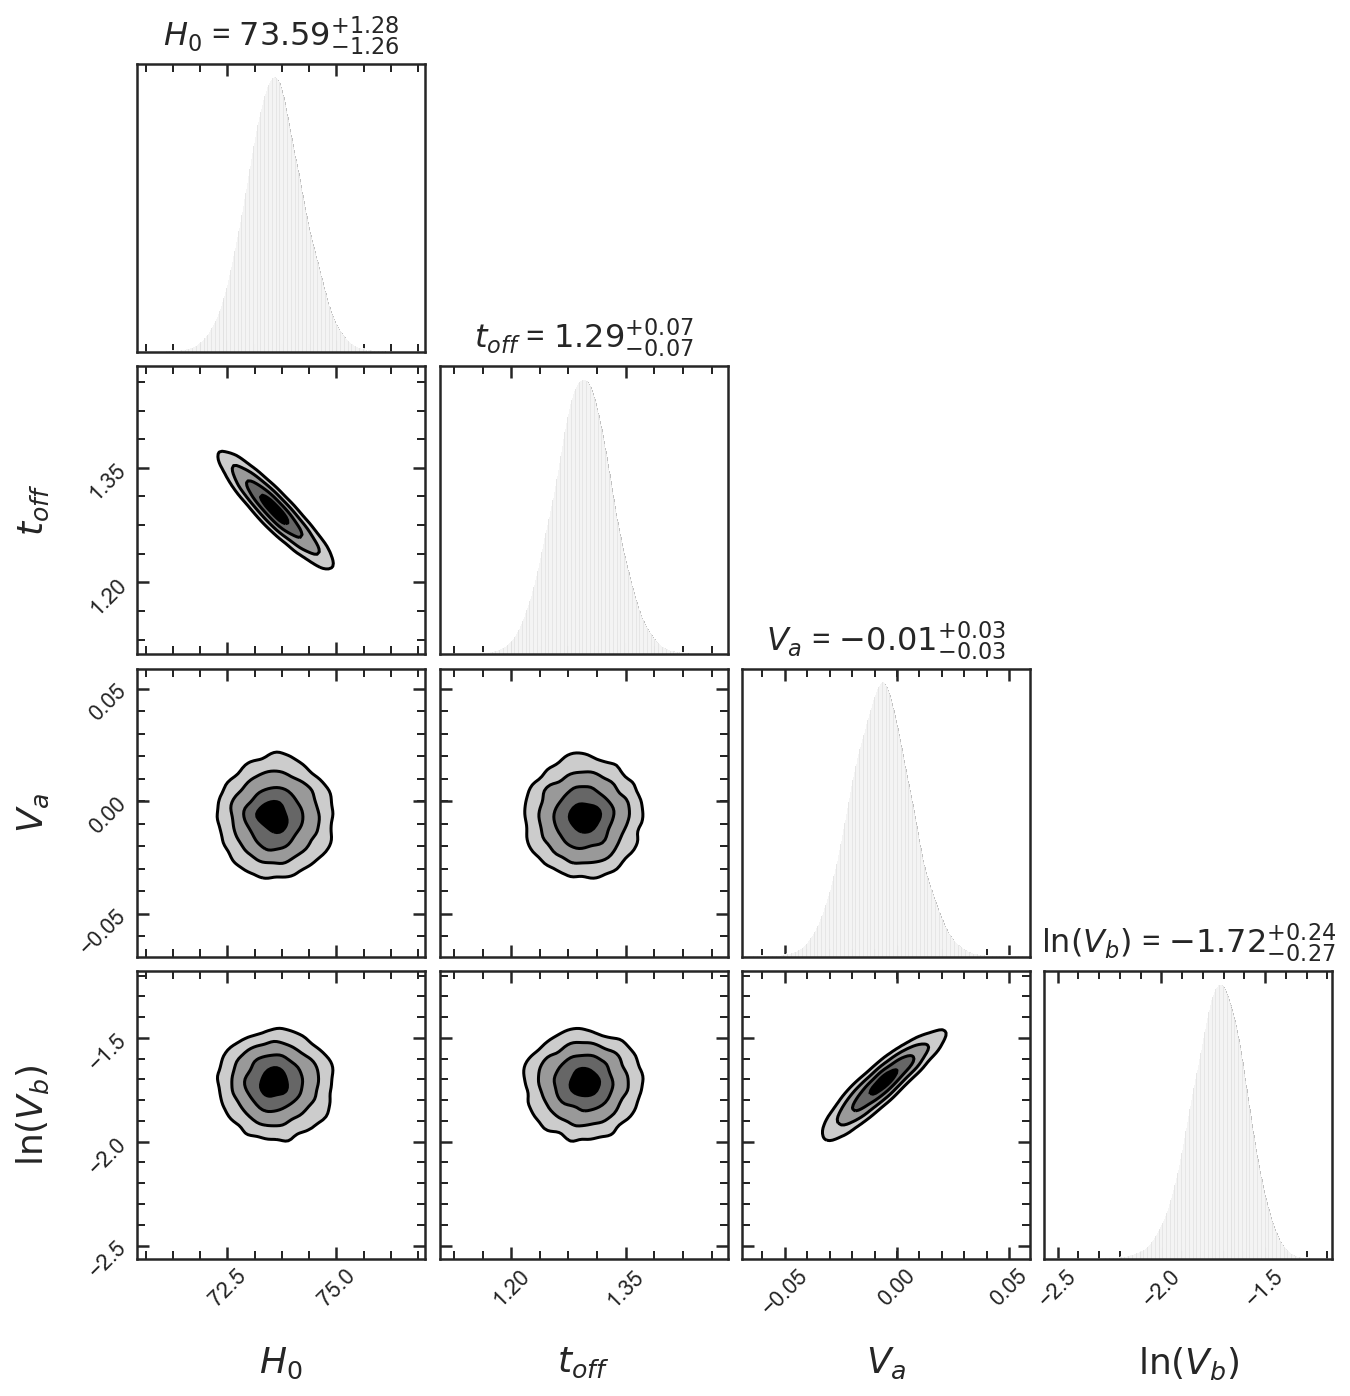

In [163]:
from dynesty import plotting as dyplot
dres = np.load('../chidat/sim_H0_n1750.npy', allow_pickle = True).item()

labels = [r'$H_0$', r'$t_{off}$', r'$V_a$', r'$\ln(V_b)$']

dyplot.cornerplot(dres,show_titles=True, max_n_ticks=3, title_kwargs={'y': 1.02,'fontsize':16},
                           quantiles=[], labels = labels, label_kwargs = {'fontsize':18})

plt.savefig('../plots/research_update/sim_H0_n1750.png', bbox_inches = 'tight') 

In [ ]:
x0 = [75, 1, 0.] # starting guess for the optimizer 

# we have to minimize the negative log-likelihood to maximize the likelihood
result_ml_scatter = minimize(lambda *args: ln_likelihood(*args), 
                             x0=x0, method='BFGS')
result_ml_scatter

In [275]:
result_ml_scatter.x[0],result_ml_scatter.x[1],np.sqrt(np.exp(result_ml_scatter.x[2]))

(71.95348249026041, 1.2061460920191136, 0.3771469318086549)

In [48]:
# 10.0, 11.0, 3.0, 0.0, 4.0------2
# 10.0, 11.0, 3.0, 0.7, 4.0------5
# 10.25, 11.0, 1.0, 0.0, 4.0------3
# 10.25, 11.0, 1.0, 0.7, 4.0------6
# 10.25, 11.0, 3.0, 0.0, 4.0------
# 9.0, 11.0, 3.0, 0.0, 4.0------1
# 9.0, 11.0, 3.0, 0.7, 4.0------4

lsig = [10.0,10.0,10.25,10.25,10.25,9.0,9.0] 
hsig = [11,11,11,11,11,11,11]
z50 = [3,3,1,1,3,3,3]
zlow = [0.0,0.7,0.0,0.7,0.0,0.0,0.7]
zhi = [4,4,4,4,4,4,4]

In [49]:
Hdb = pd.read_pickle('../dataframes/fitdb/hubble_db.pkl') 
for i in range(len(lsig)):
    Cdb = Hdb.query(' {} < log_Sigma1 < {} and sf_prob_2 < 0.2 and z_50 > {} and {} < zgrism < {}'.format(
    lsig[i], hsig[i], z50[i], zlow[i], zhi[i])).sort_values('zgrism') 
    print(len(Cdb))

49
47
20
18
16
114
109


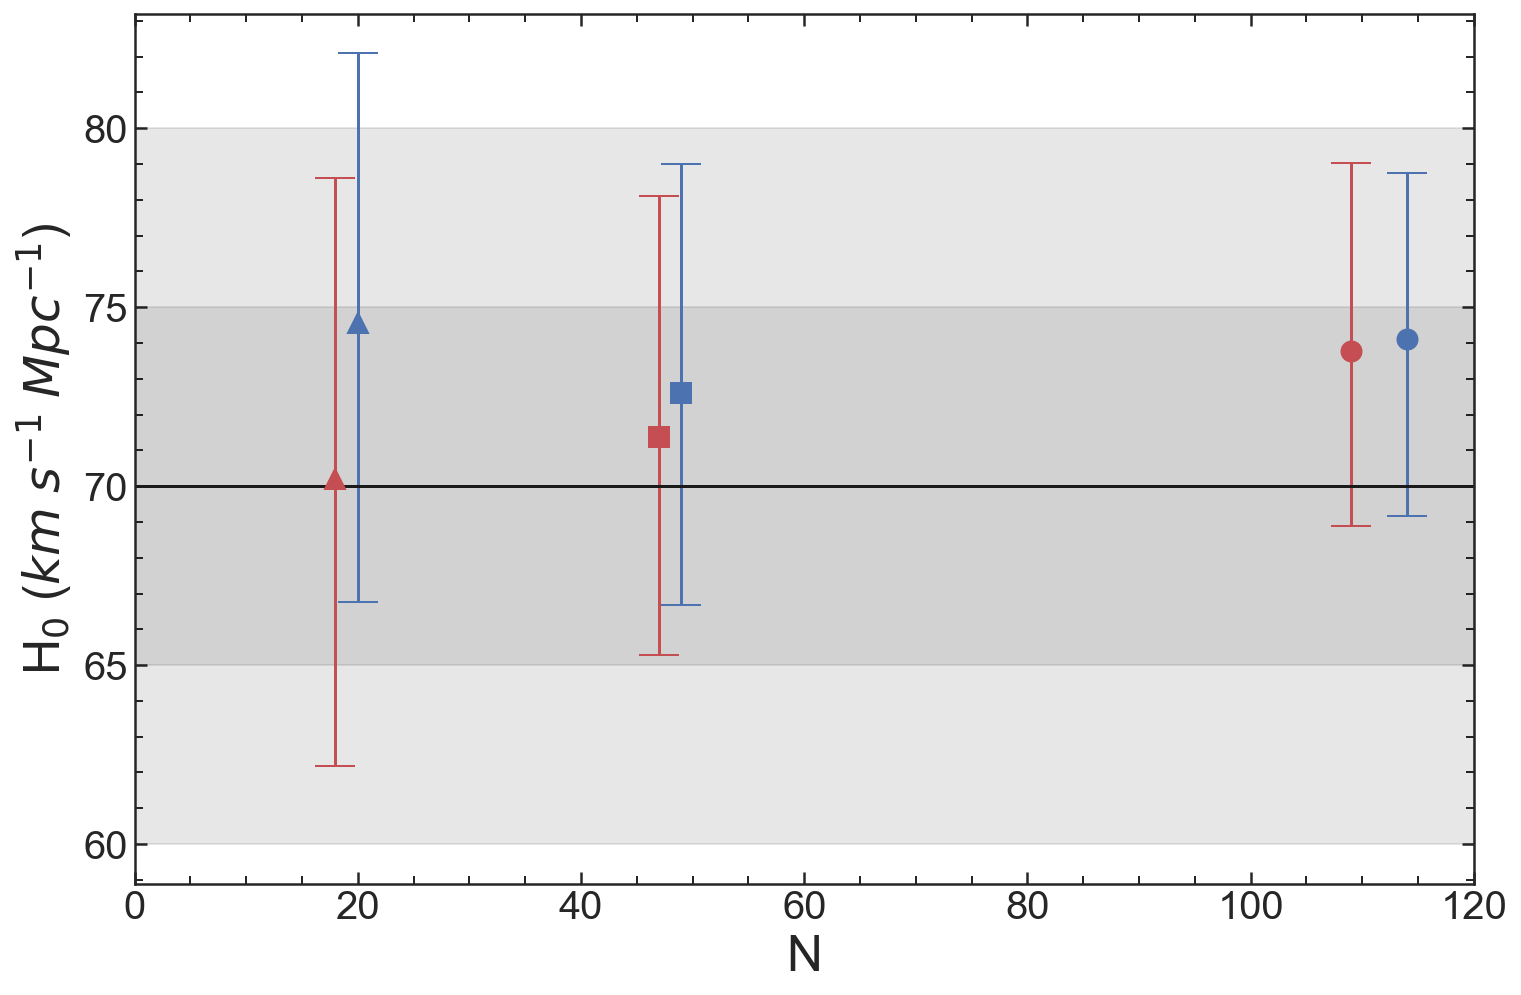

In [69]:
plt.figure(figsize = [12,8])

plt.errorbar([114],[74.10], yerr =np.array([[4.93],[4.65]]), fmt = 'o', capsize =10, ms = 10, color = 'b')
plt.errorbar([49], [72.6], yerr =np.array([[5.91],[6.41]]), fmt = 's', capsize =10, ms = 10, color = 'b')
plt.errorbar([20],[74.57], yerr =np.array([[7.82],[7.52]]), fmt = '^', capsize =10, ms = 10, color = 'b')

plt.errorbar([109],[73.77], yerr =np.array([[4.89],[5.25]]), fmt = 'o', capsize =10, ms = 10, color = 'r')
plt.errorbar([47], [71.37], yerr =np.array([[6.09],[6.74]]), fmt = 's', capsize =10, ms = 10, color = 'r')
plt.errorbar([18],[70.20], yerr =np.array([[8.01],[8.41]]), fmt = '^', capsize =10, ms = 10, color = 'r')

plt.axhline(70, color = 'k')
plt.fill_between([0, 120],[65,65], [75,75],  alpha = 0.1, color = 'k')
plt.fill_between([0, 120],[60,60], [80,80],  alpha = 0.1, color = 'k')

plt.xlim(0,120)
plt.xlabel('N', fontsize=25)
plt.ylabel('H$_0$ ($km$ $s^{-1}$ $Mpc^{-1}$)', fontsize=25)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.savefig('../plots/research_update/H0_measurements.png', bbox_inches = 'tight')    

In [ ]:
plt.errorbar([74.10],[114],[6], xerr =np.array([[4.93],[4.65]]), fmt = 'o', capsize =10)
plt.errorbar([72.6],[49],[5], xerr =np.array([[5.91],[6.41]]), fmt = 'o', capsize =10)
plt.errorbar([74.57],[20],[4], xerr =np.array([[7.82],[7.52]]), fmt = 'o', capsize =10)

plt.errorbar([73.77],[109],[3], xerr =np.array([[4.89],[5.25]]), fmt = 'o', capsize =10)
plt.errorbar([71.37],[47], [2], xerr =np.array([[6.09],[6.74]]), fmt = 'o', capsize =10)
plt.errorbar([70.20],[18],[1], xerr =np.array([[8.01],[8.41]]), fmt = 'o', capsize =10)

plt.axvline(70, color = 'k')
plt.fill_between([65,75], [7, 7], alpha = 0.3, color = 'k')

In [242]:
def log_likelihood(A, toff, V, t50, t50sig):
    t1 = np.sum(np.log(t50sig**2 + V))
    t2 = np.sum((t50 - A)**2 / (t50sig**2 + V))
    return -0.5*(len(t50)*np.log(2*np.pi) + t1 + t2)

0.24171401689703645


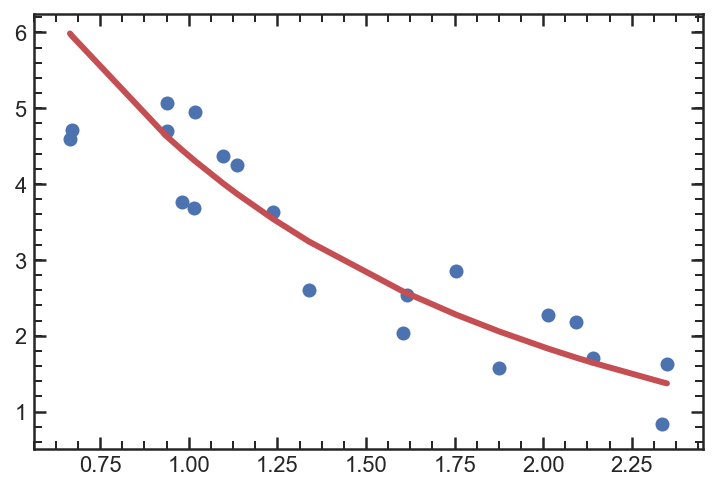

In [682]:
# print(dres.samples[-1])
print(np.exp(-1.42))
cosmo = FlatLambdaCDM(H0=70.09, Om0=0.3)
plt.plot(rshifts, cosmo.age(rshifts).value - 1.37, color = 'r', linewidth = 3)
plt.scatter(rshifts, t50s)

In [640]:
cosmo = FlatLambdaCDM(H0=67.4, Om0=0.3)
P_curve = cosmo.age(rshifts).value

def ln_likelihood_planck(pars):
    """ The likelihood function evaluation requires a particular set of model parameters and the data """
    toff, Va, lnVb = pars

    V = -Va * rshifts + np.exp(lnVb)
    V[V<0] = 0
    N = len(t50s)
        
    dy = t50s - (P_curve - toff)
    ivar = 1 / (serr**2 + V) # inverse-variance now includes intrinsic scatter
    return -0.5 * (N*np.log(2*np.pi) - np.sum(np.log(ivar)) + np.sum(dy**2 * ivar))

def prior_planck(u):
    toff = 3*u[0]
    Va = Gaussian_prior(u[1], [-0.5, 0.5], 0, 0.25)
    lnVb = Gaussian_prior(u[2], [0, -3], -1.5, 0.5)
    
    return toff, Va, lnVb

In [641]:
psampler = dynesty.DynamicNestedSampler(ln_likelihood_planck, prior_planck, ndim = 3, bound = 'multi')

In [642]:
psampler.run_nested(wt_kwargs={'pfrac': 1.0}, dlogz_init=0.01,nlive_init=4000, print_progress=True)


23390it [06:53, 24.59it/s, batch: 11 | bound: 51 | nc: 13 | ncall: 195695 | eff(%): 11.952 | loglstar: -24.510 < -17.806 < -18.475 | logz: -22.633 +/-  0.107 | stop:  0.924] 


In [471]:
pres = psampler.results

(<Figure size 547.2x547.2 with 9 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1ab897d908>,
       dtype=object))

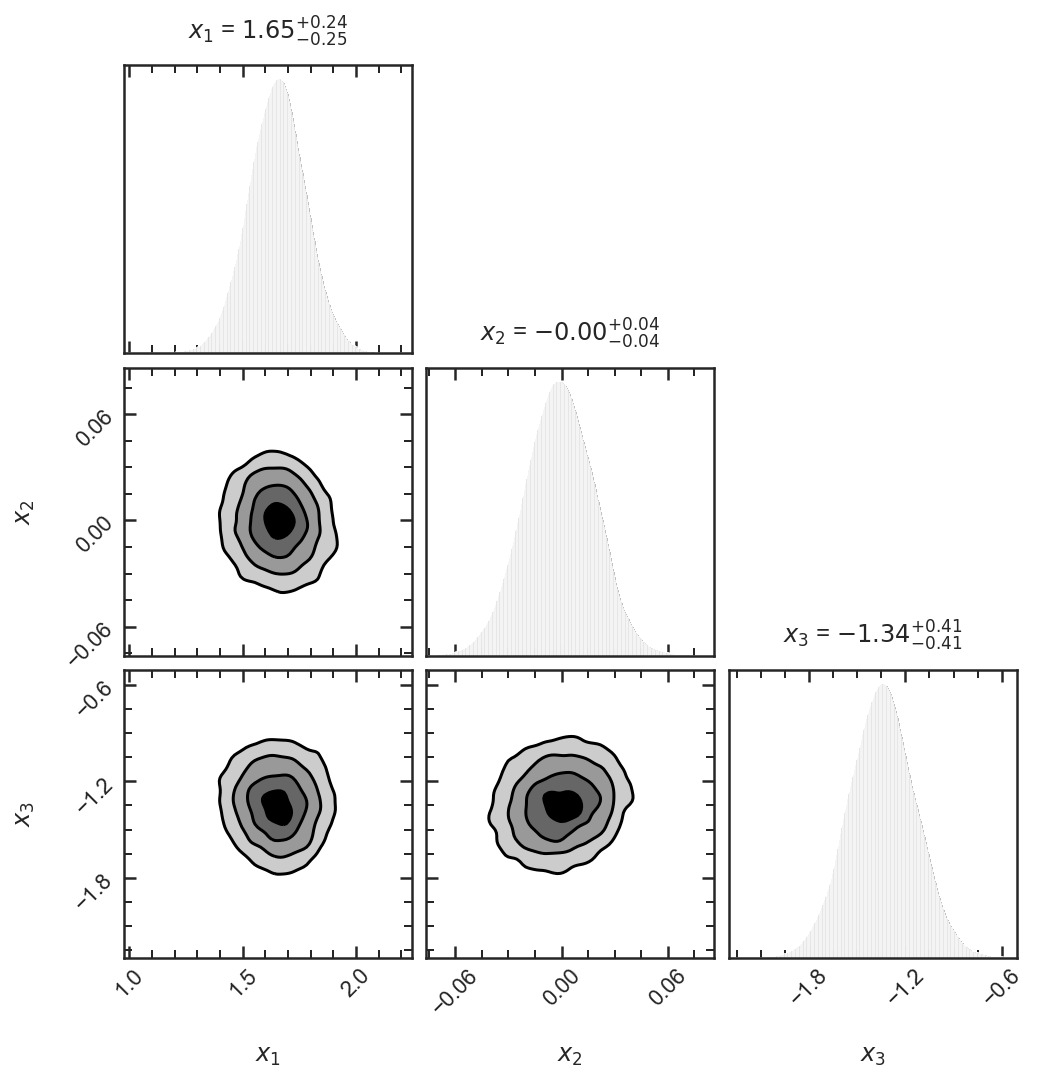

In [472]:
dyplot.cornerplot(pres,show_titles=True, max_n_ticks=3, title_kwargs={'y': 1.05},
                           quantiles=None)

0.5299354883175685


<ErrorbarContainer object of 3 artists>

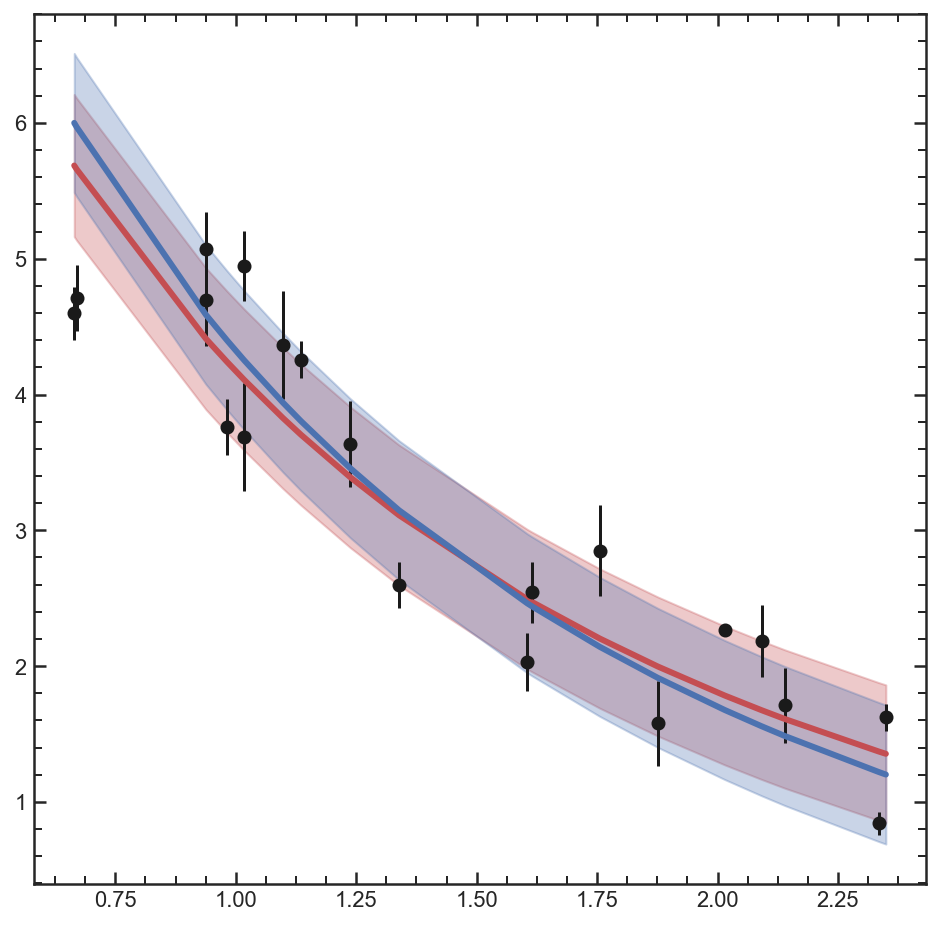

In [747]:
plt.figure(figsize=[8,8])

print(np.sqrt(np.exp(-1.27)))
cosmo = FlatLambdaCDM(H0=74.66, Om0=0.3)
H_age = cosmo.age(rshifts).value
sig = np.sqrt(-0.01*rshifts + np.exp(-1.27))
plt.plot(rshifts, cosmo.age(rshifts).value - 1.22, color = 'r', linewidth = 3)
plt.fill_between(rshifts, H_age - 1.22 - sig, H_age - 1.22 + sig, color = 'r', alpha = 0.3)

cosmo = FlatLambdaCDM(H0=67.4, Om0=0.3)
H_age = cosmo.age(rshifts).value
plt.plot(rshifts, cosmo.age(rshifts).value - 1.65, color = 'b', linewidth = 3)
plt.fill_between(rshifts, H_age - 1.65 - 0.512, H_age - 1.65 + 0.512, color = 'b', alpha = 0.3)

plt.errorbar(rshifts, t50s, serr, color = 'k', fmt='o')

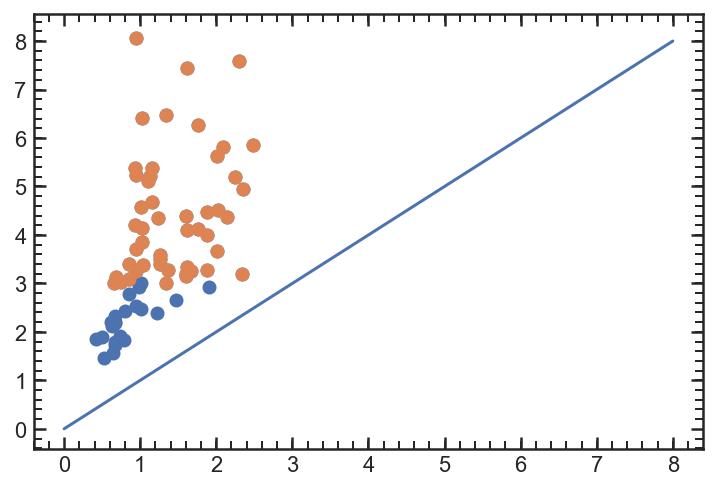

In [745]:
plt.scatter(Adb.query('log_Sigma1 > 10.00 and sf_prob_2 < 0.2').zgrism, Adb.query('log_Sigma1 > 10.00 and sf_prob_2 < 0.2').z_50)
plt.scatter(Adb.query('log_Sigma1 > 10.00 and sf_prob_2 < 0.2 and z_50 > 3').zgrism, Adb.query('log_Sigma1 > 10.00 and sf_prob_2 < 0.2 and z_50 > 3').z_50)

plt.plot([0,8],[0,8])

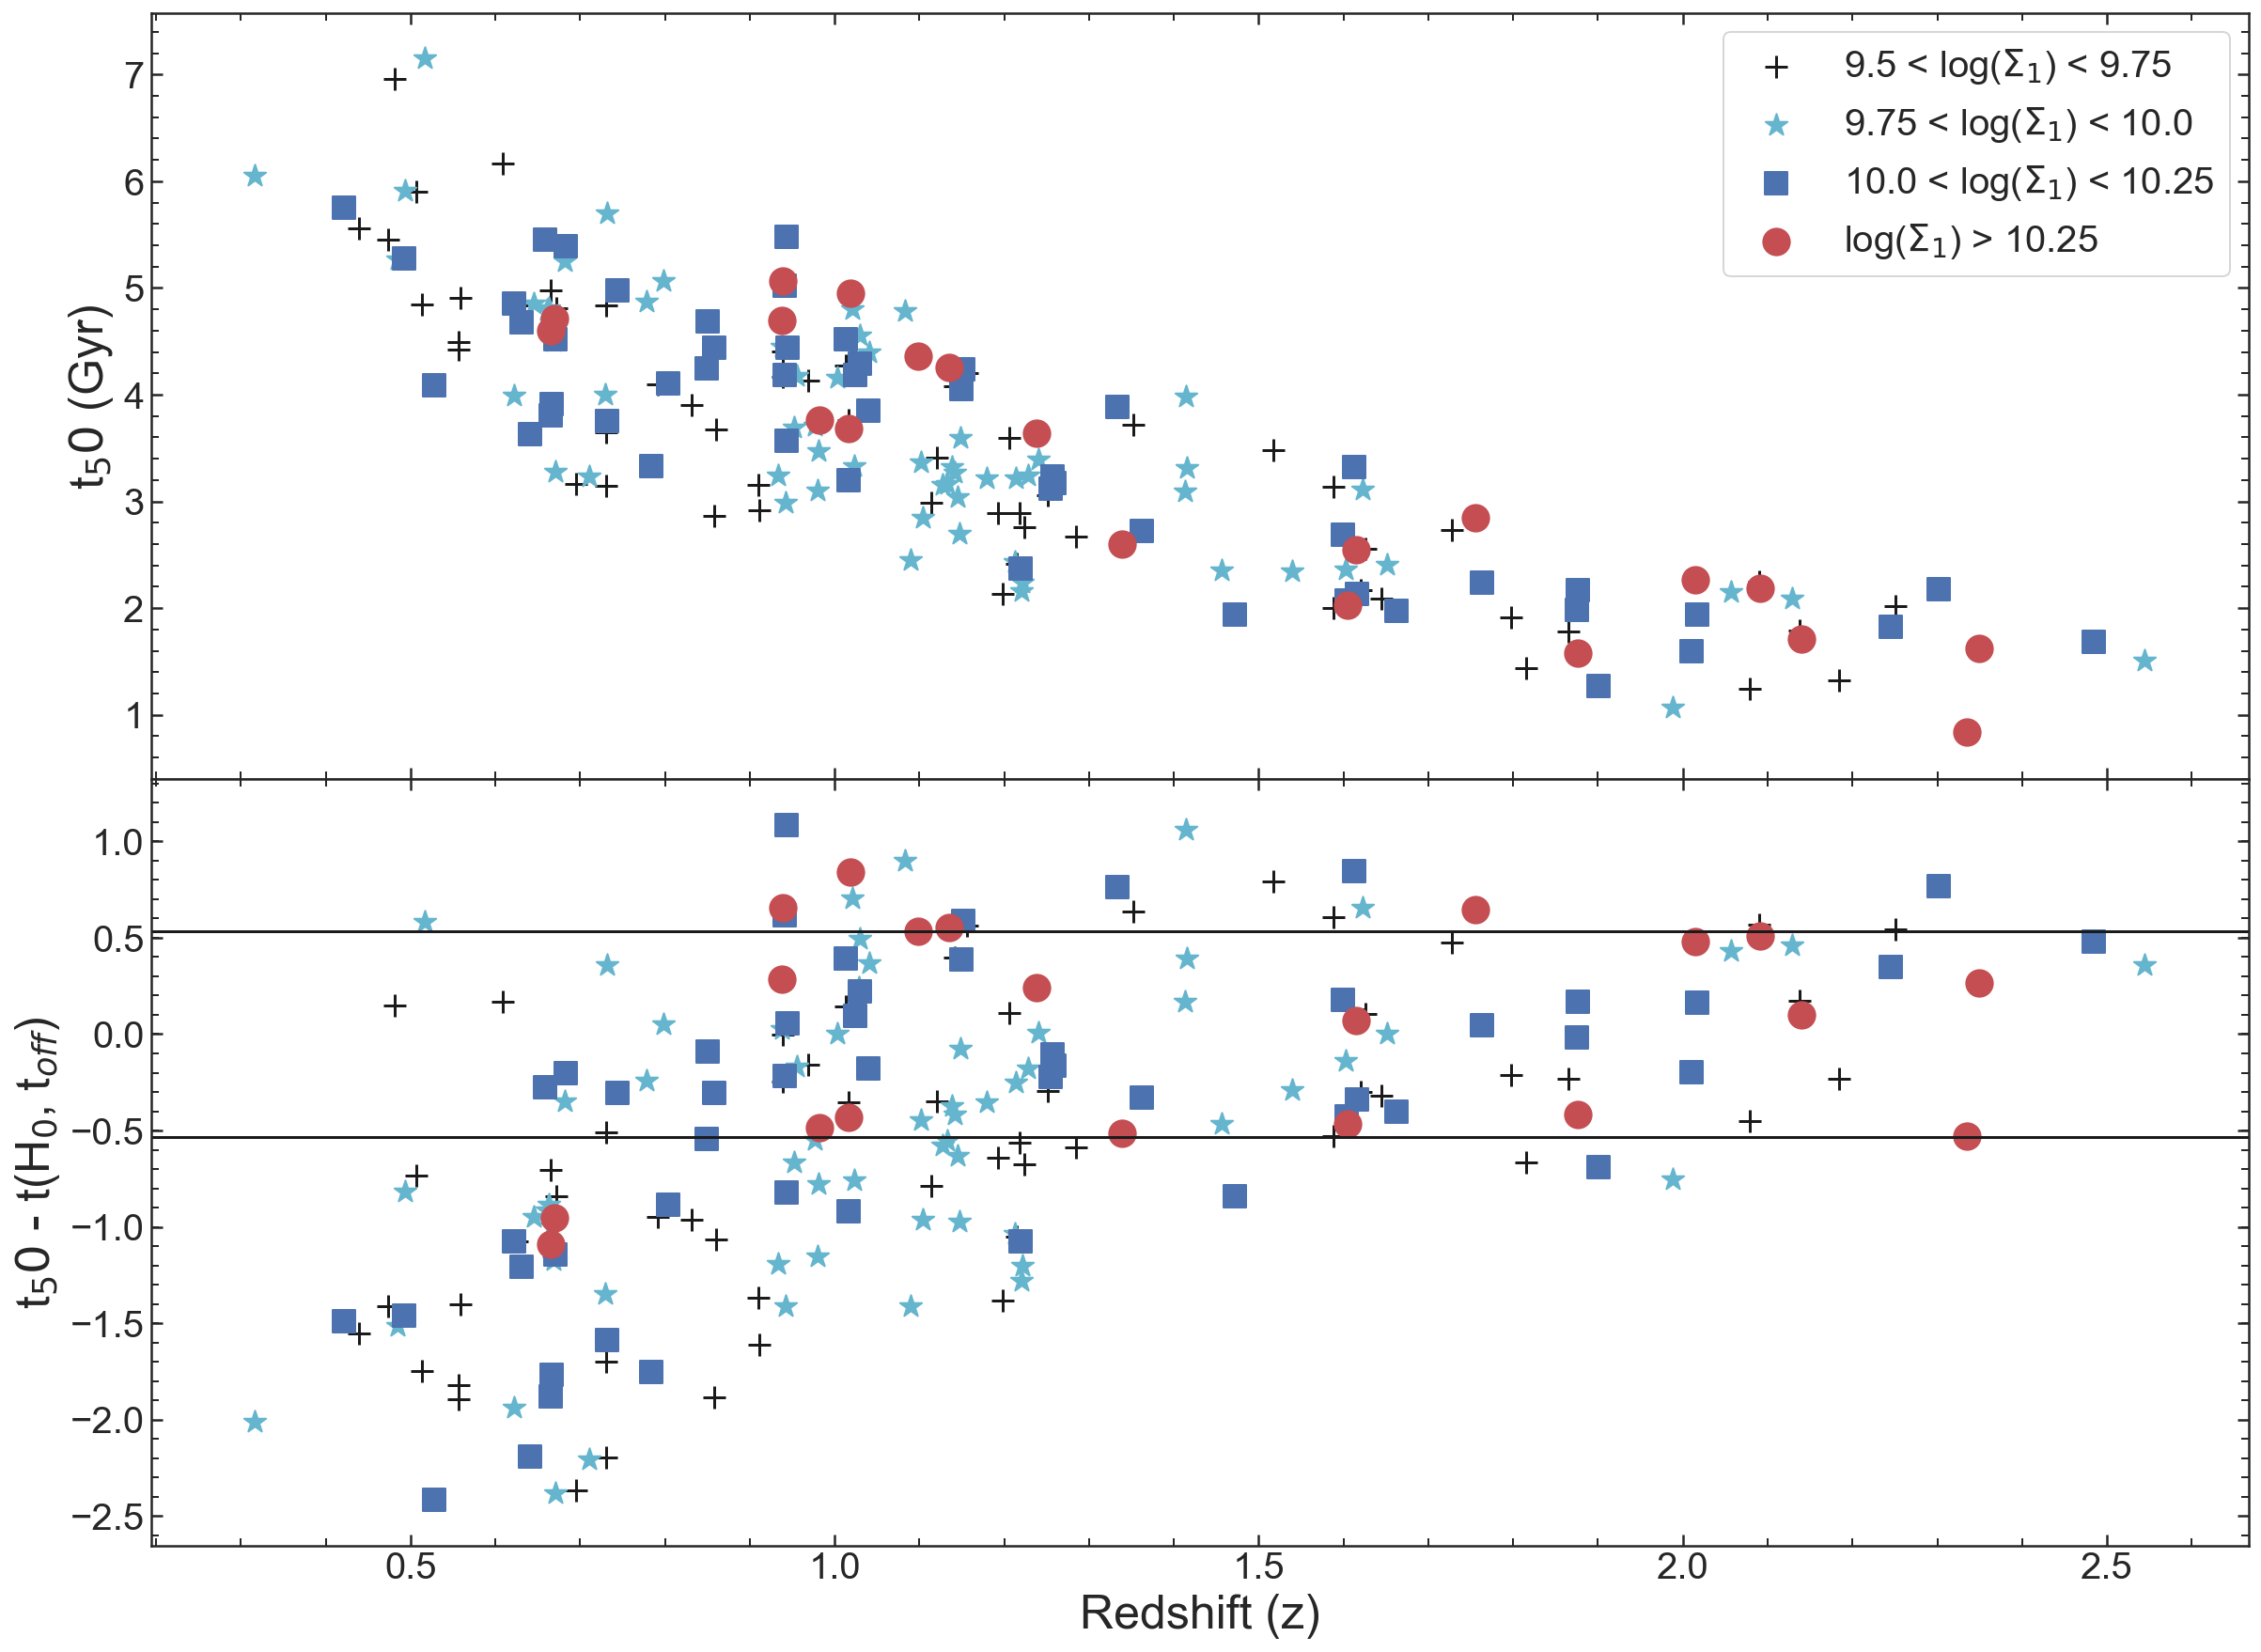

In [741]:
c1db = Adb.query('log_Sigma1 > 10.25 and sf_prob_2 < 0.2').sort_values('zgrism')
c2db = Adb.query('10 < log_Sigma1 < 10.25 and sf_prob_2 < 0.2').sort_values('zgrism')
c3db = Adb.query('9.75 < log_Sigma1 < 10. and sf_prob_2 < 0.2').sort_values('zgrism')
c4db = Adb.query('9.5 < log_Sigma1 < 9.75 and sf_prob_2 < 0.2').sort_values('zgrism')

gs = gridspec.GridSpec(2,1, hspace=0)

plt.figure(figsize=[20,15])
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

ax1.scatter(c4db.zgrism, c4db.t_50, color = 'k', marker = '+', s=150, label = '9.5 < log($\Sigma_1$) < 9.75')
ax1.scatter(c3db.zgrism, c3db.t_50, color = 'c', marker = '*', s=150, label = '9.75 < log($\Sigma_1$) < 10.0')
ax1.scatter(c2db.zgrism, c2db.t_50, color = 'b', marker = 's', s=150, label = '10.0 < log($\Sigma_1$) < 10.25')
ax1.scatter(c1db.zgrism, c1db.t_50, color = 'r', marker = 'o', s=200, label = 'log($\Sigma_1$) > 10.25 ')
ax1.legend(fontsize = 20)

cosmo = FlatLambdaCDM(H0=74.62, Om0=0.3)
H_age = cosmo.age(rshifts).value

ax2.scatter(c4db.zgrism, c4db.t_50 - (cosmo.age(c4db.zgrism).value - 1.22), color = 'k', marker = '+', s=150)
ax2.scatter(c3db.zgrism, c3db.t_50 - (cosmo.age(c3db.zgrism).value - 1.22), color = 'c', marker = '*', s=150)
ax2.scatter(c2db.zgrism, c2db.t_50 - (cosmo.age(c2db.zgrism).value - 1.22), color = 'b', marker = 's', s=150)
ax2.scatter(c1db.zgrism, c1db.t_50 - (cosmo.age(c1db.zgrism).value - 1.22), color = 'r', marker = 'o', s=200)
ax2.axhline(-np.sqrt(np.exp(-1.26)), color = 'k')
ax2.axhline(np.sqrt(np.exp(-1.26)), color = 'k')

ax1.tick_params(axis='both', which='major', labelsize=20)
ax2.tick_params(axis='both', which='major', labelsize=20)

ax2.set_xlabel('Redshift (z)', fontsize=25)
ax1.set_ylabel('t$_50$ (Gyr)', fontsize=25)
ax2.set_ylabel('t$_50$ - t(H$_0$, t$_{off}$)', fontsize=25)

plt.savefig('../plots/research_update/progen_bias.png', bbox_inches = 'tight') 

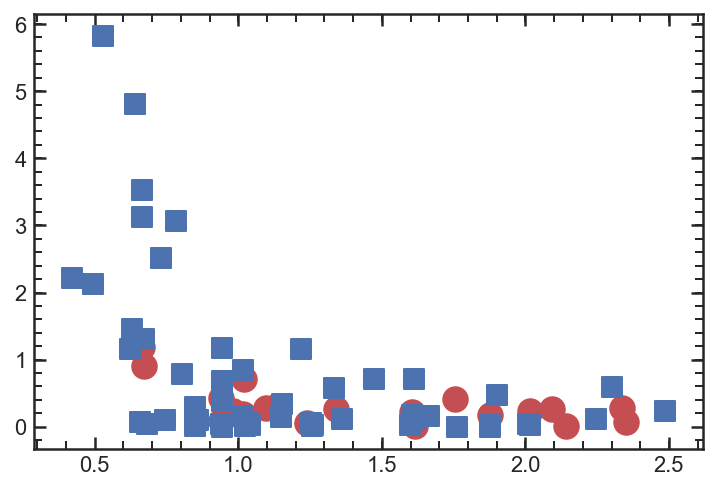

In [666]:
cosmo = FlatLambdaCDM(H0=74.62, Om0=0.3)
H_age = cosmo.age(c1db.zgrism).value
SIG = c1db.t_50 - (H_age - 1.22)
serr = sym_err(c1db, 't_50')
plt.scatter(c1db.zgrism, SIG**2, color = 'r', marker = 'o', s=150)

H_age = cosmo.age(c2db.zgrism).value
SIG = c2db.t_50 - (H_age - 1.22)
serr = sym_err(c2db, 't_50')
plt.scatter(c2db.zgrism, SIG**2, color = 'b', marker = 's', s=100)




# plt.axhline(1)
# plt.axhline(-1)

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


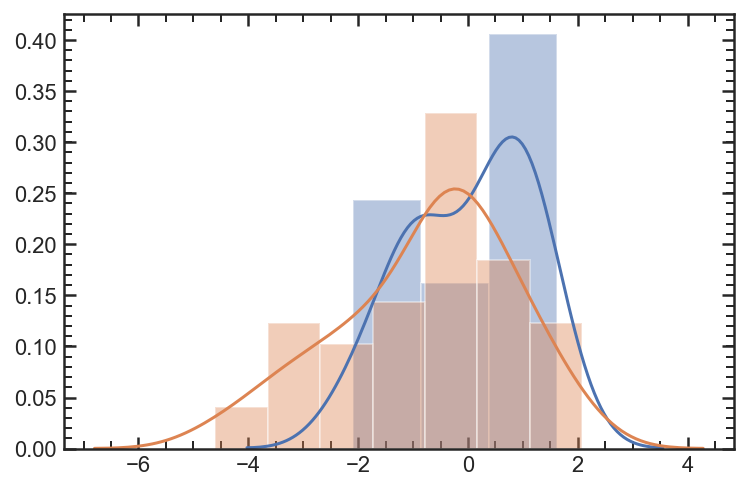

In [657]:
cosmo = FlatLambdaCDM(H0=74.62, Om0=0.3)

H_age = cosmo.age(c1db.zgrism).value
sig = np.sqrt(-0.01*c1db.zgrism + np.exp(-1.27))
sea.distplot((c1db.t_50 - (H_age - 1.22))/sig)


H_age = cosmo.age(c2db.zgrism).value
sig = np.sqrt(-0.01*c2db.zgrism + np.exp(-1.27))
sea.distplot((c2db.t_50 - (H_age - 1.22))/sig)

In [575]:
cosmo = FlatLambdaCDM(H0=75.11, Om0=0.3)
H_curve = cosmo.age(rshifts).value
toff = 1.19

rshifts = Adb.query('10 < log_Sigma1 < 10.25 and sf_prob_2 < 0.2').sort_values('zgrism').zgrism.values
t50s = Adb.query('10 < log_Sigma1 < 10.25 and sf_prob_2 < 0.2').sort_values('zgrism').t_50.values
serr = sym_err(Adb.query('10 < log_Sigma1 < 10.25 and sf_prob_2 < 0.2').sort_values('zgrism'), 't_50')

def ln_likelihood_progen(pars):
    """ The likelihood function evaluation requires a particular set of model parameters and the data """
    Va, lnVb = pars

    V = -Va * rshifts + np.exp(lnVb)
    V[V<0] = 0

    N = len(t50s)
        
    dy = t50s - (H_curve - toff)
    ivar = 1 / (serr**2 + V) # inverse-variance now includes intrinsic scatter
    return -0.5 * (N*np.log(2*np.pi) - np.sum(np.log(ivar)) + np.sum(dy**2 * ivar))

def prior_progen(u):
#     Va = Gaussian_prior(u[0], [-0.5, 0.5], 0, 0.25)
#     lnVb = Gaussian_prior(u[1], [0, -3], -1.5, 0.5)
    
    Va = 4*u[0] - 2
    lnVb = -10*u[1] + 5 
    
    return Va, lnVb

In [572]:
vsampler = dynesty.DynamicNestedSampler(ln_likelihood_progen, prior_progen, ndim = 2, bound = 'multi')

In [573]:
vsampler.run_nested(wt_kwargs={'pfrac': 1.0}, dlogz_init=0.01, print_progress=True)


0it [00:00, ?it/s]/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in log



ValueError: The log-likelihood (nan) of live point 4 located at u=[0.91097538 0.69930704] v=[ 1.64390152 -1.99307038]  is invalid.

In [555]:
vres = vsampler.results

(<Figure size 396x396 with 4 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1ac3855080>,
       dtype=object))

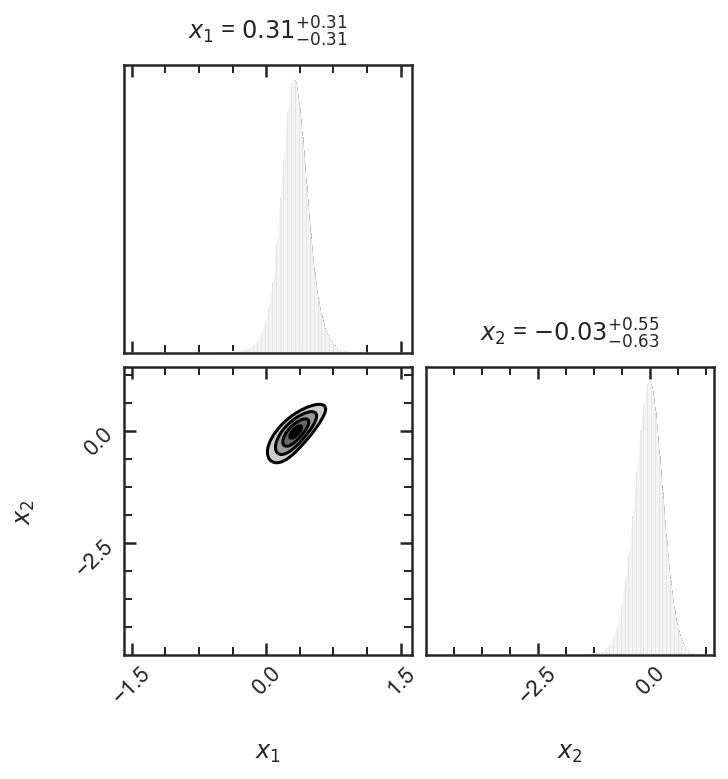

In [556]:
dyplot.cornerplot(vres,show_titles=True, max_n_ticks=3, title_kwargs={'y': 1.05},
                           quantiles=None)

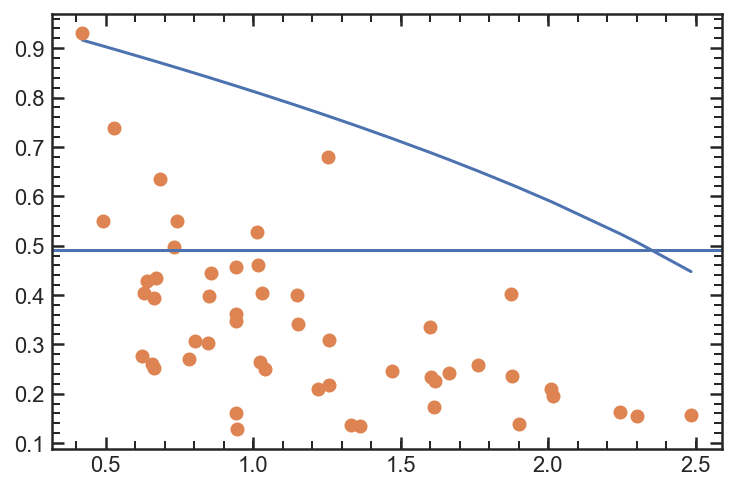

In [578]:
V = -.31 * rshifts + np.exp(-0.03)

plt.plot(rshifts, np.sqrt(V))
plt.plot(rshifts, serr, 'o')
plt.axhline(np.sqrt(np.exp(-1.42)))

0.4916441974609651


<ErrorbarContainer object of 3 artists>

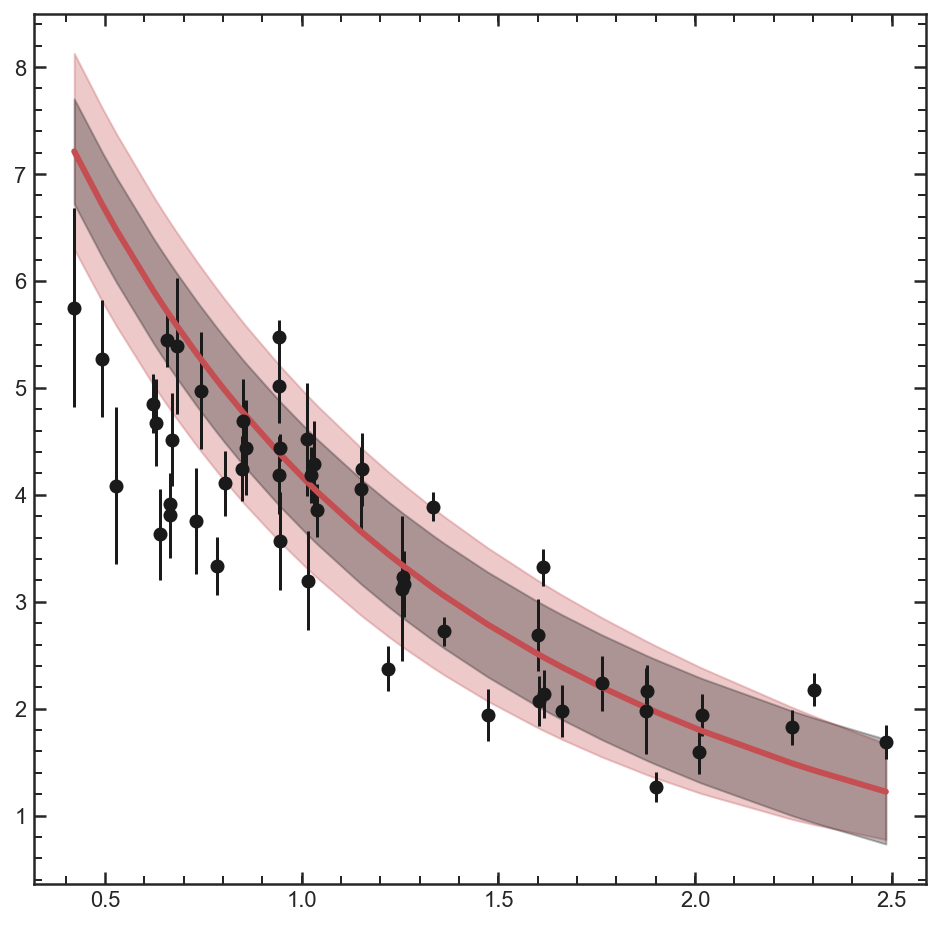

In [581]:
plt.figure(figsize=[8,8])

print(np.sqrt(np.exp(-1.42)))
cosmo = FlatLambdaCDM(H0=75.11, Om0=0.3)
H_age = cosmo.age(rshifts).value
sig = np.sqrt(V)
plt.plot(rshifts, cosmo.age(rshifts).value - 1.19, color = 'r', linewidth = 3)
plt.fill_between(rshifts, H_age - 1.19 - sig, H_age - 1.19 + sig, color = 'r', alpha = 0.3)
plt.fill_between(rshifts, H_age - 1.19 - 0.49, H_age - 1.19 + 0.49, color = 'k', alpha = 0.3)

plt.errorbar(rshifts, t50s, serr, color = 'k', fmt='o')

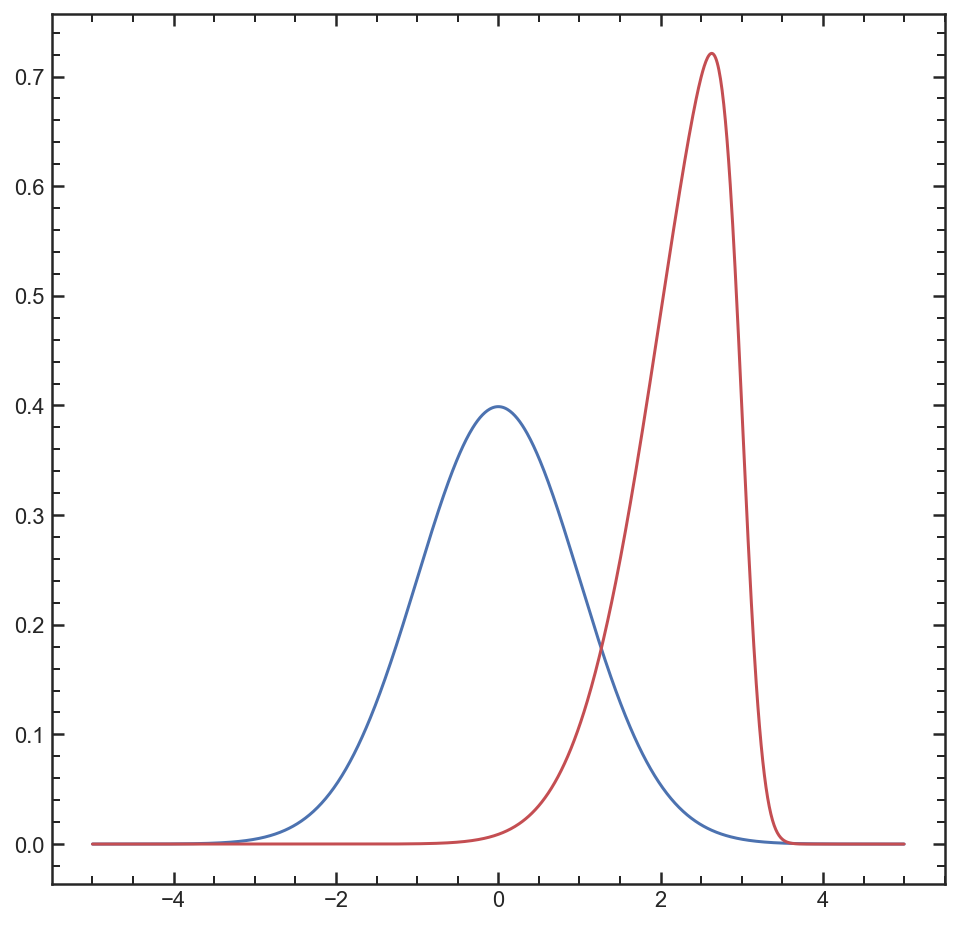

In [610]:
x = np.linspace(0-5, 5, 1000)  
 
plt.figure(figsize=[8,8])
# Varying positional arguments  
y1 = stats.skewnorm.pdf(x, 0, 0, 1)  
y2 = stats.skewnorm.pdf(x, -5, 3, 1)  
plt.plot(x, y1, x, y2, "r")

In [10]:
np.random.normal(0, 0.5)

-0.24948743063112527

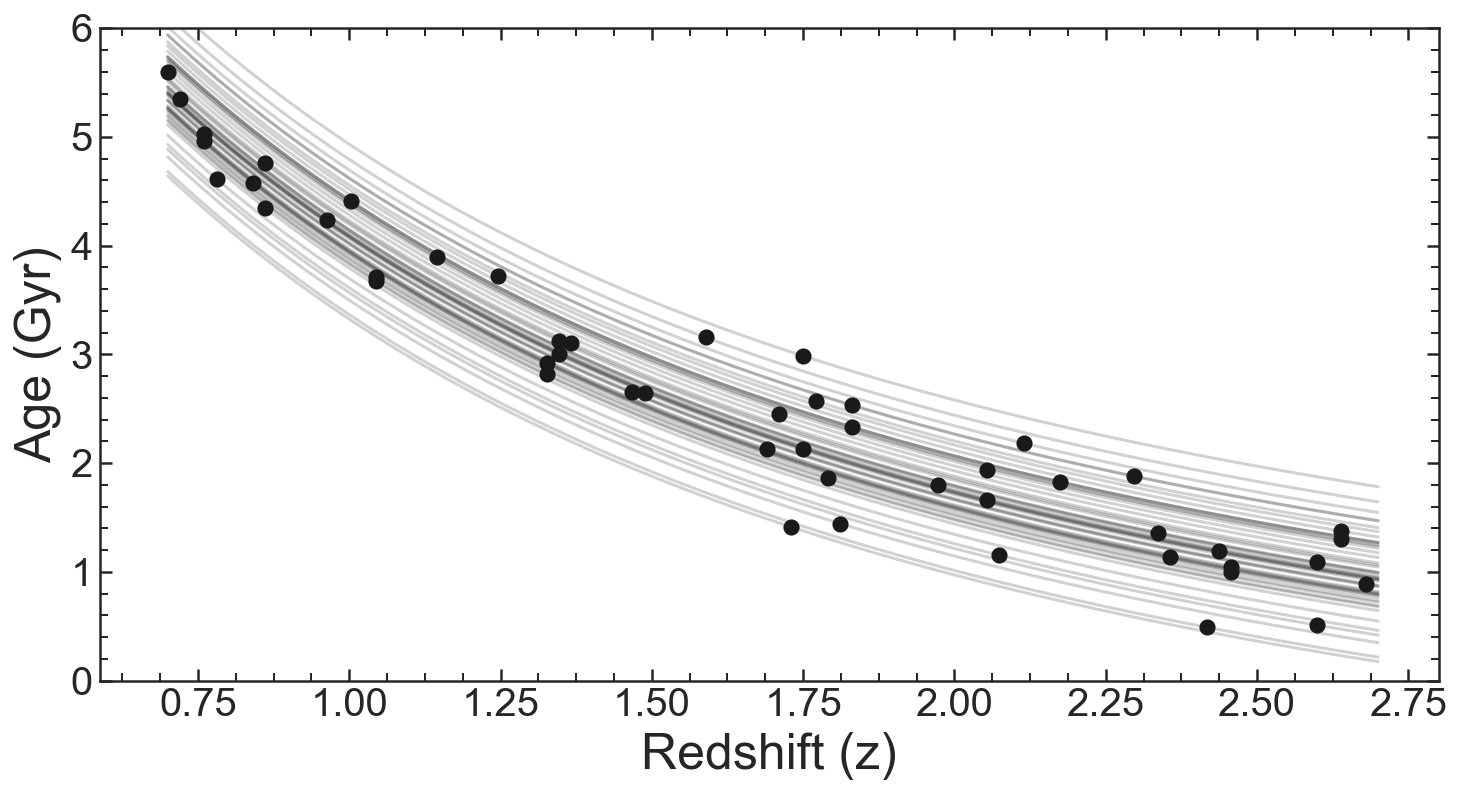

In [35]:
cosmo = FlatLambdaCDM(H0=75.11, Om0=0.3)


plt.figure(figsize = [12,6])
ax1 = plt.subplot()

# ax1.plot(np.linspace(0.7,2.7,100), cosmo.age(np.linspace(0.7,2.7,100)).value - 1.2, color = 'r', linewidth = 3)
# ax1.fill_between(np.linspace(0.7,2.7,100), 
#                  cosmo.age(np.linspace(0.7,2.7,100)).value - 1.6, 
#                  cosmo.age(np.linspace(0.7,2.7,100)).value - 0.8, color = 'r', alpha = 0.3)

np.random.seed(4)
for x in range(50):
    sig = np.random.normal(0, 0.4)
    ax1.plot(np.linspace(0.7,2.7,100), 
                cosmo.age(np.linspace(0.7,2.7,100)).value - (1.2 + sig), alpha = 0.2, color = 'k')
    age = np.random.choice(np.linspace(0.7,2.7,100), )
    ax1.scatter(age, cosmo.age(age).value - (1.2 + sig), color = 'k', s = 50)

ax1.set_ylim(0,6)
ax1.set_xlabel('Redshift (z)', fontsize=25)
ax1.set_ylabel('Age (Gyr)', fontsize=25)
ax1.tick_params(axis='both', which='major', labelsize=20)
plt.savefig('../plots/research_update/chronometer_pop1.png', bbox_inches = 'tight')    

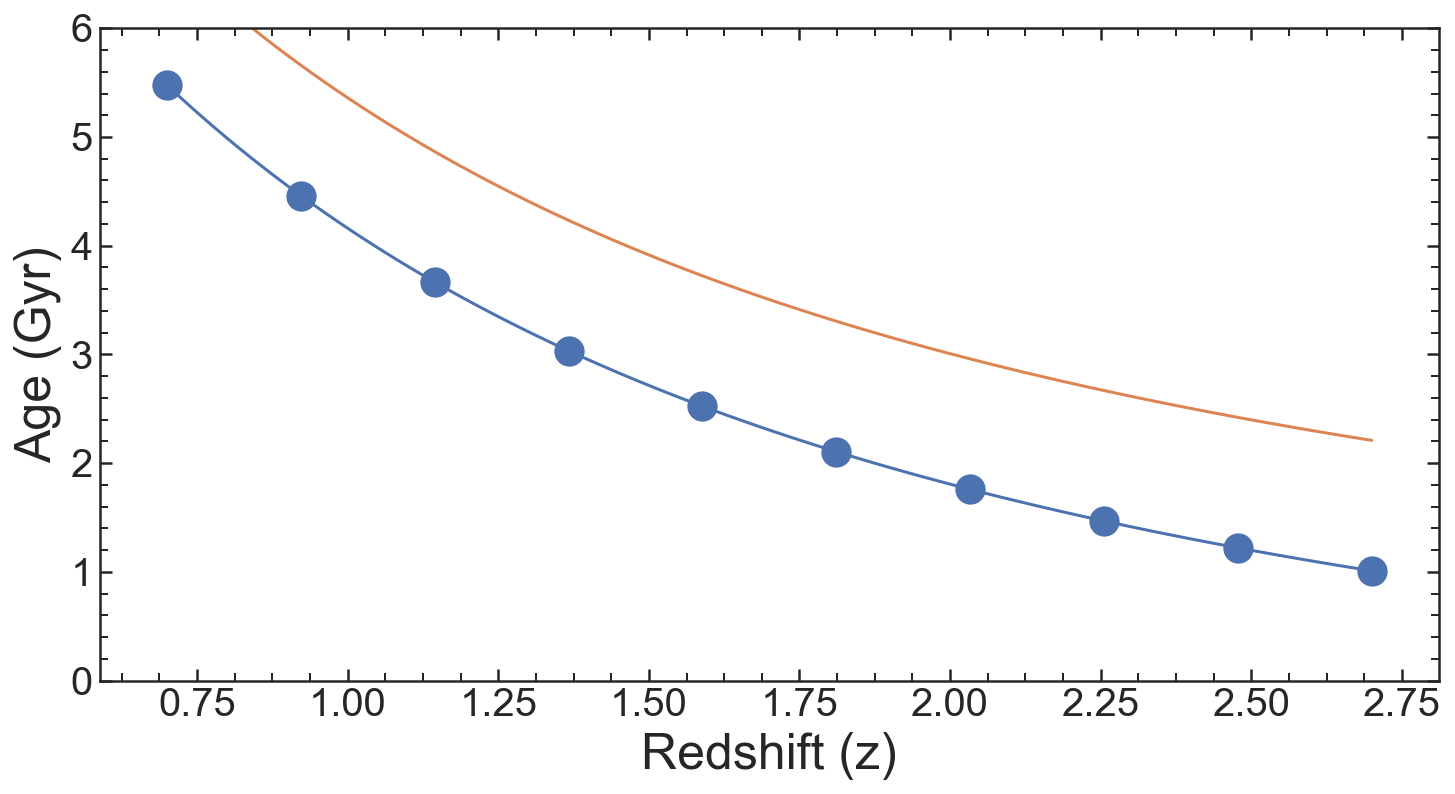

In [41]:
plt.figure(figsize = [12,6])
ax1 = plt.subplot()
ax1.scatter(np.linspace(0.7,2.7,10), cosmo.age(np.linspace(0.7,2.7,10)).value - 1.2, s = 200)
ax1.plot(np.linspace(0.7,2.7,100), cosmo.age(np.linspace(0.7,2.7,100)).value - 1.2)
ax1.plot(np.linspace(0.7,2.7,100), cosmo.age(np.linspace(0.7,2.7,100)).value )

ax1.set_ylim(0,6)
ax1.set_xlabel('Redshift (z)', fontsize=25)
ax1.set_ylabel('Age (Gyr)', fontsize=25)
ax1.tick_params(axis='both', which='major', labelsize=20)
plt.savefig('../plots/research_update/chronometer2.png', bbox_inches = 'tight')    

In [14]:
def chi2(D,M,S):
    return np.sum(((D-M)/S)**2)

In [15]:
H= np.linspace(50,100,300)
zs = np.linspace(0,4,100)
iA = []


for i in range(len(H)):
    cosmo = FlatLambdaCDM(H0=H[i], Om0=0.3)
    iA.append(interp1d(zs,cosmo.age(zs).value))

In [109]:
offset = np.linspace(0.5,1.5,200)

output = np.zeros([len(H), len(offset)])

for i in range(len(iA)):
    for ii in range(len(offset)):
        output[i][ii] = chi2(t50s, iA[i](rshifts) - offset[ii], serr)

In [110]:
P = np.exp(-output/2)

PH = []
Poff = []
for i in range(len(P)):
    PH.append(np.trapz(P[i],offset))

for i in range(len(P.T)):
    Poff.append(np.trapz(P.T[i],H))

PH = PH / np.trapz(PH,H)
Poff = Poff / np.trapz(Poff,offset)

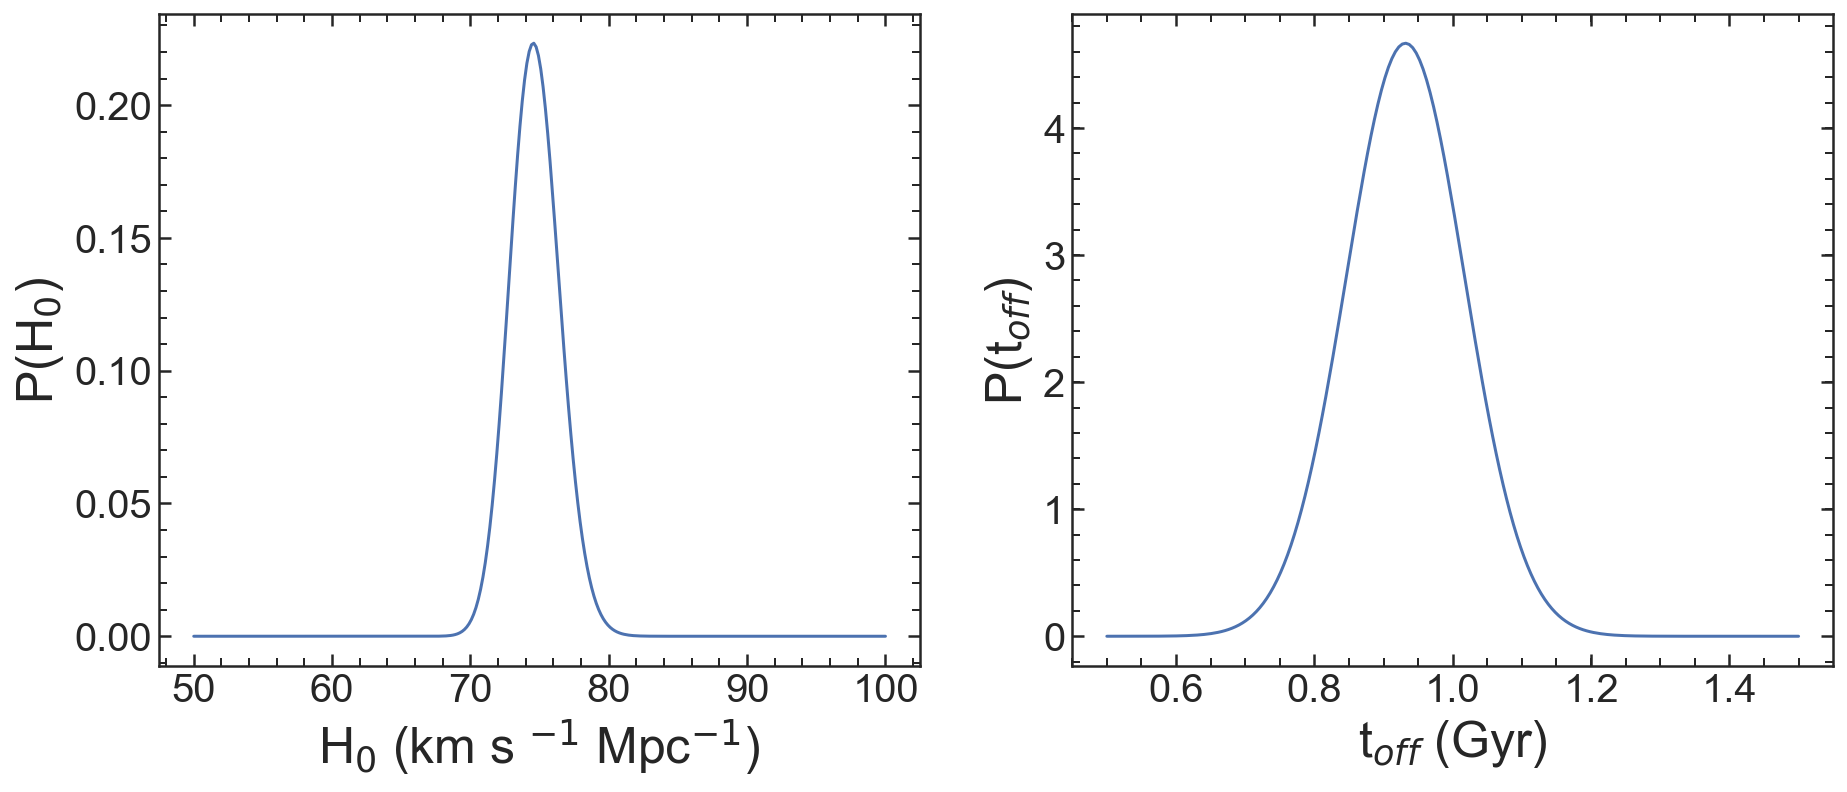

In [111]:
plt.figure(figsize=[15,6])
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)

ax1.plot(H,PH)
ax2.plot(offset,Poff)

ax1.set_xlabel('H$_0$ (km s $^{-1}$ Mpc$^{-1}$)', fontsize=25)
ax1.set_ylabel('P(H$_0$)', fontsize=25)
ax1.tick_params(axis='both', which='major', labelsize=20)

ax2.set_xlabel('t$_{off}$ (Gyr)', fontsize=25)
ax2.set_ylabel('P(t$_{off}$)', fontsize=25)
ax2.tick_params(axis='both', which='major', labelsize=20)
plt.savefig('../plots/research_update/prob.png', bbox_inches = 'tight')    

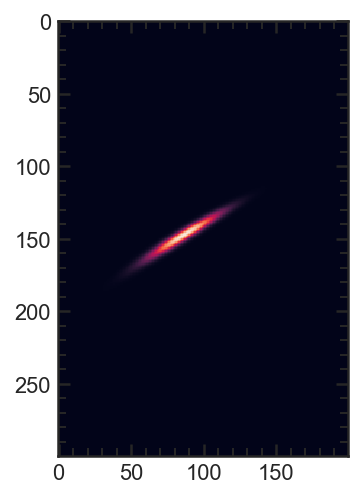

In [20]:
plt.imshow(P)

In [44]:
m,hdr,mod = Highest_density_region(PH,H)
print(np.round(m,2),np.round((hdr[1] - hdr[0])/2,2))

m,hdr,mod = Highest_density_region(Poff,offset)
print(np.round(m,2),np.round((hdr[1] - hdr[0])/2,2))

74.58 1.76
0.93 0.09


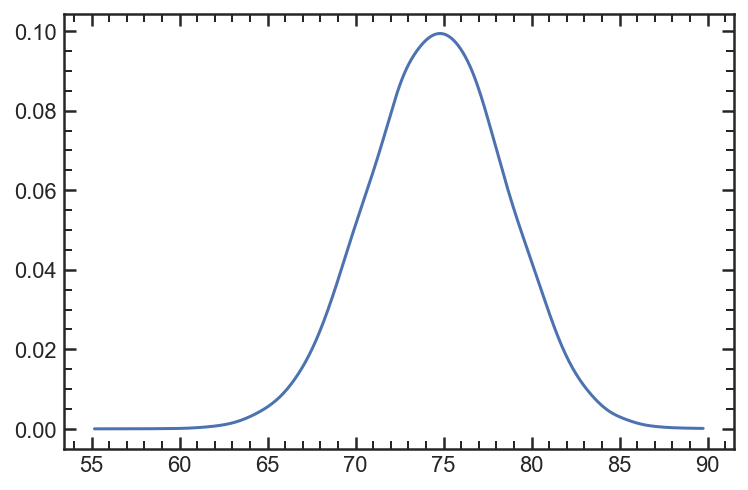

In [696]:
H, PH  = Get_posterior(dres, 0)
offset, Poff  = Get_posterior(dres, 0)

plt.plot(H, PH)


In [697]:
from spec_tools import Gen_PPF
ppf_dict = {'H' :  Gen_PPF(H,PH), 'off' :  Gen_PPF(offset,Poff)}


draw = np.zeros(2)
params = ['H', 'off']
for i in range(len(draw)):
    draw[i] = ppf_dict[params[i]](np.random.rand(1))[0]

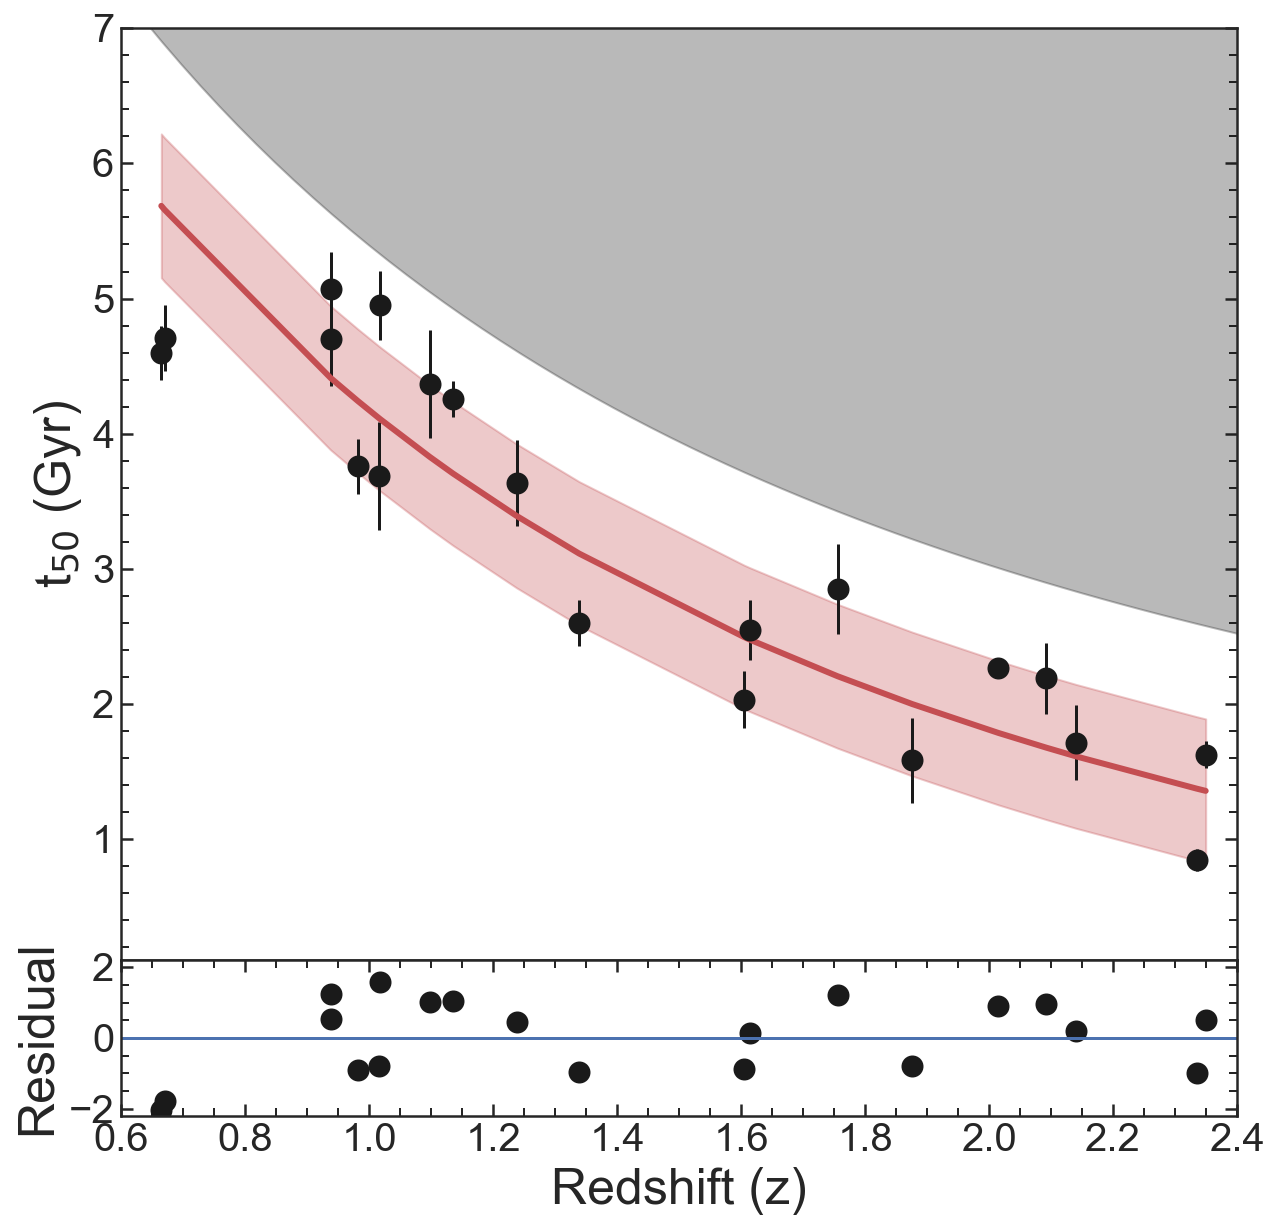

In [723]:
cosmo = FlatLambdaCDM(H0=74.52, Om0=0.3)

gs = gridspec.GridSpec(2,1,height_ratios=[6,1], hspace=0)

plt.figure(figsize = [10,10])
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])
ax1.errorbar(rshifts,t50s, serr, linestyle = 'none', fmt ='o', ms = 10, color = 'k')

cosmo = FlatLambdaCDM(H0=74.66, Om0=0.3)
H_age = cosmo.age(rshifts).value
sig = np.sqrt(-0.0*rshifts + np.exp(-1.26))
ax1.plot(rshifts, cosmo.age(rshifts).value - 1.22, color = 'r', linewidth = 3)
ax1.fill_between(rshifts, H_age - 1.22 - sig, H_age - 1.22 + sig, color = 'r', alpha = 0.3)

ax1.fill_between(np.linspace(0,3,100), cosmo.age(np.linspace(0,3,100)).value, np.repeat(8, 100), 
                 alpha = 0.3, color = 'k')

ax2.scatter(rshifts,(t50s - (H_age - 1.22))/sig, color = 'k', s = 100)
ax2.axhline(0)

ax1.set_ylim(0.1,7)
ax2.set_xlabel('Redshift (z)', fontsize=25)
ax1.set_ylabel('t$_{50}$ (Gyr)', fontsize=25)
ax2.set_ylabel('Residual', fontsize=25)
ax1.tick_params(axis='both', which='major', labelsize=20)
ax2.tick_params(axis='both', which='major', labelsize=20)

ax1.set_xlim(0.6,2.4)
ax2.set_xlim(0.6,2.4)

ax1.set_xticks([])
ax2.set_ylim(-2.2,2.2)

plt.savefig('../plots/research_update/chronometer_4.png', bbox_inches = 'tight')   

In [707]:
np.std((t50s - (H_age - 1.22))/sig)

1.0545809564175044

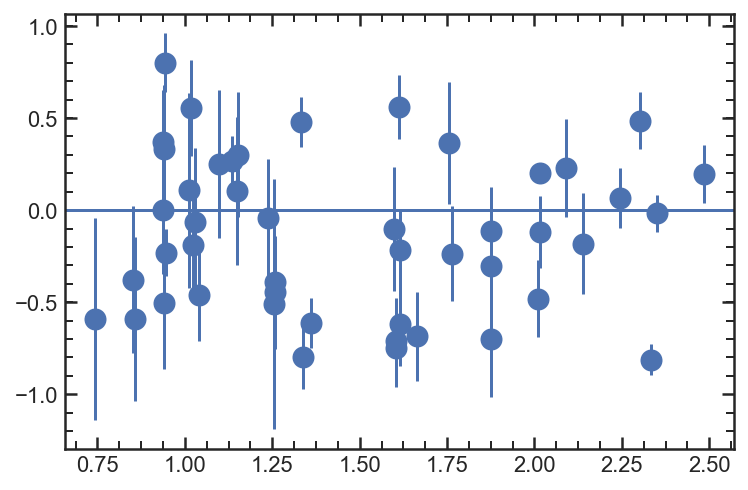

In [144]:
cosmo = FlatLambdaCDM(H0=74.55, Om0=0.3)
ax2 = plt.subplot()
ax2.errorbar(rshifts,t50s - (cosmo.age(rshifts).value - 0.94), serr, linestyle = 'none', fmt ='o', ms = 10)
ax2.axhline(0)

# TEST

In [794]:
Cdb = Adb.query('log_Sigma1 > 10.0 and sf_prob_2 < 0.2').sort_values('zgrism') 
rshifts = Cdb.zgrism.values
t50s = Cdb.t_50.values
serr = sym_err(Cdb, 't_50')

cosmo = FlatLambdaCDM(H0=76, Om0=0.3)
z50L = np.array([z_at_value(cosmo.lookback_time,Cdb.t_50[U]*u.Gyr + cosmo.lookback_time(Cdb.zgrism[U])) for U in Cdb.index])

cosmo = FlatLambdaCDM(H0=65, Om0=0.3)
z50P = np.array([z_at_value(cosmo.lookback_time,Cdb.t_50[U]*u.Gyr + cosmo.lookback_time(Cdb.zgrism[U])) for U in Cdb.index])

54
44


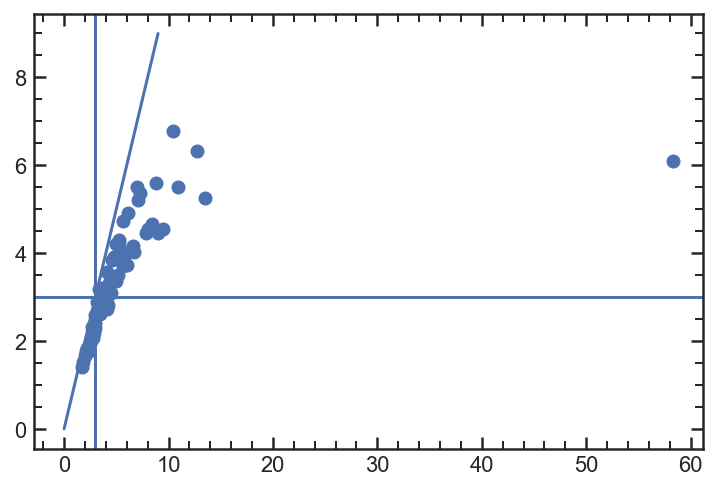

In [795]:
plt.scatter(z50L, z50P)
plt.plot([0,9],[0,9])
plt.axvline(3)
plt.axhline(3)


print(len(z50L[z50L > 3 ]))
print(len(z50P[z50P > 3 ]))

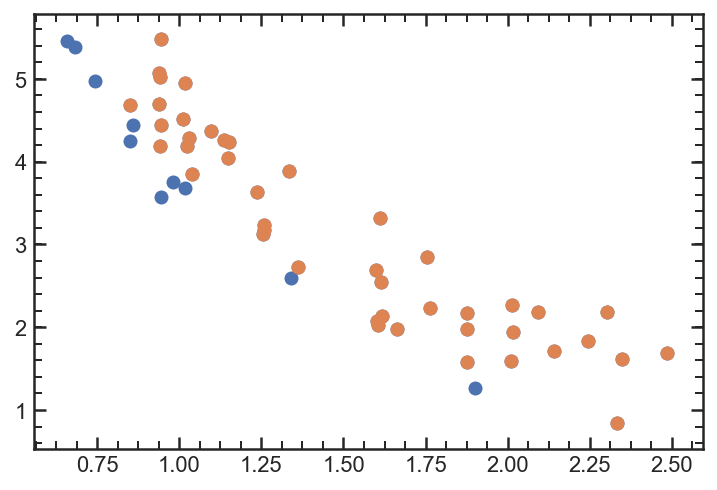

In [796]:
plt.scatter(rshifts[z50L > 3 ], t50s[z50L > 3 ])
plt.scatter(rshifts[z50P > 3 ], t50s[z50P > 3 ])

In [829]:
# limits of 50-90
cosmo = FlatLambdaCDM(H0=50, Om0=0.3)
z50l = np.repeat(True, len(t50s))
for i in range(len(t50s)):
    z50l[i] = (t50s[i]*u.Gyr +cosmo.lookback_time(rshifts[i])) > cosmo.lookback_time(3)

cosmo = FlatLambdaCDM(H0=90, Om0=0.3)
z50h = np.repeat(True, len(t50s))
for i in range(len(t50s)):
    z50h[i] = (t50s[i]*u.Gyr +cosmo.lookback_time(rshifts[i])) > cosmo.lookback_time(3)

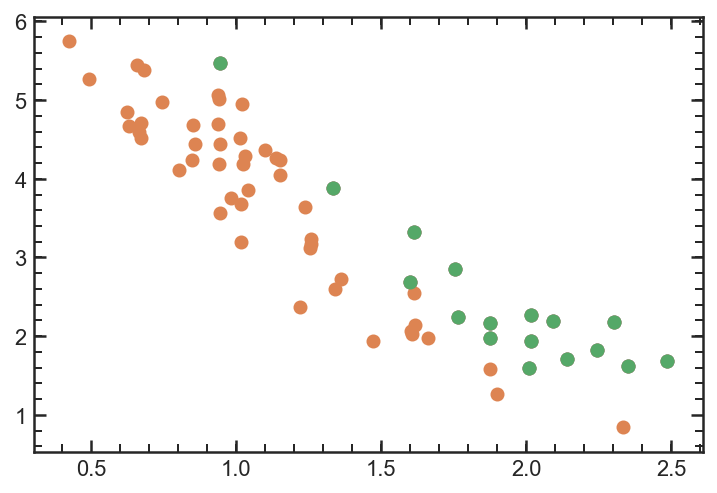

In [831]:
plt.scatter(rshifts[z50h], t50s[z50h])
plt.scatter(rshifts[z50l], t50s[z50l])


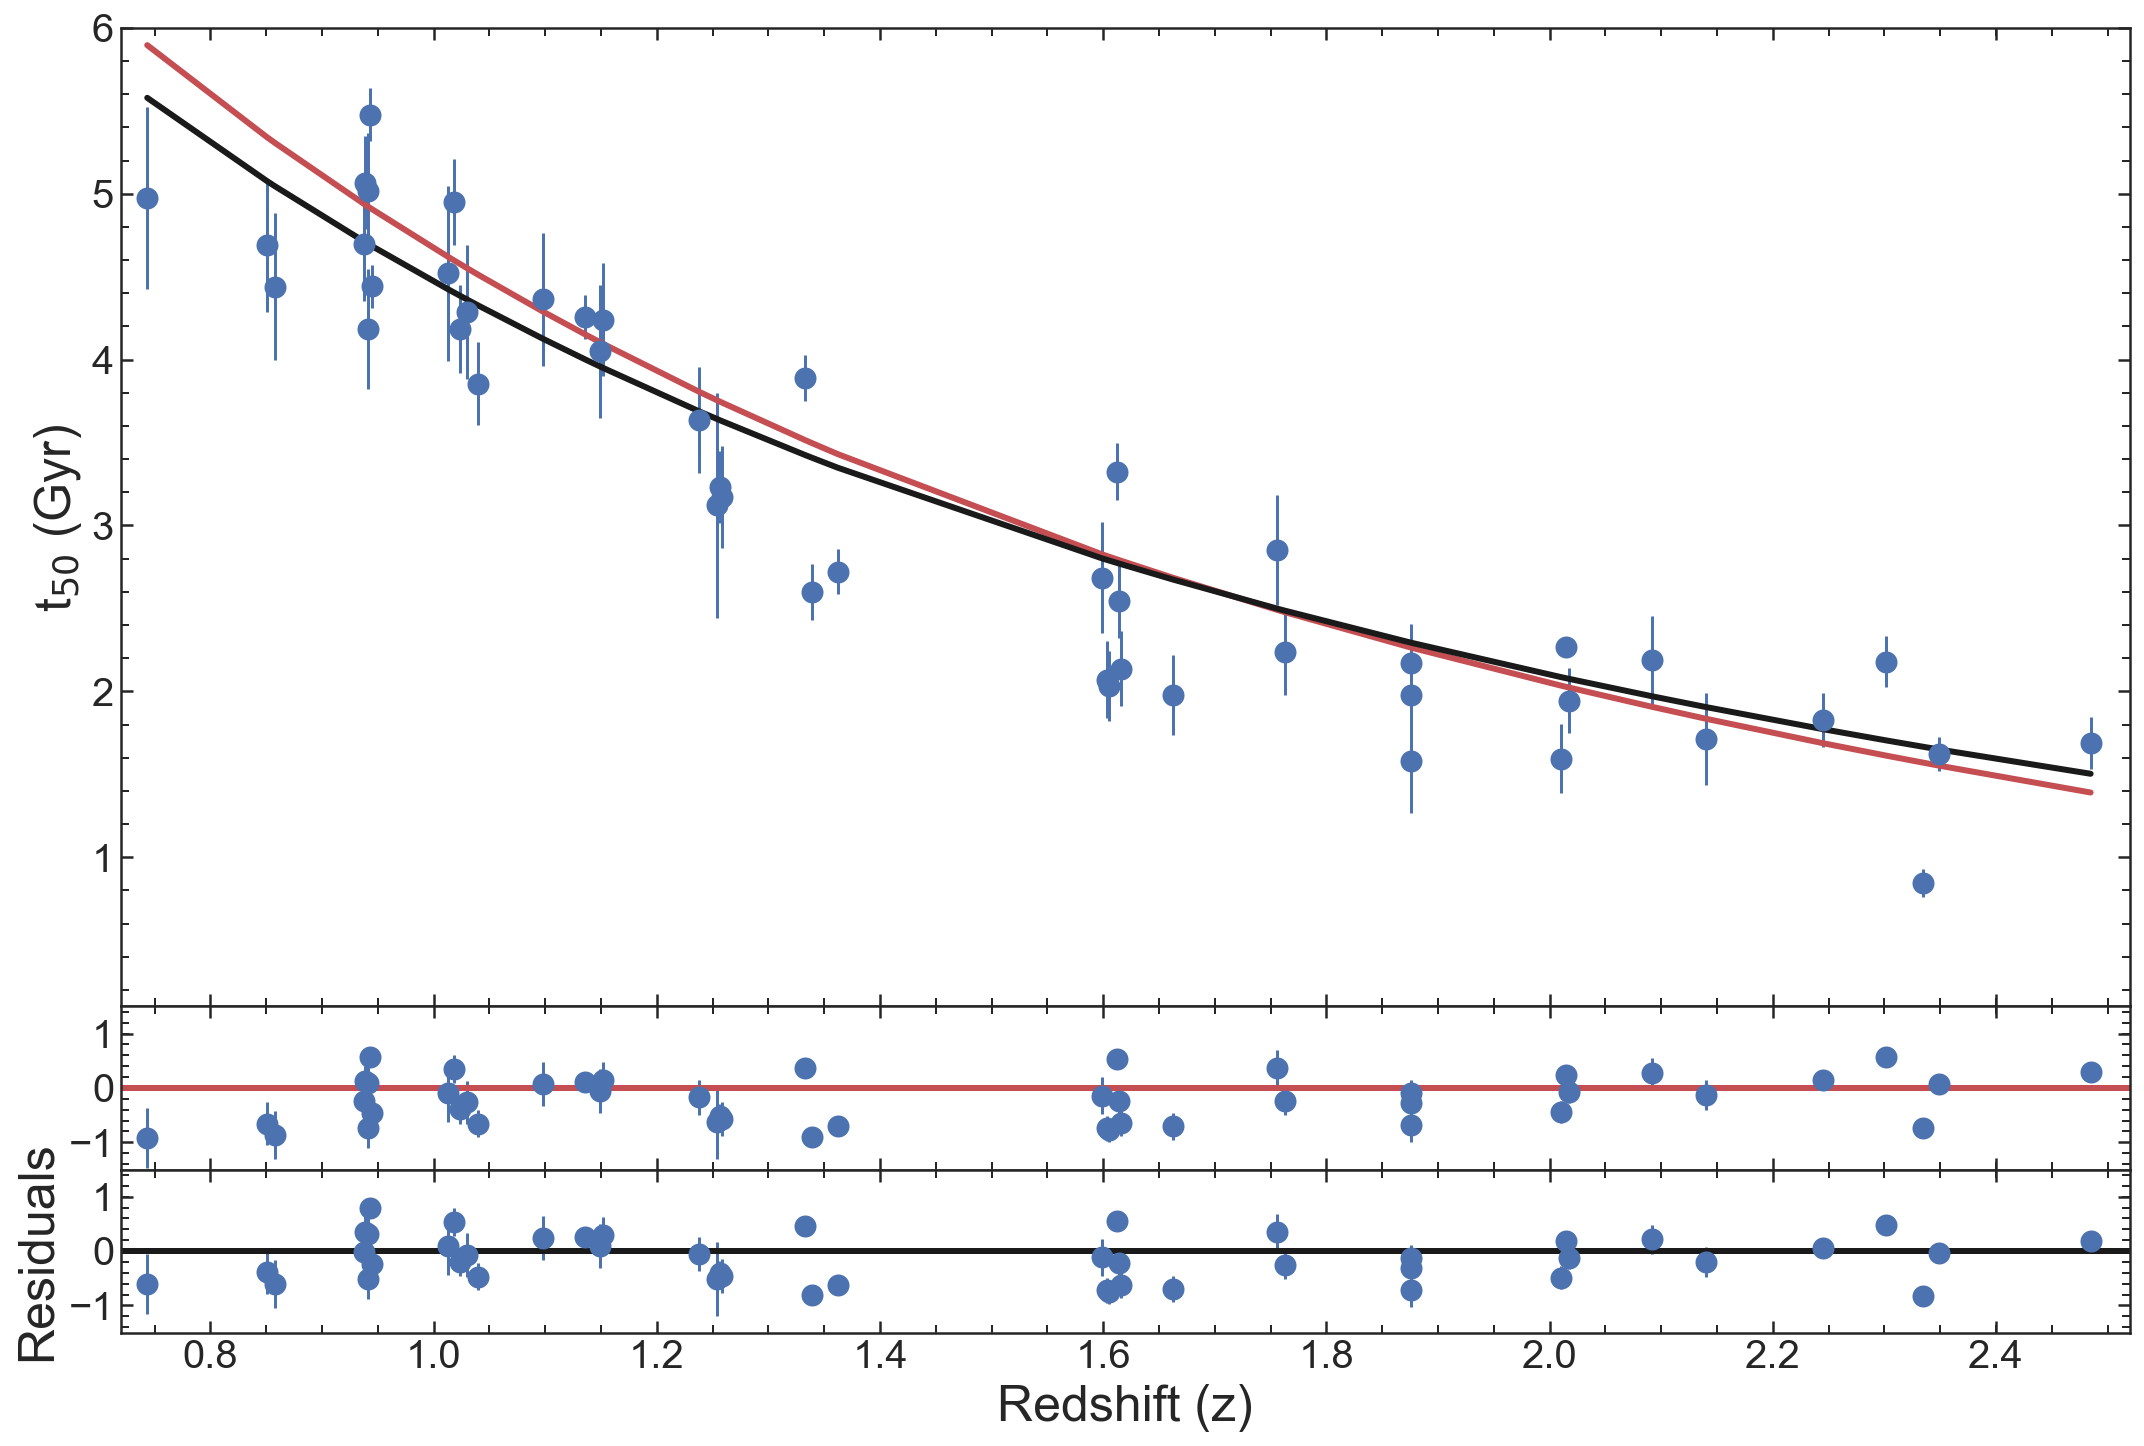

In [107]:
cosmo = FlatLambdaCDM(H0=67.4, Om0=0.3)
ax1.plot(rshifts, cosmo.age(rshifts).value - 1.3, color = 'r')
cosmo = FlatLambdaCDM(H0=74.52, Om0=0.3)
ax1.plot(rshifts, cosmo.age(rshifts).value - 0.93, color = 'k')

###########################################################################
gs = gridspec.GridSpec(3,1,height_ratios=[6,1,1],hspace=0)

plt.figure(figsize = [18,12])
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])
ax3 = plt.subplot(gs[2])

ax1.errorbar(rshifts,t50s, serr, linestyle = 'none', fmt ='o', ms = 10)

cosmo = FlatLambdaCDM(H0=67.4, Om0=0.3)
ax1.plot(rshifts, cosmo.age(rshifts).value - 1.3, color = 'r', linewidth = 3)
cosmo = FlatLambdaCDM(H0=74.52, Om0=0.3)
ax1.plot(rshifts, cosmo.age(rshifts).value - 0.93, color = 'k', linewidth = 3)

cosmo = FlatLambdaCDM(H0=67.4, Om0=0.3)
ax2.errorbar(rshifts,t50s - (cosmo.age(rshifts).value -1.3), serr, linestyle = 'none', fmt ='o', ms = 10)
ax2.axhline(0, color = 'r', linewidth = 3)

cosmo = FlatLambdaCDM(H0=74.52, Om0=0.3)
ax3.errorbar(rshifts,t50s - (cosmo.age(rshifts).value - 0.93), serr, linestyle = 'none', fmt ='o', ms = 10)
ax3.axhline(0, color = 'k', linewidth = 3)




ax1.set_ylim(0.1,6)
ax3.set_xlabel('Redshift (z)', fontsize=25)
ax1.set_ylabel('t$_{50}$ (Gyr)', fontsize=25)
ax3.set_ylabel('Residuals', fontsize=25)

ax1.tick_params(axis='both', which='major', labelsize=20)
ax2.tick_params(axis='both', which='major', labelsize=20)
ax3.tick_params(axis='both', which='major', labelsize=20)

ax1.set_xlim(0.72,2.52)
ax2.set_xlim(0.72,2.52)
ax3.set_xlim(0.72,2.52)

ax2.set_ylim(-1.5,1.5)
ax3.set_ylim(-1.5,1.5)

plt.savefig('../plots/research_update/chronometer_planck_compare.png', bbox_inches = 'tight')   

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


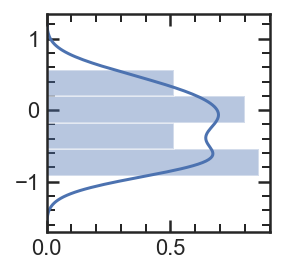

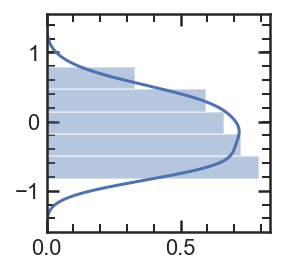

In [104]:
cosmo = FlatLambdaCDM(H0=67.4, Om0=0.3)
plt.figure(figsize = [2,2])
sea.distplot(t50s - (cosmo.age(rshifts).value -1.3),vertical = True)

plt.figure(figsize = [2,2])
cosmo = FlatLambdaCDM(H0=74.52, Om0=0.3)
sea.distplot(t50s - (cosmo.age(rshifts).value - 0.93),vertical = True)

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'linewidth'
  s)


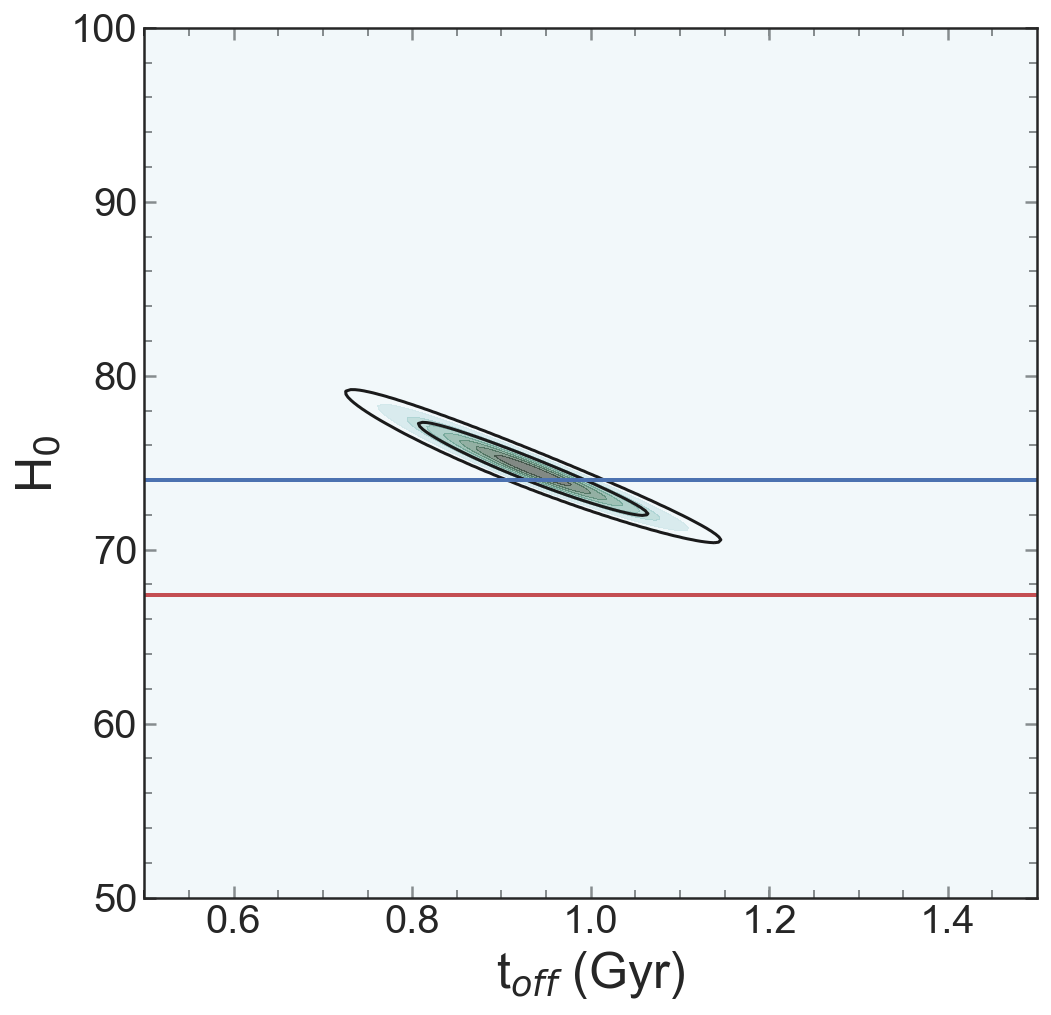

In [121]:
from spec_tools import Likelihood_contours
cmap = sea.cubehelix_palette(12, start=2, rot=.2, dark=0, light=1, as_cmap=True)

PH = []
Poff = []
for i in range(len(P)):
    PH.append(np.trapz(P[i],offset))

P = P / np.trapz(PH,H)
    
for i in range(len(P.T)):
    Poff.append(np.trapz(P.T[i],H))

PH = PH / np.trapz(PH,H)
Poff = Poff / np.trapz(Poff,offset)

onesig,twosig = Likelihood_contours(H,offset,P)
levels = np.array([twosig,onesig])

OO,HH = np.meshgrid(offset,H)

plt.figure(figsize = [8,8])
plt.contour(OO,HH,P, levels,colors='k', linewidth=2)
plt.contourf(OO,HH,P, cmap= cmap, alpha = 0.5)

plt.axhline(67.4, color= 'r', linewidth = 2)
plt.axhline(74.03, linewidth = 2)

plt.xlabel('t$_{off}$ (Gyr)', fontsize=25)
plt.ylabel('H$_0$', fontsize=25)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.savefig('../plots/research_update/twod_like.png', bbox_inches = 'tight')    

(0.72, 2.52)

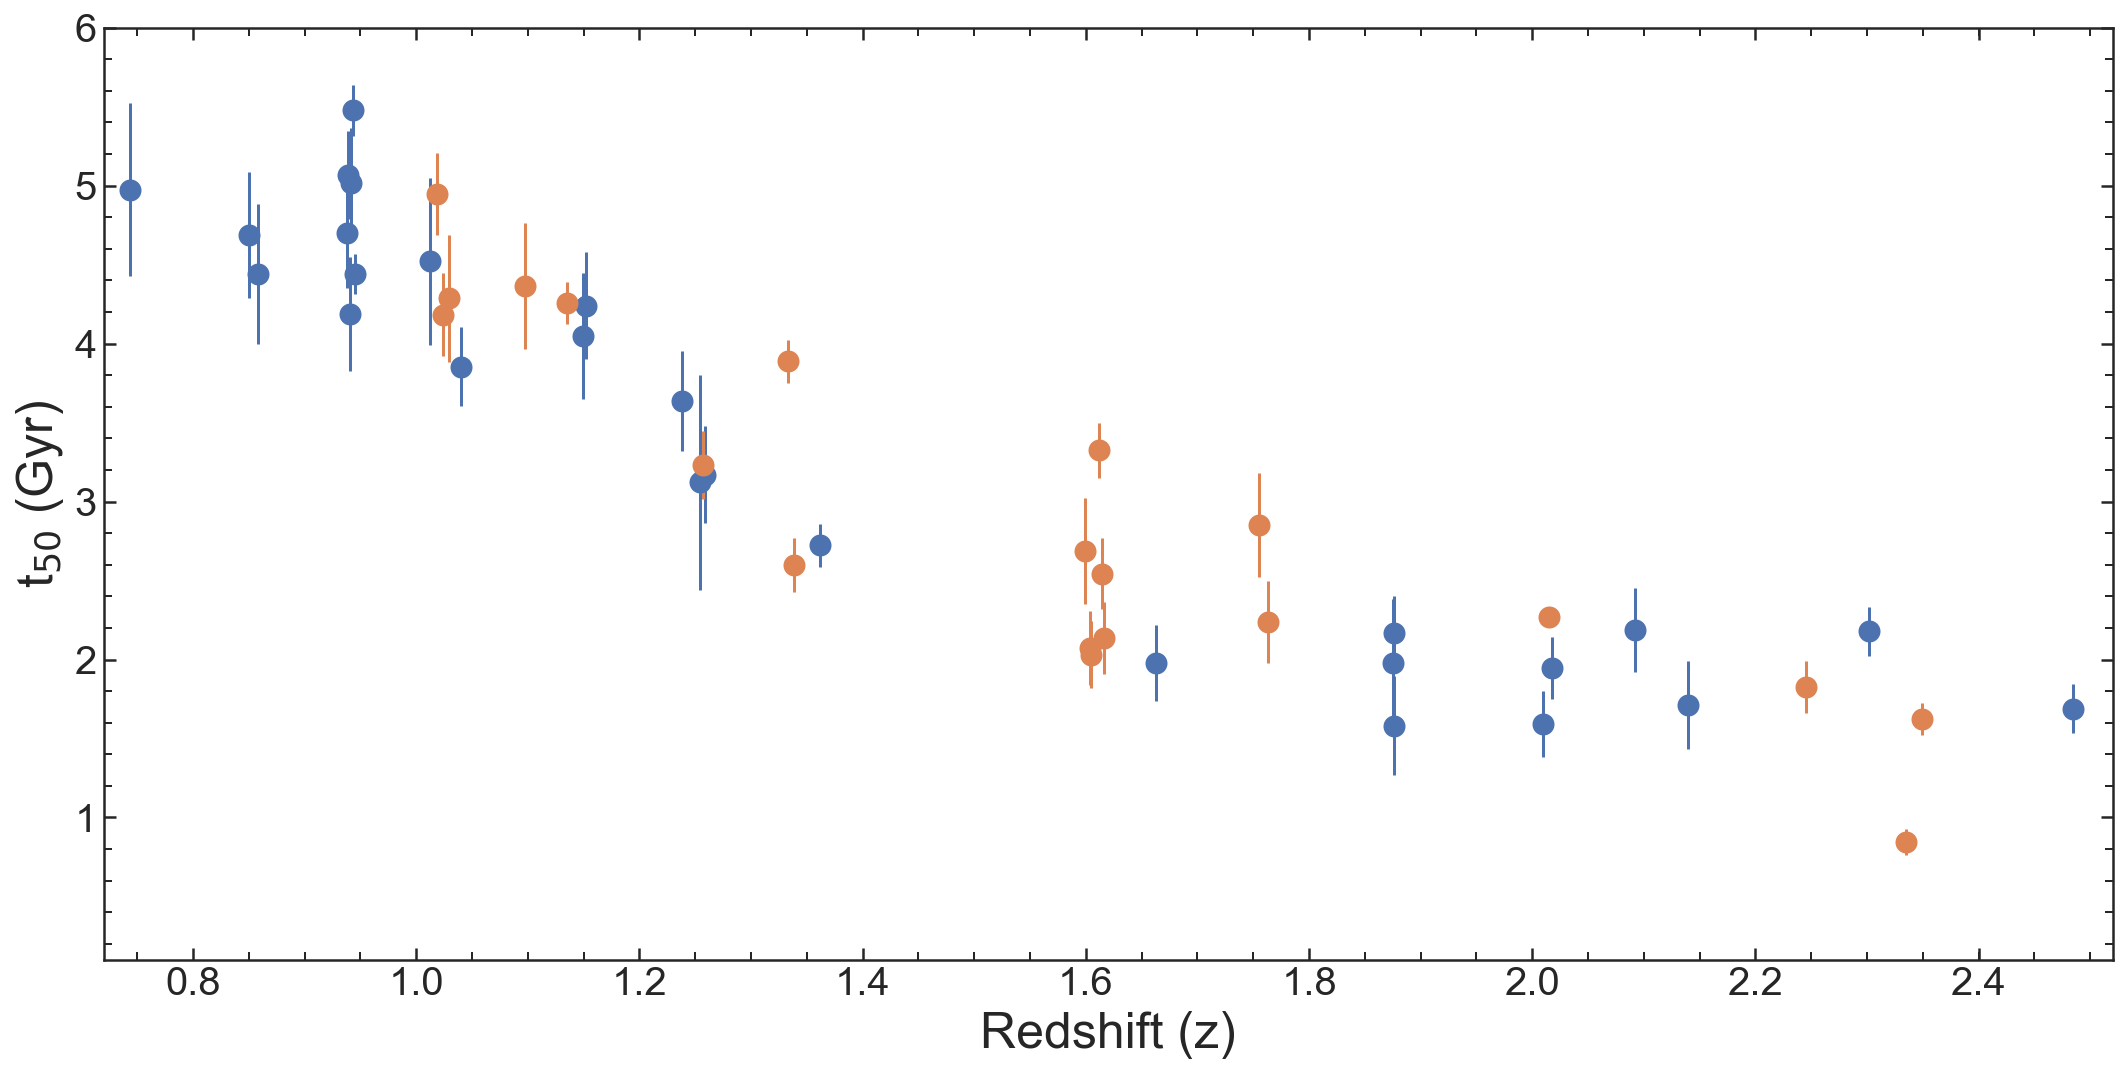

In [373]:
N_rshifts =Adb.query('log_Sigma1 > 10. and z_50 > 3 and sf_prob_2 < 0.2 and field == "GND"').sort_values('zgrism').zgrism.values
N_t50s = Adb.query('log_Sigma1 > 10. and z_50 > 3 and sf_prob_2 < 0.2 and field == "GND"').sort_values('zgrism').t_50.values
N_serr = sym_err(Adb.query('log_Sigma1 > 10. and z_50 > 3 and sf_prob_2 < 0.2 and field == "GND"').sort_values('zgrism'), 't_50')

S_rshifts =Adb.query('log_Sigma1 > 10. and z_50 > 3 and sf_prob_2 < 0.2 and field == "GSD"').sort_values('zgrism').zgrism.values
S_t50s = Adb.query('log_Sigma1 > 10. and z_50 > 3 and sf_prob_2 < 0.2 and field == "GSD"').sort_values('zgrism').t_50.values
S_serr = sym_err(Adb.query('log_Sigma1 > 10. and z_50 > 3 and sf_prob_2 < 0.2 and field == "GSD"').sort_values('zgrism'), 't_50')

plt.figure(figsize = [18,10])
ax1 = plt.subplot(gs[0])
ax1.errorbar(N_rshifts,N_t50s, N_serr, linestyle = 'none', fmt ='o', ms = 10)
ax1.errorbar(S_rshifts,S_t50s, S_serr, linestyle = 'none', fmt ='o', ms = 10)
  


ax1.set_ylim(0.1,6)
ax1.set_xlabel('Redshift (z)', fontsize=25)
ax1.set_ylabel('t$_{50}$ (Gyr)', fontsize=25)
ax1.tick_params(axis='both', which='major', labelsize=20)

ax1.set_xlim(0.72,2.52)



In [375]:
len(N_rshifts),len(S_rshifts)

(27, 20)

In [234]:
H= np.linspace(55,90,200)
offset = np.linspace(0.5,1.5,200)

N_output = np.zeros([len(H), len(offset)])
S_output = np.zeros([len(H), len(offset)])

for i in range(len(H)):
    cosmo = FlatLambdaCDM(H0=H[i], Om0=0.3)
    for ii in range(len(offset)):
        N_output[i][ii] = chi2(N_t50s, cosmo.age(N_rshifts).value - offset[ii], N_serr)
        S_output[i][ii] = chi2(S_t50s, cosmo.age(S_rshifts).value - offset[ii], S_serr)
    

In [239]:
N_P = np.exp(-N_output/2)
S_P = np.exp(-S_output/2)

N_PH = []
N_Poff = []
S_PH = []
S_Poff = []

for i in range(len(P)):
    N_PH.append(np.trapz(N_P[i],offset))
    S_PH.append(np.trapz(S_P[i],offset))

N_P = N_P / np.trapz(N_PH,H)
S_P = S_P / np.trapz(S_PH,H)

    
for i in range(len(P.T)):
    N_Poff.append(np.trapz(N_P.T[i],H))
    S_Poff.append(np.trapz(S_P.T[i],H))

N_PH = N_PH / np.trapz(N_PH,H)
S_PH = S_PH / np.trapz(S_PH,H)


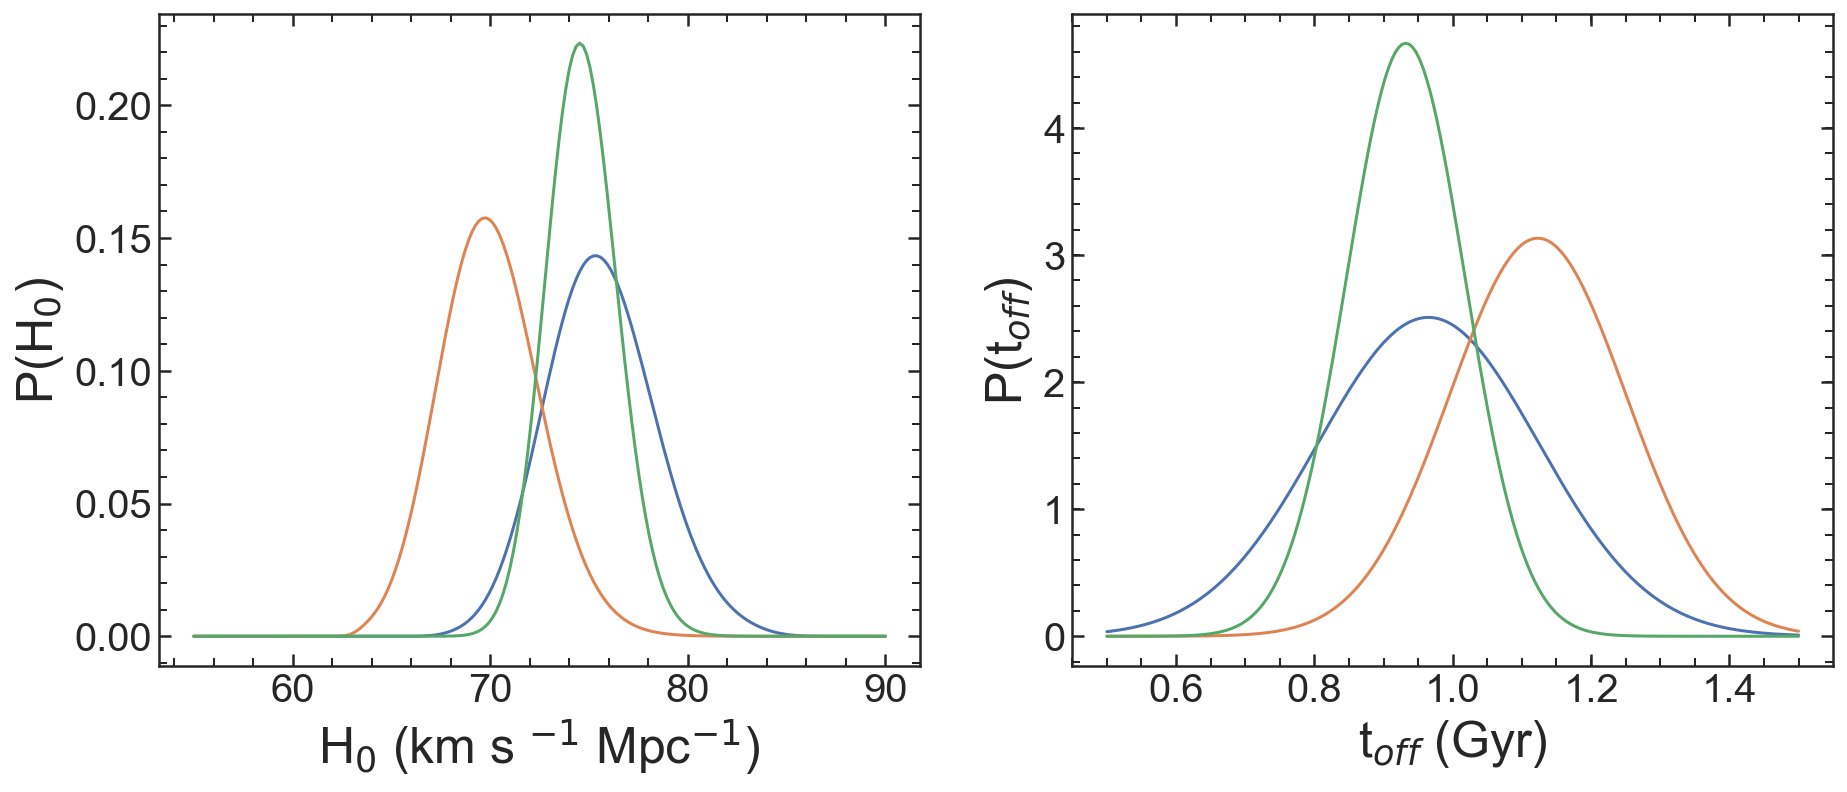

In [242]:
plt.figure(figsize=[15,6])
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)

ax1.plot(H,N_PH)
ax2.plot(offset,N_Poff)

ax1.plot(H,S_PH)
ax2.plot(offset,S_Poff)

ax1.plot(H,PH)
ax2.plot(offset,Poff)

ax1.set_xlabel('H$_0$ (km s $^{-1}$ Mpc$^{-1}$)', fontsize=25)
ax1.set_ylabel('P(H$_0$)', fontsize=25)
ax1.tick_params(axis='both', which='major', labelsize=20)

ax2.set_xlabel('t$_{off}$ (Gyr)', fontsize=25)
ax2.set_ylabel('P(t$_{off}$)', fontsize=25)
ax2.tick_params(axis='both', which='major', labelsize=20)


(0, 350)

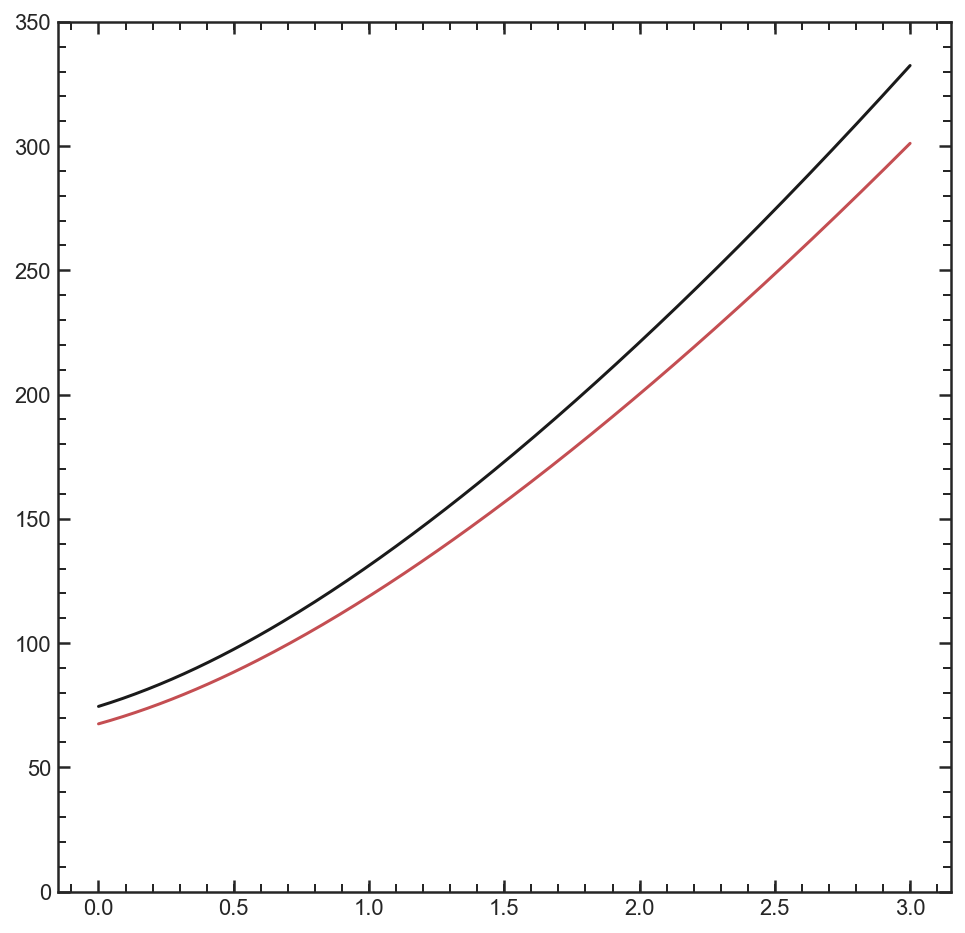

In [251]:
# plt.scatter(adb.query('log_Sigma1 > 10 and z_50 > 3 and sf_prob < 0.2').zgrism,
#             adb.query('log_Sigma1 > 10 and z_50 > 3 and sf_prob < 0.2').t_50)

plt.figure(figsize=[8,8])

zs = np.linspace(0., 3, 200)
cosmo = FlatLambdaCDM(H0=67.5, Om0=0.3)
plt.plot(zs, cosmo.H(zs).value, color = 'r')
cosmo = FlatLambdaCDM(H0=74.52, Om0=0.3)
plt.plot(zs, cosmo.H(zs).value, color = 'k')
plt.ylim(0,350)

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


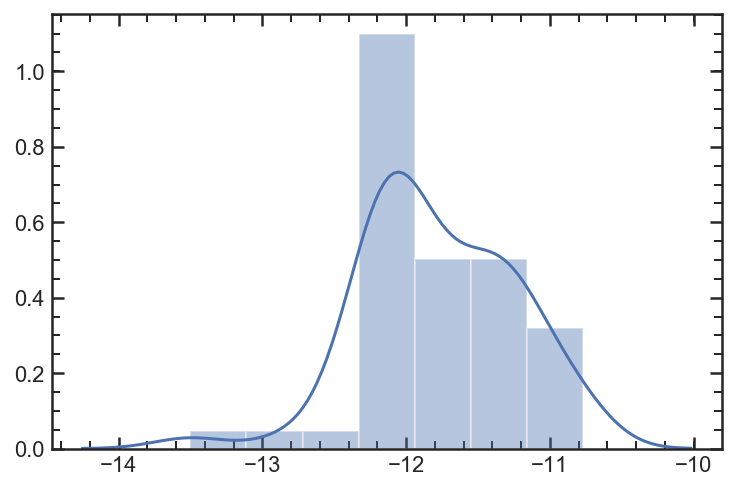

In [78]:
all_rshifts =adb.query('log_Sigma1 > 10. and z_50 > 3  and zgrism < 2.5 and sf_prob < 0.2').sort_values('zgrism').zgrism.values
all_t50s = adb.query('log_Sigma1 > 10. and z_50 > 3  and zgrism < 2.5 and sf_prob < 0.2').sort_values('zgrism').t_50.values
all_serr = sym_err(adb.query('log_Sigma1 > 10. and z_50 > 3 and zgrism < 2.5 and sf_prob < 0.2').sort_values('zgrism'), 't_50')

# Nall_rshifts =adb.query('log_Sigma1 > 10. and z_50 > 3 and sf_prob < 0.2 and field == "GND"').sort_values('zgrism').zgrism.values
# Nall_t50s = adb.query('log_Sigma1 > 10. and z_50 > 3 and sf_prob < 0.2 and field == "GND"').sort_values('zgrism').t_50.values
# Nall_serr = sym_err(adb.query('log_Sigma1 > 10. and z_50 > 3 and sf_prob < 0.2 and field == "GND"').sort_values('zgrism'), 't_50')

# Sall_rshifts =adb.query('log_Sigma1 > 10. and z_50 > 3 and sf_prob < 0.2 and field == "GSD"').sort_values('zgrism').zgrism.values
# Sall_t50s = adb.query('log_Sigma1 > 10. and z_50 > 3 and sf_prob < 0.2 and field == "GSD"').sort_values('zgrism').t_50.values
# Sall_serr = sym_err(adb.query('log_Sigma1 > 10. and z_50 > 3 and sf_prob < 0.2 and field == "GSD"').sort_values('zgrism'), 't_50')

sea.distplot(adb.query('log_Sigma1 > 10. and z_50 > 3 and sf_prob < 0.2').sort_values('zgrism').log_ssfr.values)

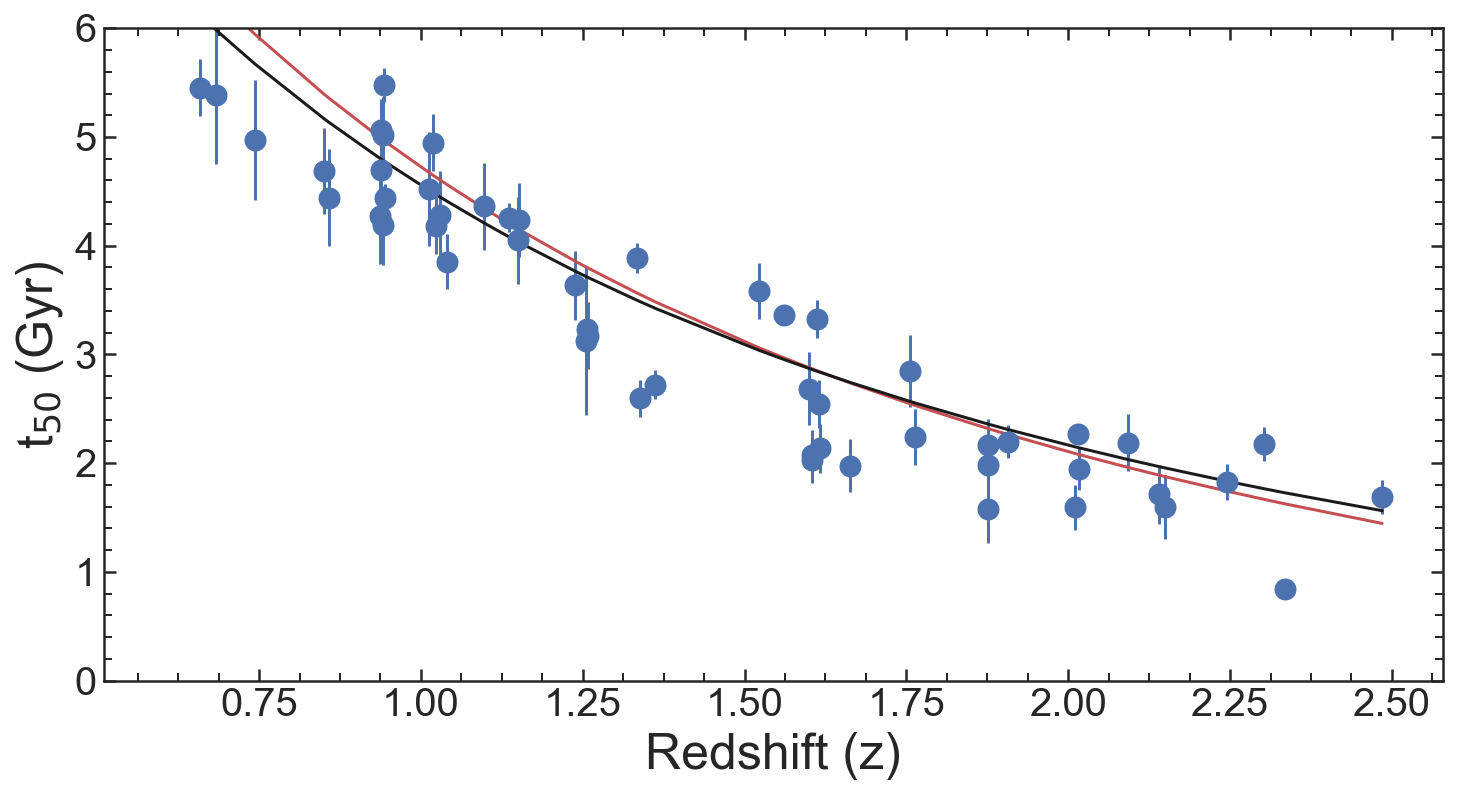

In [87]:
plt.figure(figsize = [12,6])
ax1 = plt.subplot()
ax1.errorbar(all_rshifts,all_t50s, all_serr, linestyle = 'none', fmt ='o', ms = 10)

ax1.set_ylim(0,6)
ax1.set_xlabel('Redshift (z)', fontsize=25)
ax1.set_ylabel('t$_{50}$ (Gyr)', fontsize=25)
ax1.tick_params(axis='both', which='major', labelsize=20)


cosmo = FlatLambdaCDM(H0=67.5, Om0=0.3)

ax1.plot(all_rshifts, cosmo.age(all_rshifts).value - 1.24, color = 'r')

cosmo = FlatLambdaCDM(H0=73.91, Om0=0.3)
ax1.plot(all_rshifts, cosmo.age(all_rshifts).value -  0.89, color = 'k')

In [128]:
offset = np.linspace(0.5,1.5,200)

Loutput = np.zeros([len(H), len(offset)])

for i in range(len(iA)):
    for ii in range(len(offset)):
        Loutput[i][ii] = chi2(lwas, iA[i](rshifts) - offset[ii], lerr)

In [129]:
P = np.exp(-Loutput/2)

PH = []
Poff = []
for i in range(len(P)):
    PH.append(np.trapz(P[i],offset))

for i in range(len(P.T)):
    Poff.append(np.trapz(P.T[i],H))

PH = PH / np.trapz(PH,H)
Poff = Poff / np.trapz(Poff,offset)

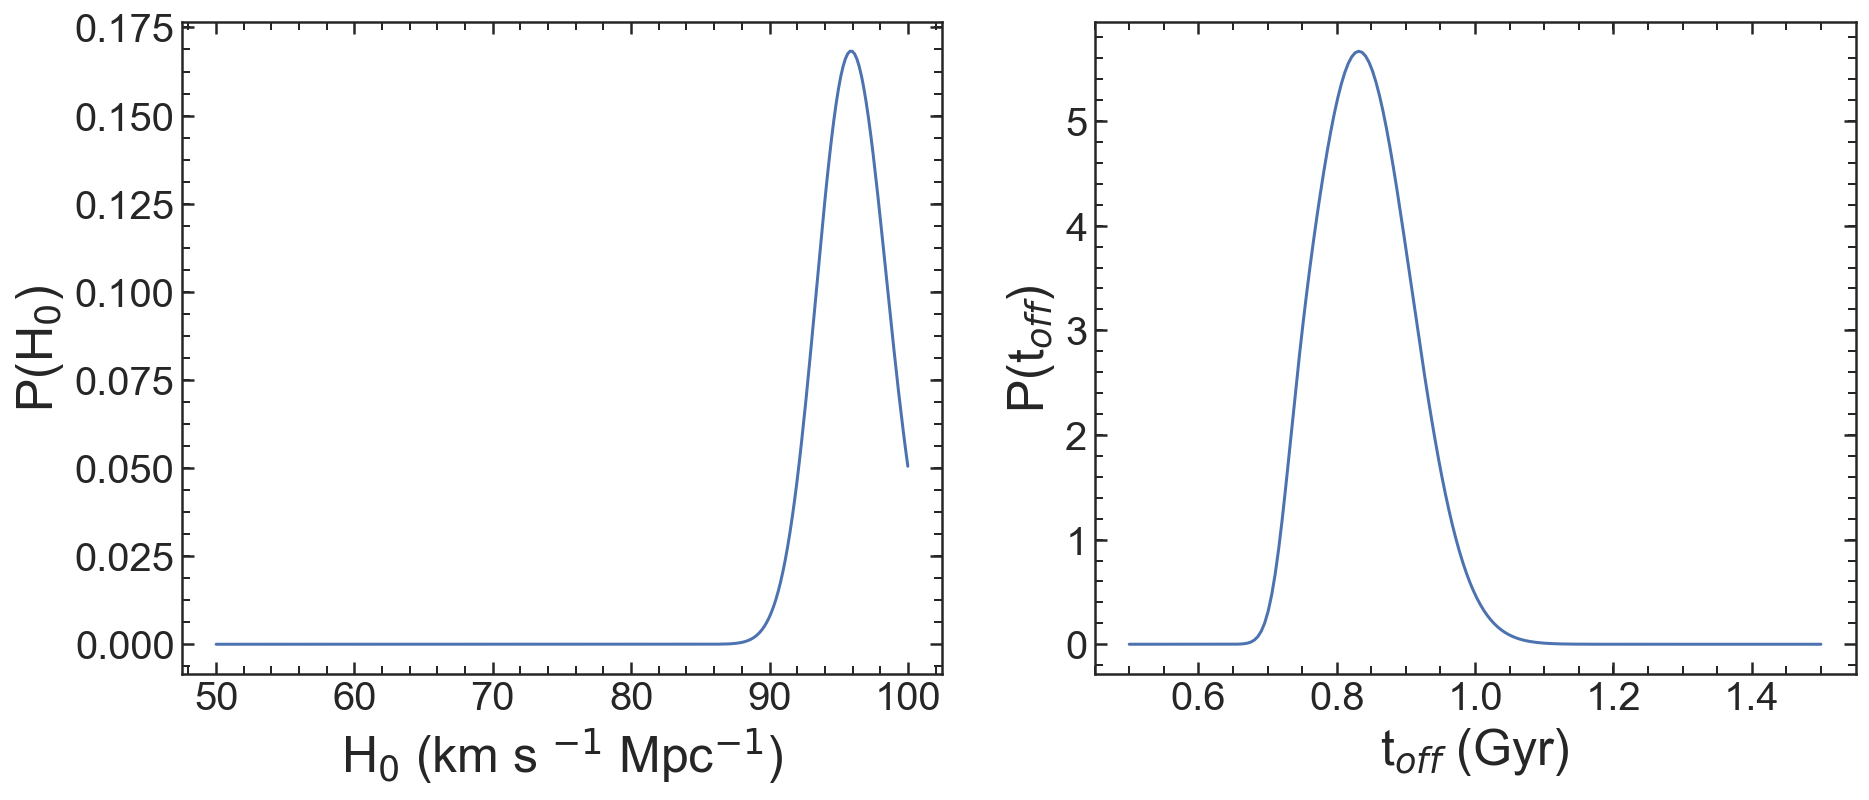

In [130]:
plt.figure(figsize=[15,6])
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)

ax1.plot(H,PH)
ax2.plot(offset,Poff)

ax1.set_xlabel('H$_0$ (km s $^{-1}$ Mpc$^{-1}$)', fontsize=25)
ax1.set_ylabel('P(H$_0$)', fontsize=25)
ax1.tick_params(axis='both', which='major', labelsize=20)

ax2.set_xlabel('t$_{off}$ (Gyr)', fontsize=25)
ax2.set_ylabel('P(t$_{off}$)', fontsize=25)
ax2.tick_params(axis='both', which='major', labelsize=20)

In [131]:
m,hdr,mod = Highest_density_region(PH,H)
print(np.round(m,2),np.round((hdr[1] - hdr[0])/2,2))

m,hdr,mod = Highest_density_region(Poff,offset)
print(np.round(m,2),np.round((hdr[1] - hdr[0])/2,2))

95.82 2.26
0.83 0.07


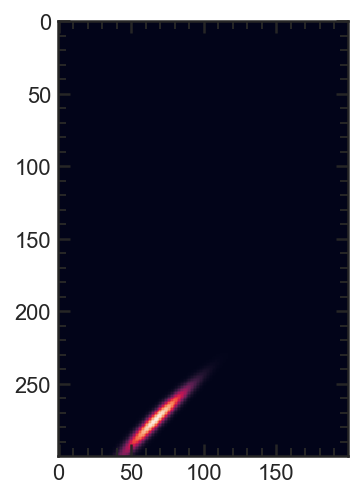

In [132]:
plt.imshow(np.exp(-Loutput/2))

In [84]:
output2 = np.zeros(len(offset))
cosmo = FlatLambdaCDM(H0=67.4, Om0=0.3)

for ii in range(len(offset)):
    output2[ii] = chi2(all_t50s, cosmo.age(all_rshifts).value - offset[ii], all_serr)

(1.2386934673366834, [1.2185929648241207, 1.2587939698492463], array([0.]))
1.24 0.02


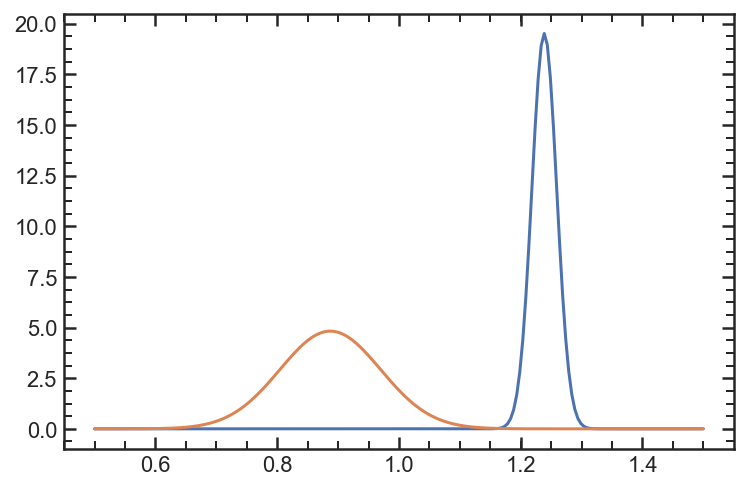

In [85]:
plt.plot(offset, np.exp(-output2/2)/np.trapz(np.exp(-output2/2), offset))
plt.plot(offset,Poff)

print(Highest_density_region(np.exp(-output2/2)/np.trapz(np.exp(-output2/2), offset), offset))
m,hdr,mod = Highest_density_region(np.exp(-output2/2)/np.trapz(np.exp(-output2/2), offset), offset)
print(np.round(m,2),np.round((hdr[1] - hdr[0])/2,2))

In [75]:
its = 1000
IDX = np.arange(len(t50s))
offset = np.linspace(0,3,300)

PH_grid = []
Poff_grid = []
plt.figure(figsize = [8,5])

while len(PH_grid) < its:
    bssamp = np.random.choice(IDX,len(IDX))
    BSt50s = t50s[bssamp]
    BSrshifts = rshifts[bssamp]
    BSserr = np.array(serr)[bssamp]    
    
    output = np.zeros([len(H), len(offset)])

    for i in range(len(H)):
        for ii in range(len(offset)):
            output[i][ii] = chi2(BSt50s, iA[i](BSrshifts) - offset[ii], BSserr)
    
    P = np.exp(-output/2)

    PH = []
    Poff = []
    for i in range(len(P)):
        PH.append(np.trapz(P[i],offset))

    for i in range(len(P.T)):
        Poff.append(np.trapz(P.T[i],H))

    PH = PH / np.trapz(PH,H)
    Poff = Poff / np.trapz(Poff,offset)
    mH,hdr,mod = Highest_density_region(PH, H)
    moff,hdr,mod = Highest_density_region(Poff, offset)    
    cosmo = FlatLambdaCDM(H0=mH, Om0=0.3)

    use = True  
    for i in range(len(BSt50s)):
        if BSt50s[i] > cosmo.age(BSrshifts[i]).value:
            use = False
    
    if use:
        PH_grid.append(PH)
        Poff_grid.append(Poff)    

<Figure size 576x360 with 0 Axes>

In [76]:
from spec_stats import Iterative_stacking

In [77]:
ST,wei=Iterative_stacking(PH_grid,H,)
ST2,wei2=Iterative_stacking(Poff_grid,offset)

/Users/Vince.ec/GitHub/Cluster_and_field/scripts/spec_stats.py:196: RuntimeWarning: divide by zero encountered in log10
  rto = int(np.abs(min(np.log10(x_o)[np.abs(np.log10(x_o)) != np.inf])))+1


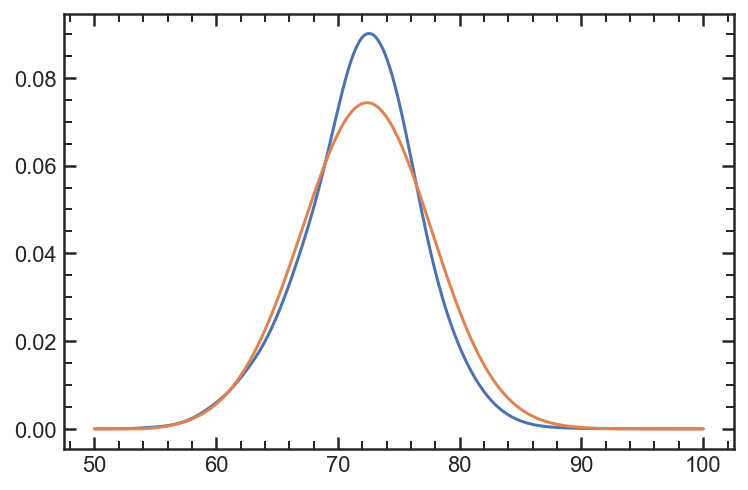

In [78]:
plt.plot(H,wei)
plt.plot(H,ST)

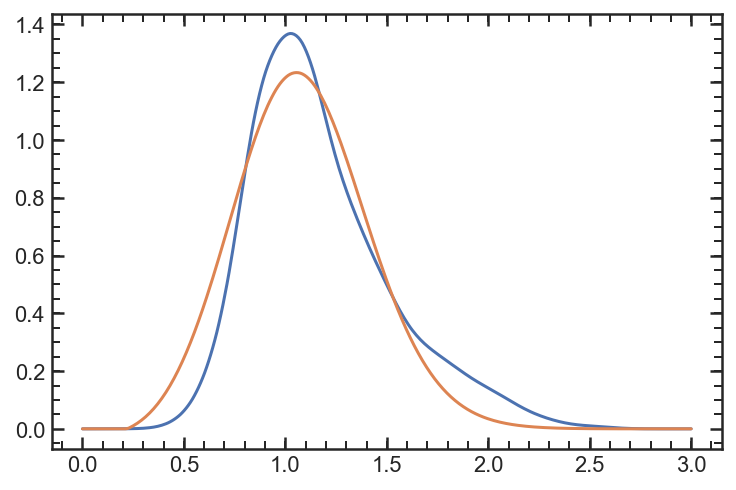

In [79]:
plt.plot(offset,wei2)
plt.plot(offset,ST2)

In [80]:
m,hdr,mod = Highest_density_region(ST,H)
print(np.round(m,2),np.round((hdr[1] - hdr[0])/2,2))

m,hdr,mod = Highest_density_region(ST2,offset)
print(np.round(m,2),np.round((hdr[1] - hdr[0])/2,2))

72.41 5.35
1.05 0.32


In [49]:
for i in range(len(PH_grid)):
    mH,hdr,mod = Highest_density_region(PH_grid[i], H)
    moff,hdr,mod = Highest_density_region(Poff_grid[i], offset) 
    print(mH, moff)
    break

67.72575250836121 1.4648829431438128


(0.72, 2.52)

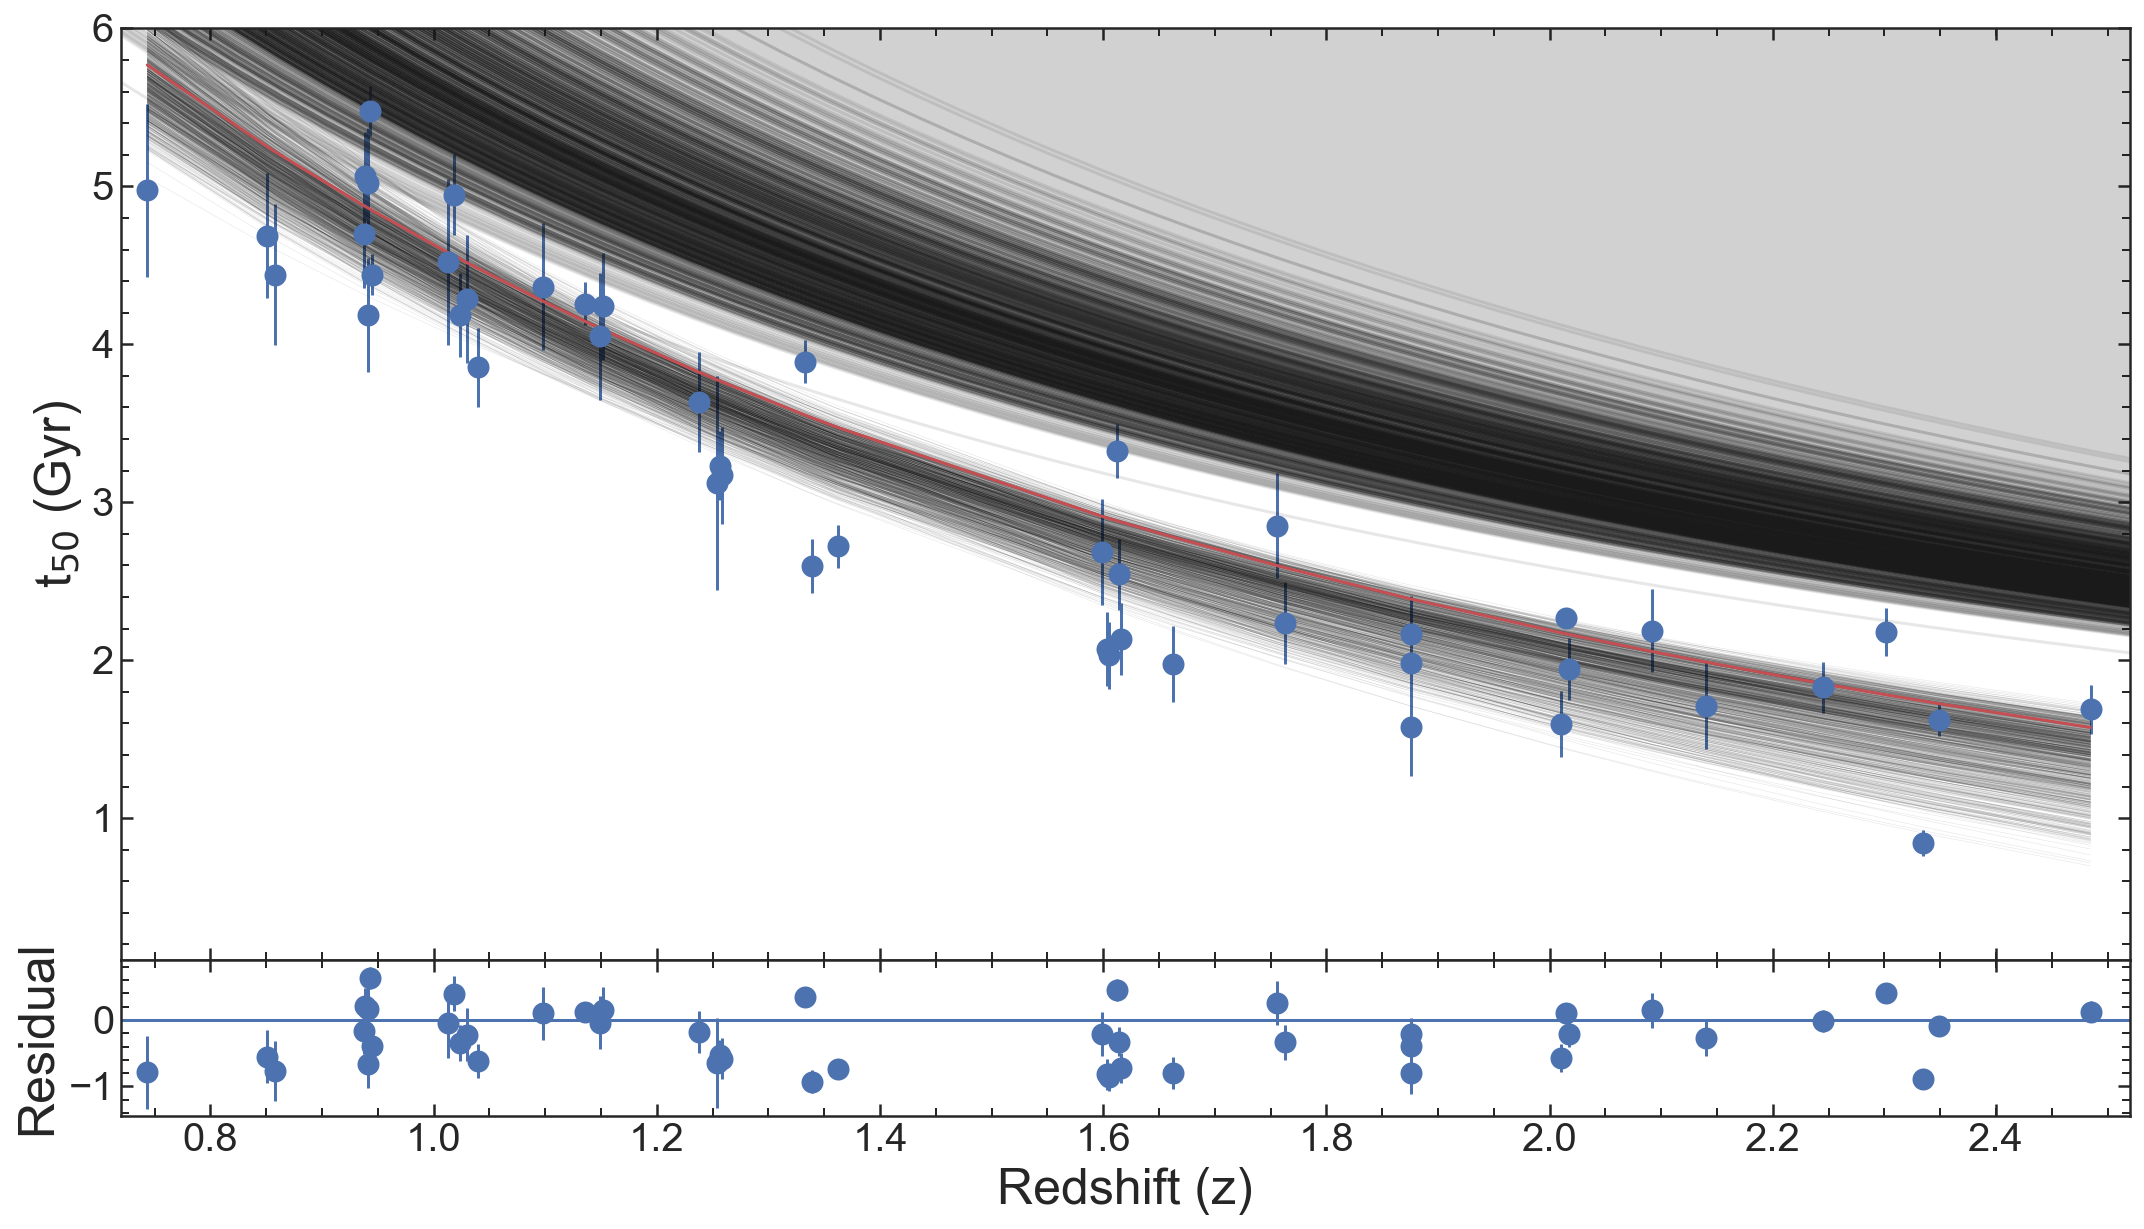

In [82]:
cosmo = FlatLambdaCDM(H0=72.41, Om0=0.3)

gs = gridspec.GridSpec(2,1,height_ratios=[6,1], hspace=0)

plt.figure(figsize = [18,10])
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])
ax1.errorbar(rshifts,t50s, serr, linestyle = 'none', fmt ='o', ms = 10)

for i in range(len(PH_grid)):
    mH,hdr,mod = Highest_density_region(PH_grid[i], H)
    moff,hdr,mod = Highest_density_region(Poff_grid[i], offset)    
    cosmo = FlatLambdaCDM(H0=mH, Om0=0.3)

    ax1.plot(rshifts, cosmo.age(rshifts).value - moff, color = 'k', alpha = 0.1, linewidth = 0.3)
    ax1.plot(np.linspace(0.7,2.7), cosmo.age(np.linspace(0.7,2.7)).value, np.repeat(8,50), color = 'k', alpha = 0.1)

    
    
cosmo = FlatLambdaCDM(H0=72.41, Om0=0.3)
   
ax1.plot(rshifts, cosmo.age(rshifts).value - 0.93, color = 'r')
ax1.fill_between(np.linspace(0.7,2.7), cosmo.age(np.linspace(0.7,2.7)).value, np.repeat(8,50), color = 'k', alpha = 0.2)

ax2.errorbar(rshifts,t50s - (cosmo.age(rshifts).value - 0.94), serr, linestyle = 'none', fmt ='o', ms = 10)
ax2.axhline(0)

ax1.set_ylim(0.1,6)
ax2.set_xlabel('Redshift (z)', fontsize=25)
ax1.set_ylabel('t$_{50}$ (Gyr)', fontsize=25)
ax2.set_ylabel('Residual', fontsize=25)
ax1.tick_params(axis='both', which='major', labelsize=20)
ax2.tick_params(axis='both', which='major', labelsize=20)

ax1.set_xlim(0.72,2.52)
ax2.set_xlim(0.72,2.52)

# plt.savefig('../plots/research_update/chronometer_3.png', bbox_inches = 'tight')   

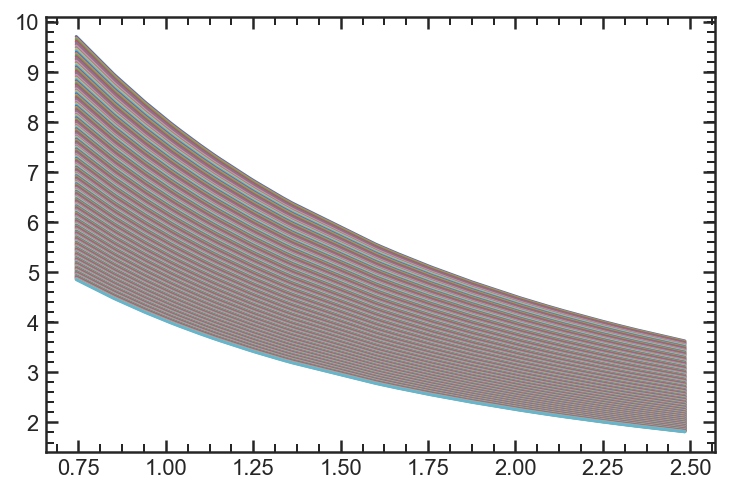

In [99]:
output = np.zeros(len(H))

for i in range(len(H)):
    sc = Scale_model(t50s, np.array(serr), iA[i](rshifts))
    output[i] = chi2(t50s, iA[i](rshifts)*sc, serr)
    plt.plot(rshifts,iA[i](rshifts))



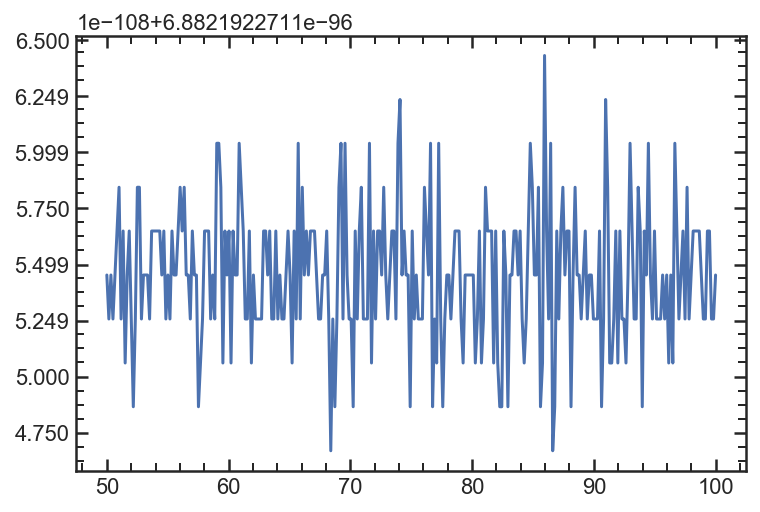

In [96]:
plt.plot(H, np.exp(-output/2))

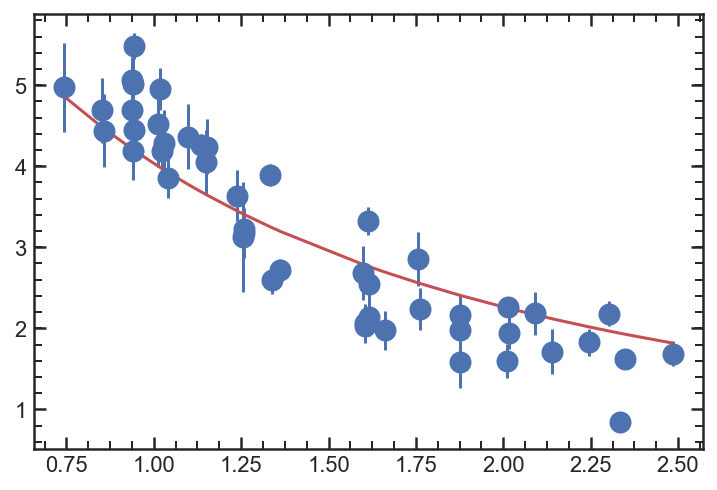

In [92]:
sc = Scale_model(t50s, np.array(serr), iA[50](rshifts))
plt.errorbar(rshifts,t50s, serr, linestyle = 'none', fmt ='o', ms = 10)
  
plt.plot(rshifts, iA[50](rshifts)*sc, color = 'r')
#     output[i] = chi2(t50s, iA[50](rshifts)*sc, serr)

In [88]:
Hdb =Adb.query('log_Sigma1 > 10. and z_50 > 3 and sf_prob_2 < 0.2').sort_values('zgrism')


In [89]:
hmass = []
sfr = []

for i in Hdb.index:

    try:
        lbt, sfh = np.load('../data/SFH/{0}_{1}.npy'.format(Hdb.field[i], Hdb.id[i]))

    except:
        try:
            with open('../data/SFH/{}_{}.pkl'.format(Hdb.field[i], Hdb.id[i]), 'rb') as sfh_file:
                sfh = pickle.load(sfh_file)
            lbt = sfh.LBT 
            sfh = sfh.SFH 

        except:
            with open('../data/SFH/{}_{}_1D.pkl'.format(Hdb.field[i], Hdb.id[i]), 'rb') as sfh_file:
                sfh = pickle.load(sfh_file)
            lbt = sfh.LBT 
            sfh = sfh.SFH  

    sfr_range = np.linspace(Hdb.t_50[i]-.05,Hdb.t_50[i]+.05,100)
    isfh = interp1d(lbt,sfh)(sfr_range)
    sfr.append(np.mean(isfh))
    hmass.append(Hdb.lmass[i] - np.log10(2))

In [90]:
def S_fit(A, B, M):
    return A*(M - 10.5) + B

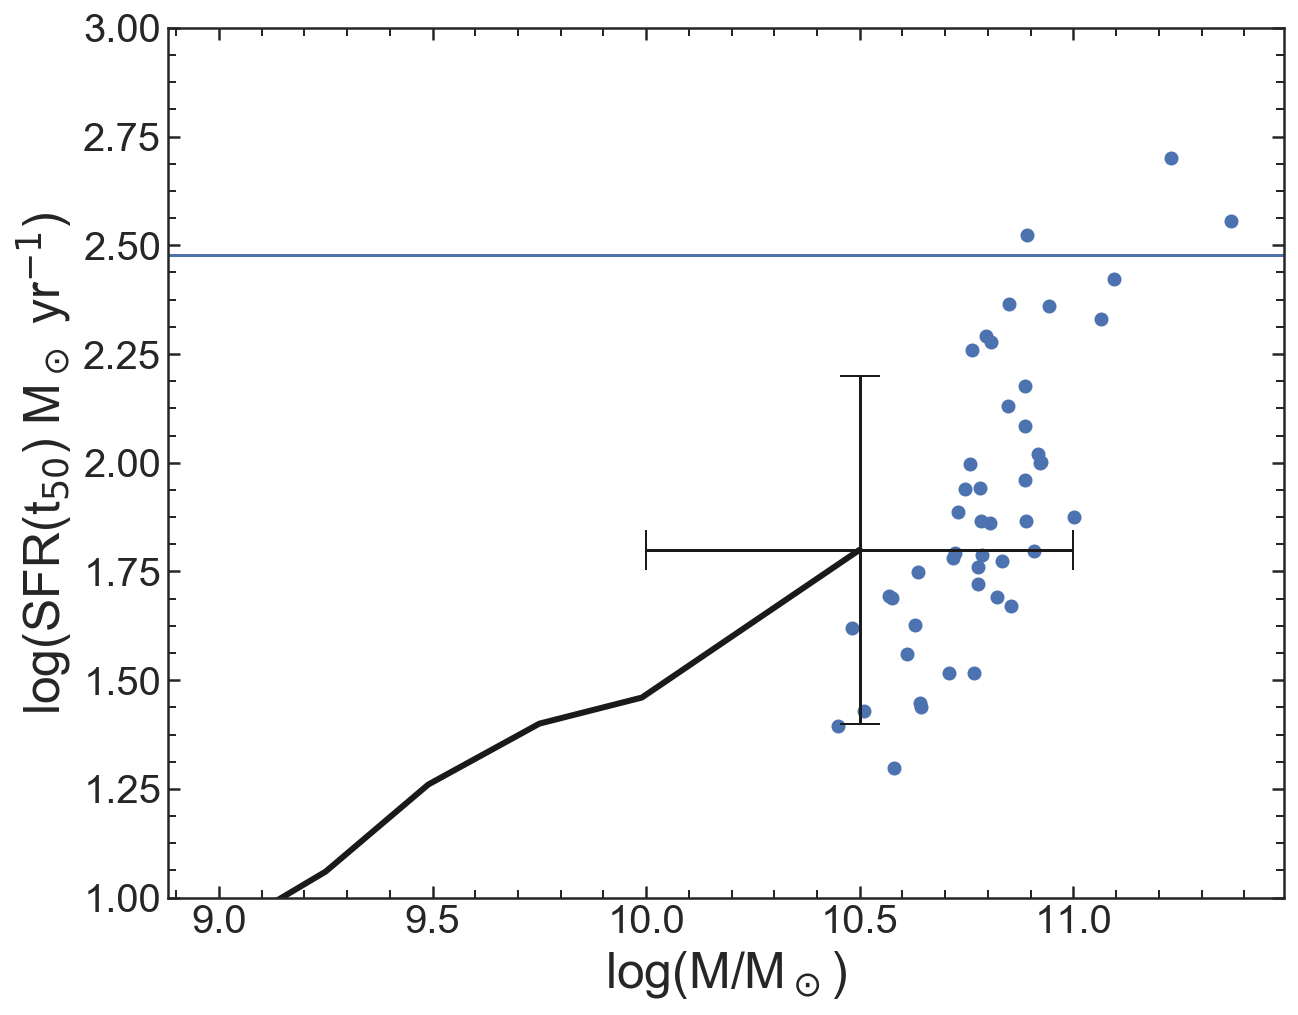

In [154]:
plt.figure(figsize=[10,8])
plt.scatter(hmass, np.log10(sfr))
plt.axhline(np.log10(300))

XA = [9.00,9.25,9.49,9.75,9.99, 10.5]
YA = [0.914,1.06,1.26,1.40,1.46, 1.8]




Y = [1.8,2.15,1.44,1.8,1.8]

X = [10.5,10.5,10.5,10.1,11.0]

plt.plot(XA,YA, linewidth = 3, color = 'k')

plt.errorbar([10.5], [1.8], xerr = [np.array([0.5,0.5])], yerr = [np.array([0.4, 0.4])], color = 'k', capsize = 10)
plt.xlabel('log(M/M$_\odot$)', fontsize=25)
plt.ylabel('log(SFR(t$_{50}$) M$_\odot$ yr$^{-1}$)', fontsize=25)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.ylim(1,3)
plt.savefig('../plots/research_update/chronometer_SFR.png', bbox_inches = 'tight')   

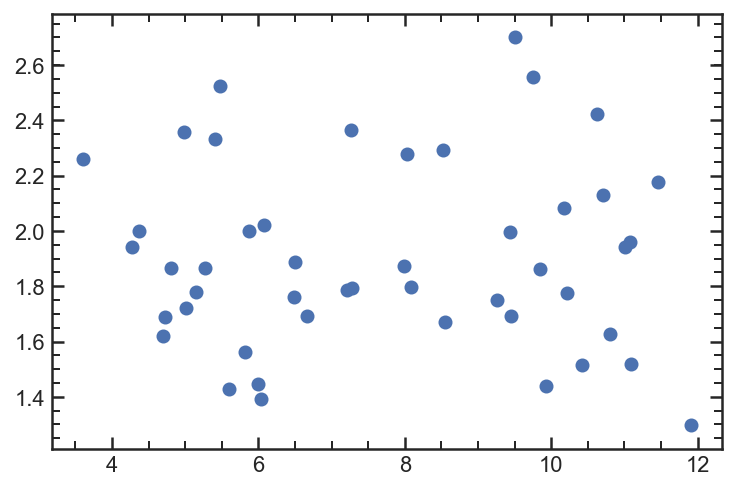

In [127]:
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
plt.scatter(cosmo.age(Hdb.zgrism.values).value + Hdb.t_50, np.log10(sfr))

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/pandas/core/series.py:856: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


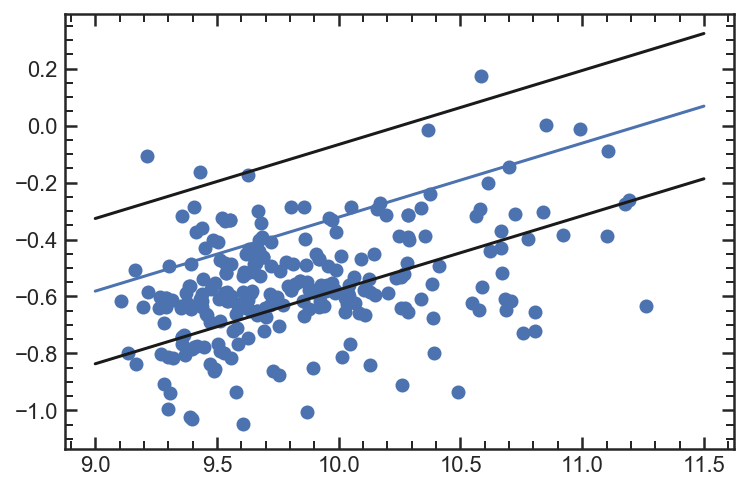

In [142]:
def Z_prior_mu(lmass):
    M = [9, 11.5]
    P = [-0.5813, 0.06818]
    iP = interp1d(M,P)
    return iP(lmass) 
Cdb = pd.read_pickle('../dataframes/fitdb/emission_line_galaxies.pkl')
onesig = (0.04 + 0.47)/2

M  = np.linspace(9,11.5)

plt.plot(M, Z_prior_mu(M))
plt.plot(M, Z_prior_mu(M) + onesig,'k')
plt.plot(M, Z_prior_mu(M) - onesig,'k')

plt.scatter(Cdb.lmass, np.log10(Cdb.Z))

# m = 10**Gaussian_prior(u[0], [mllim, mhlim], Z_prior_mu(logmass), onesig)

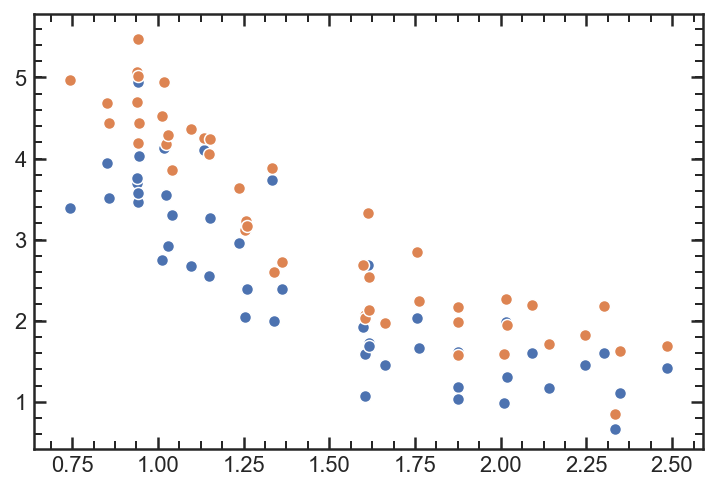

In [126]:
sea.scatterplot(rshifts, lwas)
sea.scatterplot(rshifts, t50s)

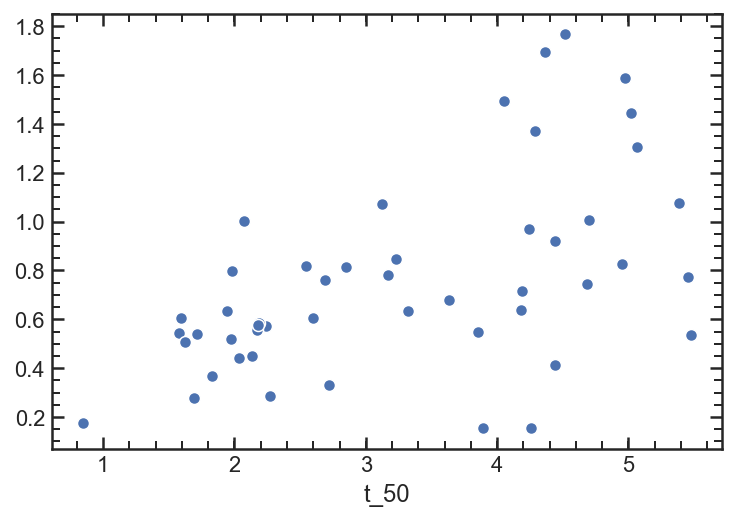

In [379]:
sea.scatterplot(Hdb.t_50, Hdb.t_50 - Hdb.lwa)


In [371]:
Hdb =Adb.query('log_Sigma1 > 10. and z_50 > 3 and sf_prob_2 < 0.2').sort_values('zgrism')

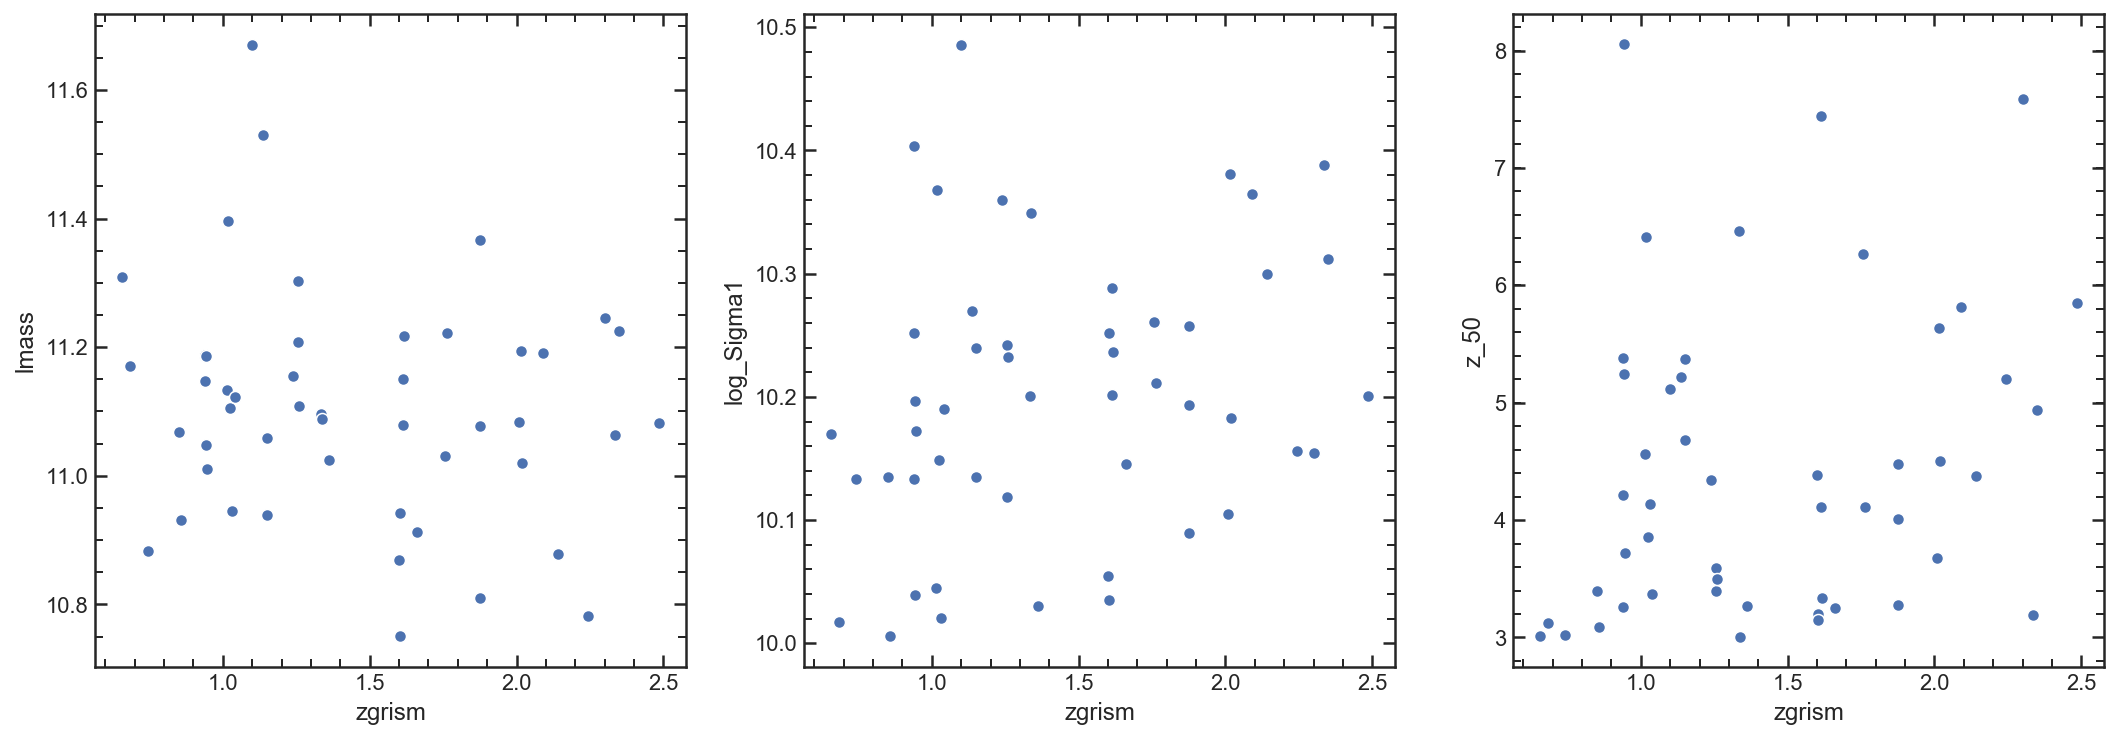

In [377]:
gs = gridspec.GridSpec(1,3)
plt.figure(figsize=[18,6])

ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])
ax3 = plt.subplot(gs[2])

sea.scatterplot(Hdb.zgrism, Hdb.lmass ,ax = ax1)
sea.scatterplot(Hdb.zgrism, Hdb.log_Sigma1 ,ax = ax2)
sea.scatterplot(Hdb.zgrism, Hdb.z_50 ,ax = ax3)

In [2]:
pdb = pd.read_pickle('../dataframes/fitdb/simfits.pkl')

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


-0.029844518619786986
0.0709583172992441
0.04188917260634926


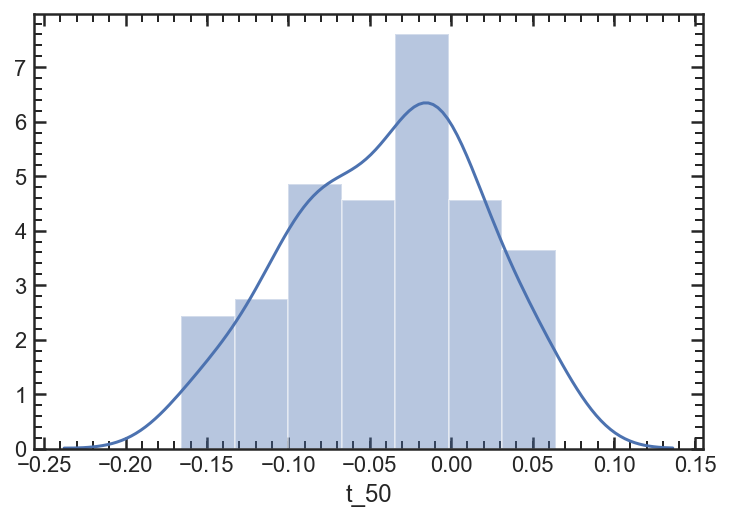

In [3]:
sea.distplot((pdb.t_50-4.69)/4.69)

print(np.percentile((pdb.t_50-4.69)/4.69,50))
print(np.percentile((pdb.t_50-4.69)/4.69,50) - np.percentile((pdb.t_50-4.69)/4.69,16))
print(np.percentile((pdb.t_50-4.69)/4.69,84) - np.percentile((pdb.t_50-4.69)/4.69,50))

In [5]:
Adb.query('id == 39170').t_90

148    4.408656
Name: t_90, dtype: float64

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


-0.31746355492529327
0.011721076173524747
0.1357641318249628


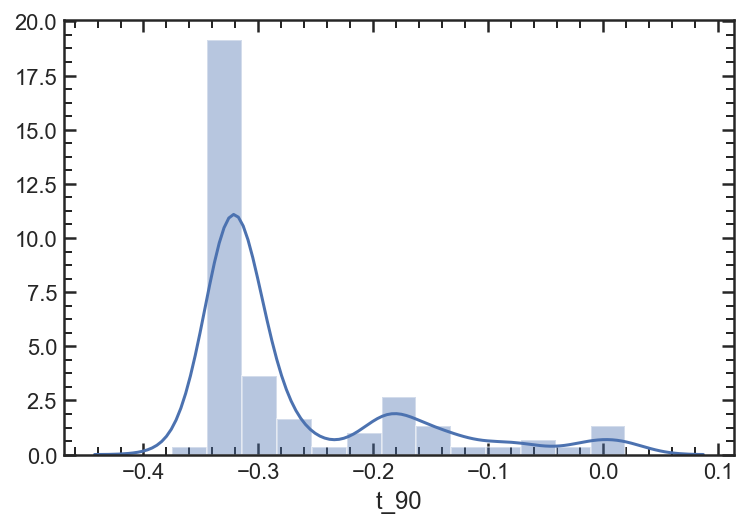

In [6]:
sea.distplot((pdb.t_90-4.41)/4.41)

print(np.percentile((pdb.t_90-4.41)/4.41,50))
print(np.percentile((pdb.t_90-4.41)/4.41,50) - np.percentile((pdb.t_90-4.41)/4.41,16))
print(np.percentile((pdb.t_90-4.41)/4.41,84) - np.percentile((pdb.t_90-4.41)/4.41,50))

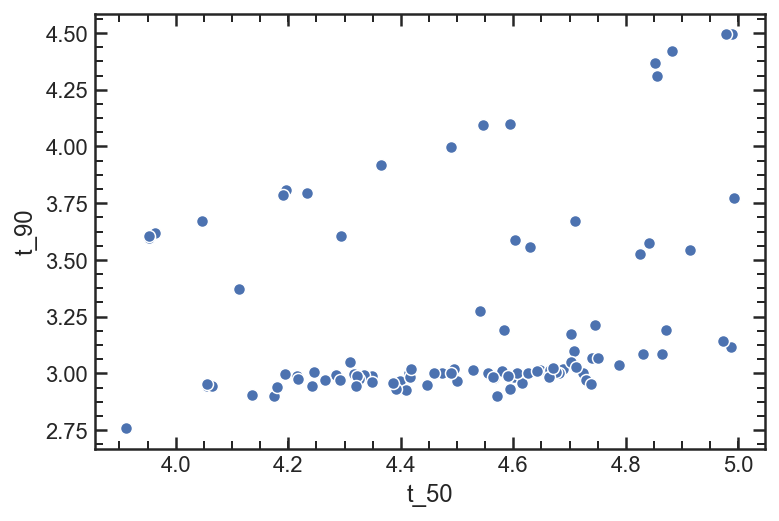

In [8]:
sea.scatterplot(pdb.t_50,pdb.t_90)


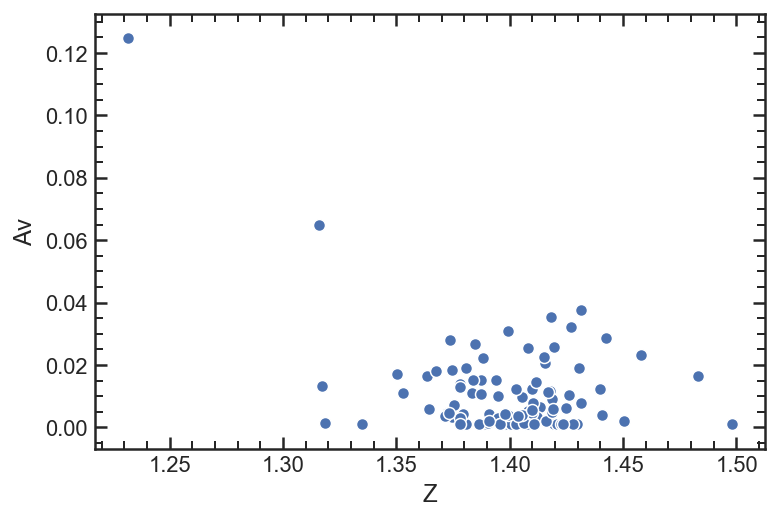

In [876]:
sea.scatterplot(pdb.Z, pdb.Av)

Text(0,0.5,'t$_50$ - t(H$_0$, t$_{off}$)')

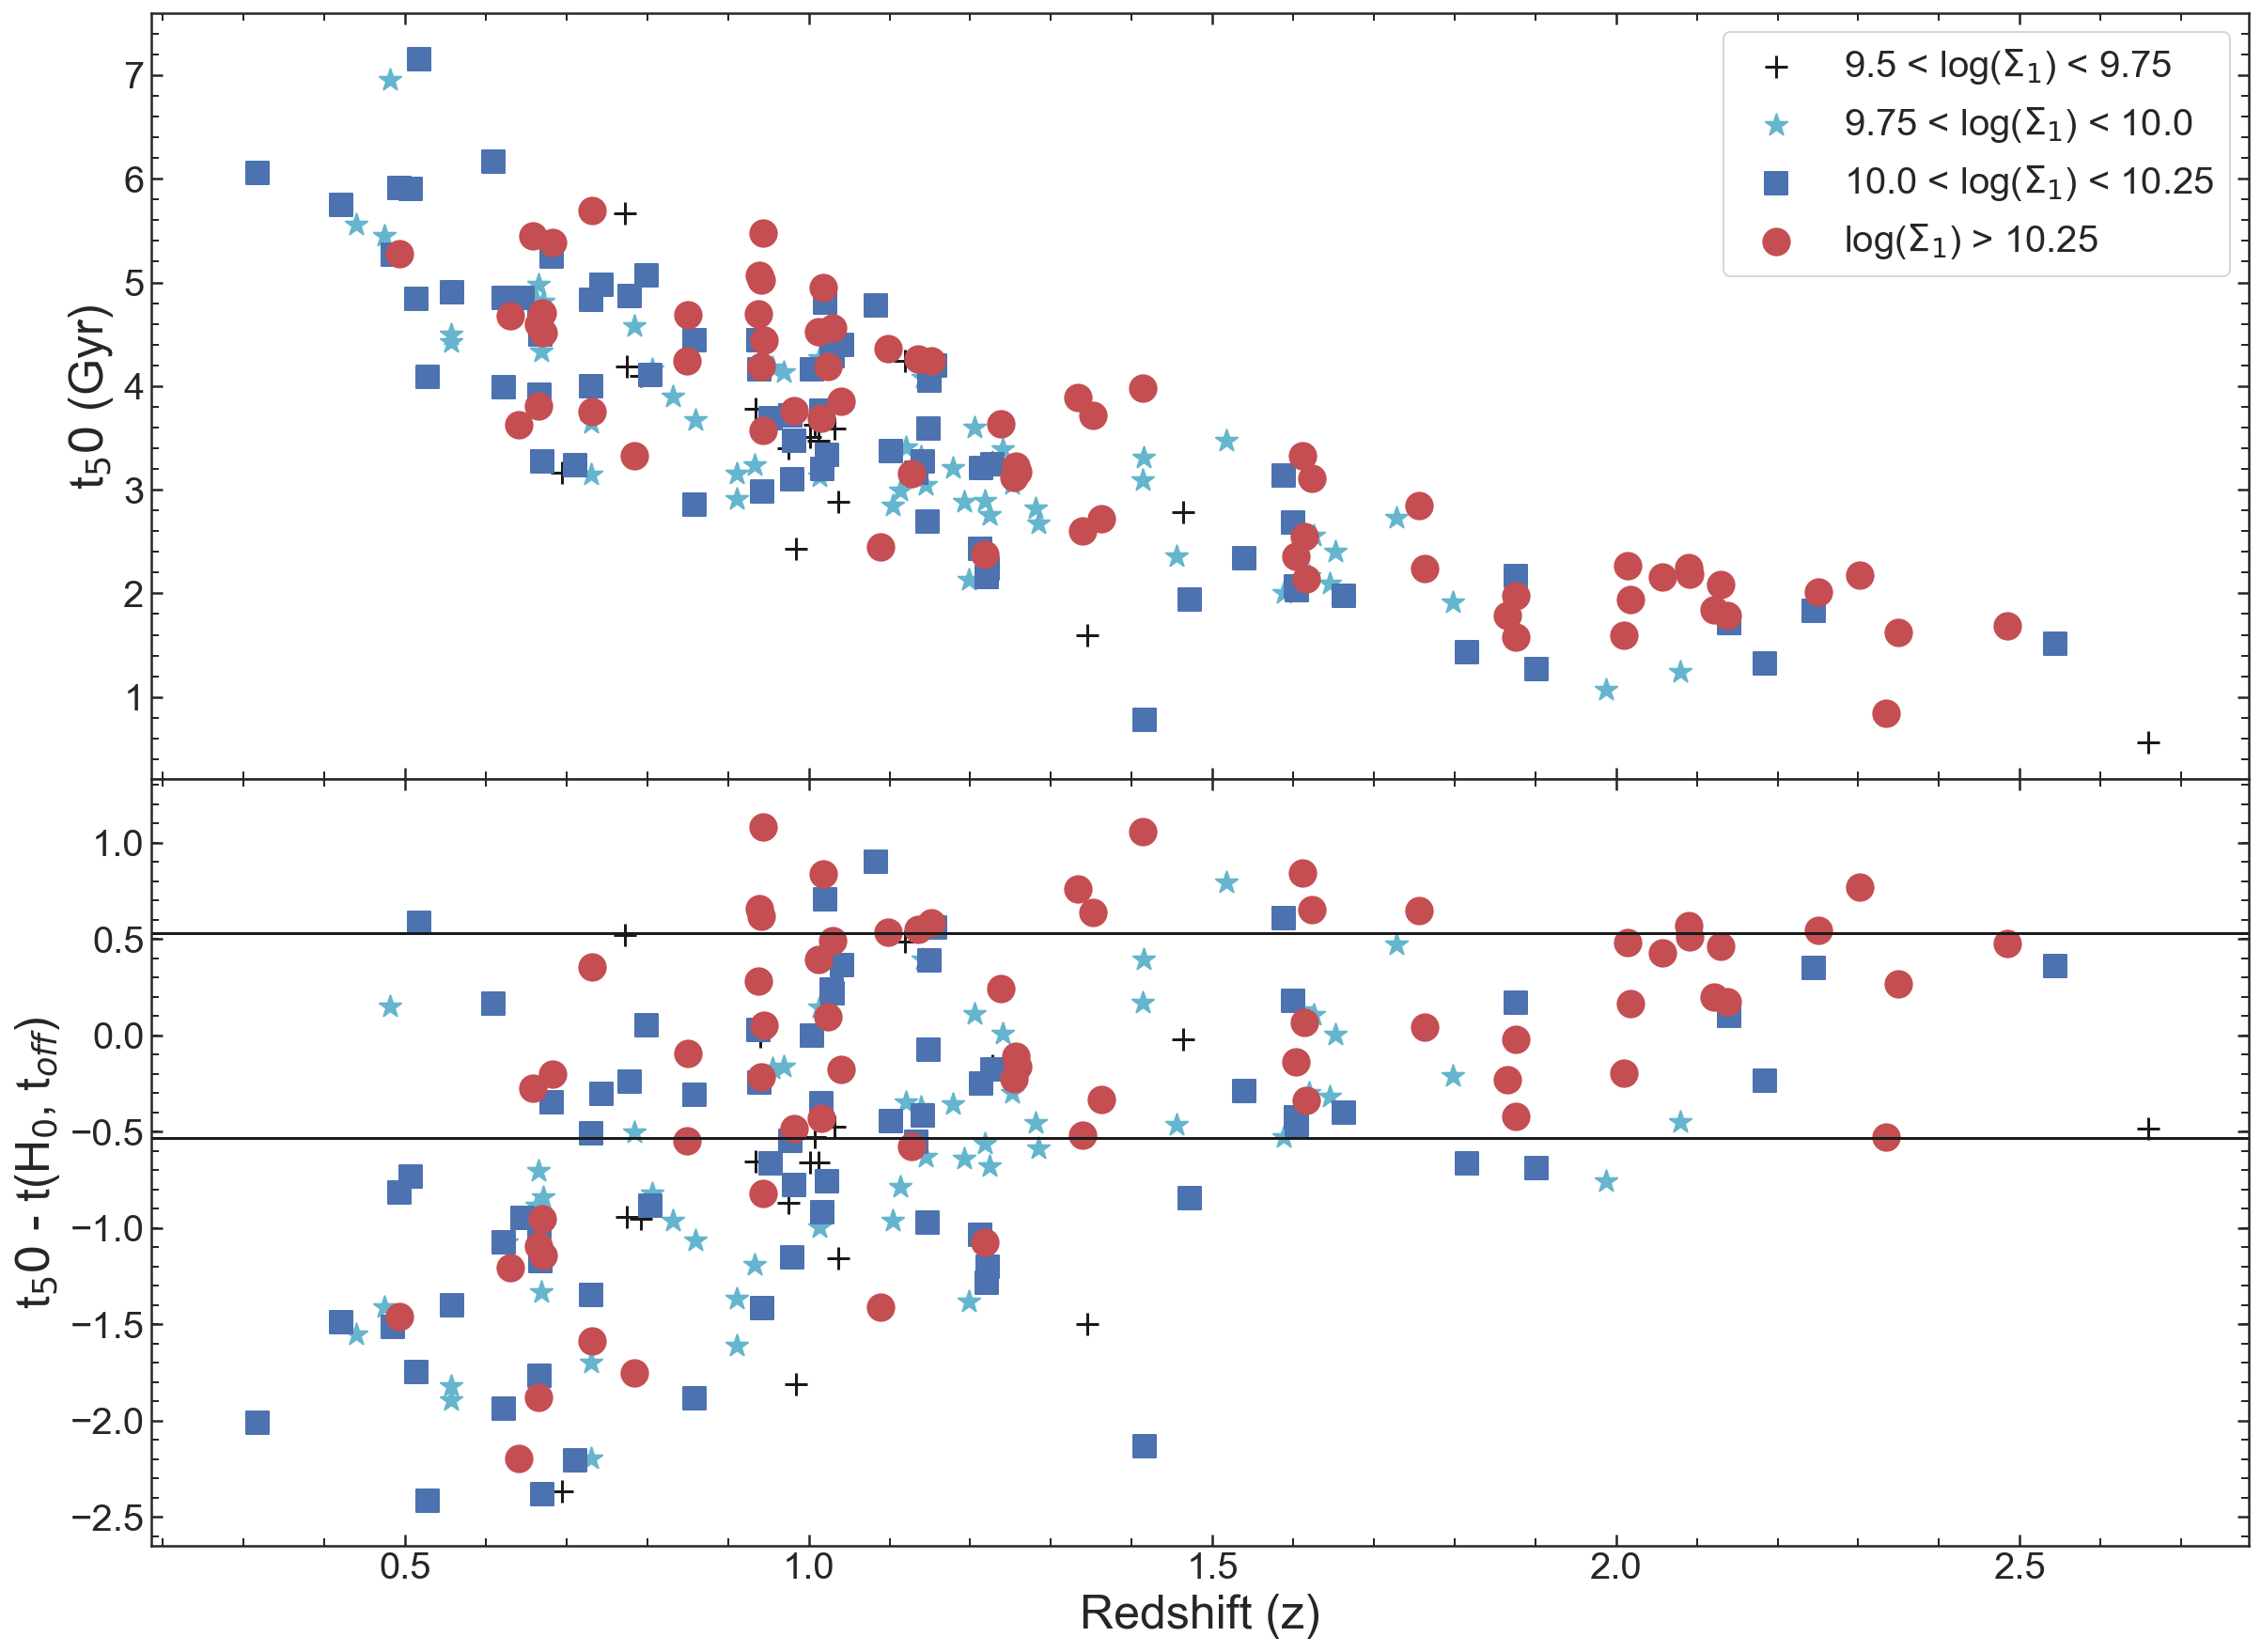

In [877]:
c1db = Adb.query('lmass > 11 and sf_prob_2 < 0.2').sort_values('zgrism')
c2db = Adb.query('10.6 < lmass < 11 and sf_prob_2 < 0.2').sort_values('zgrism')
c3db = Adb.query('10.3 < lmass < 10.6 and sf_prob_2 < 0.2').sort_values('zgrism')
c4db = Adb.query('10.0 < lmass < 10.3 and sf_prob_2 < 0.2').sort_values('zgrism')

gs = gridspec.GridSpec(2,1, hspace=0)

plt.figure(figsize=[20,15])
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

ax1.scatter(c4db.zgrism, c4db.t_50, color = 'k', marker = '+', s=150, label = '9.5 < log($\Sigma_1$) < 9.75')
ax1.scatter(c3db.zgrism, c3db.t_50, color = 'c', marker = '*', s=150, label = '9.75 < log($\Sigma_1$) < 10.0')
ax1.scatter(c2db.zgrism, c2db.t_50, color = 'b', marker = 's', s=150, label = '10.0 < log($\Sigma_1$) < 10.25')
ax1.scatter(c1db.zgrism, c1db.t_50, color = 'r', marker = 'o', s=200, label = 'log($\Sigma_1$) > 10.25 ')
ax1.legend(fontsize = 20)

cosmo = FlatLambdaCDM(H0=74.62, Om0=0.3)
H_age = cosmo.age(rshifts).value

ax2.scatter(c4db.zgrism, c4db.t_50 - (cosmo.age(c4db.zgrism).value - 1.22), color = 'k', marker = '+', s=150)
ax2.scatter(c3db.zgrism, c3db.t_50 - (cosmo.age(c3db.zgrism).value - 1.22), color = 'c', marker = '*', s=150)
ax2.scatter(c2db.zgrism, c2db.t_50 - (cosmo.age(c2db.zgrism).value - 1.22), color = 'b', marker = 's', s=150)
ax2.scatter(c1db.zgrism, c1db.t_50 - (cosmo.age(c1db.zgrism).value - 1.22), color = 'r', marker = 'o', s=200)
ax2.axhline(-np.sqrt(np.exp(-1.26)), color = 'k')
ax2.axhline(np.sqrt(np.exp(-1.26)), color = 'k')

ax1.tick_params(axis='both', which='major', labelsize=20)
ax2.tick_params(axis='both', which='major', labelsize=20)

ax2.set_xlabel('Redshift (z)', fontsize=25)
ax1.set_ylabel('t$_50$ (Gyr)', fontsize=25)
ax2.set_ylabel('t$_50$ - t(H$_0$, t$_{off}$)', fontsize=25)


In [878]:
c1db = Adb.query('log_Sigma1 > 10.25 and sf_prob_2 < 0.2').sort_values('zgrism')
c2db = Adb.query('10 < log_Sigma1 < 10.25 and sf_prob_2 < 0.2').sort_values('zgrism')
c3db = Adb.query('9.75 < log_Sigma1 < 10. and sf_prob_2 < 0.2').sort_values('zgrism')
c4db = Adb.query('9.5 < log_Sigma1 < 9.75 and sf_prob_2 < 0.2').sort_values('zgrism')

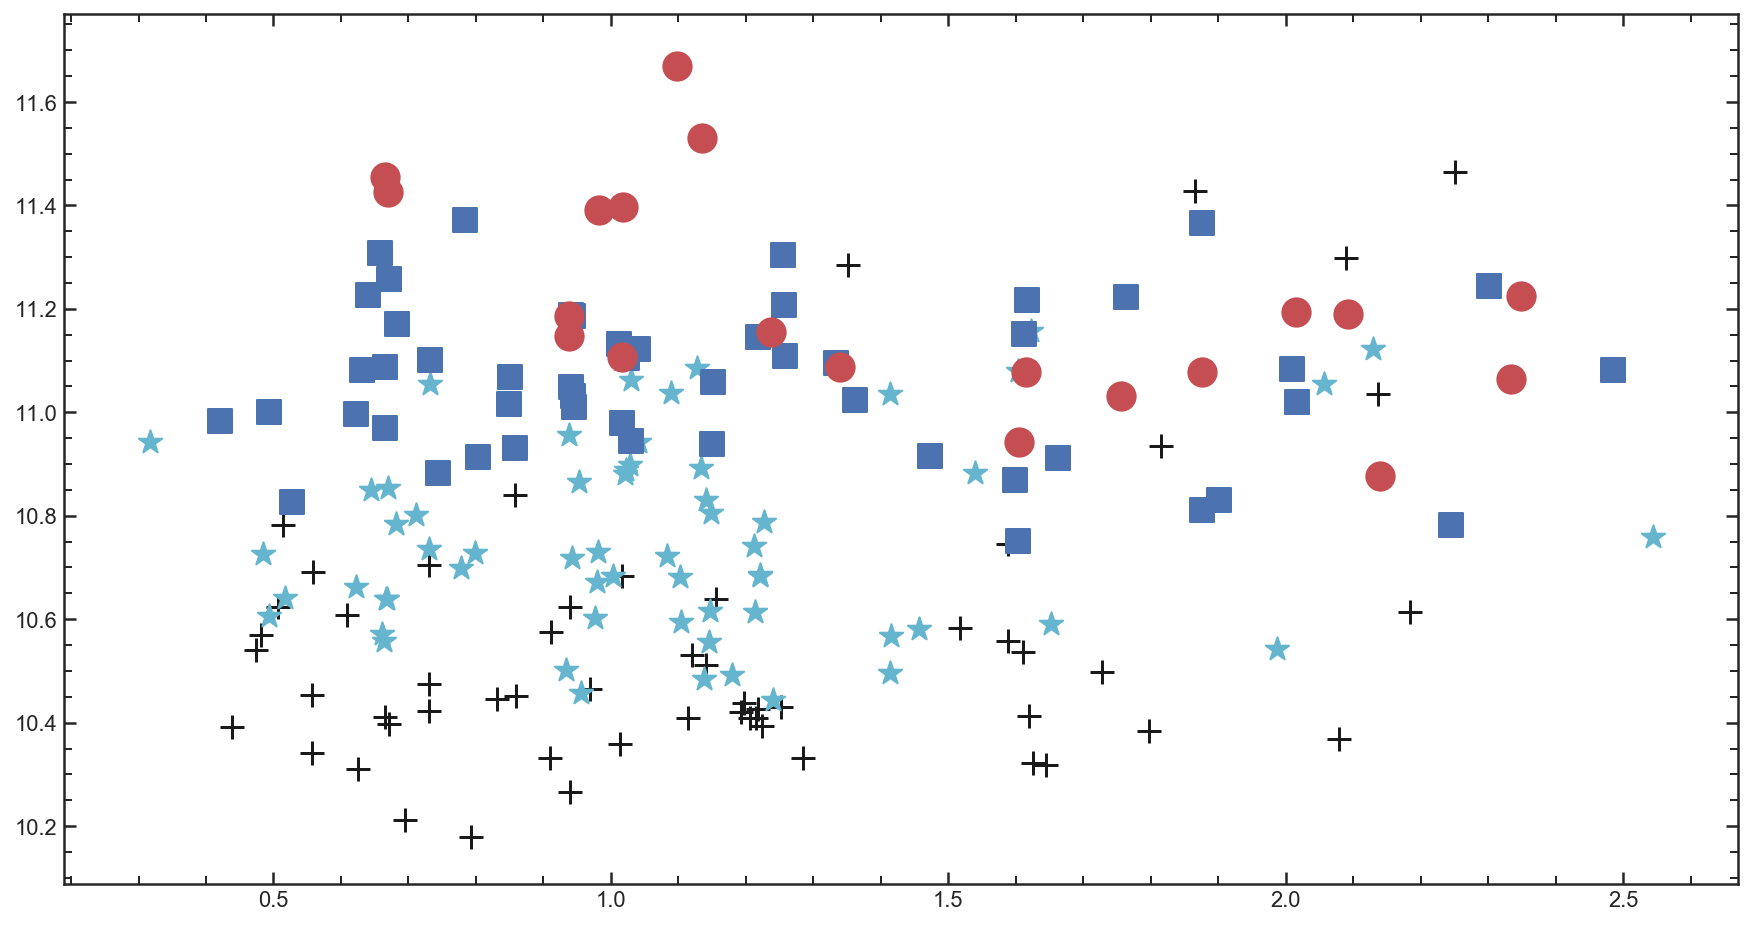

In [881]:
plt.figure(figsize=[15,8])
ax1 = plt.subplot()

ax1.scatter(c4db.zgrism, c4db.lmass, color = 'k', marker = '+', s=150, label = '9.5 < log($\Sigma_1$) < 9.75')
ax1.scatter(c3db.zgrism, c3db.lmass, color = 'c', marker = '*', s=150, label = '9.75 < log($\Sigma_1$) < 10.0')
ax1.scatter(c2db.zgrism, c2db.lmass, color = 'b', marker = 's', s=150, label = '10.0 < log($\Sigma_1$) < 10.25')
ax1.scatter(c1db.zgrism, c1db.lmass, color = 'r', marker = 'o', s=200, label = 'log($\Sigma_1$) > 10.25 ')

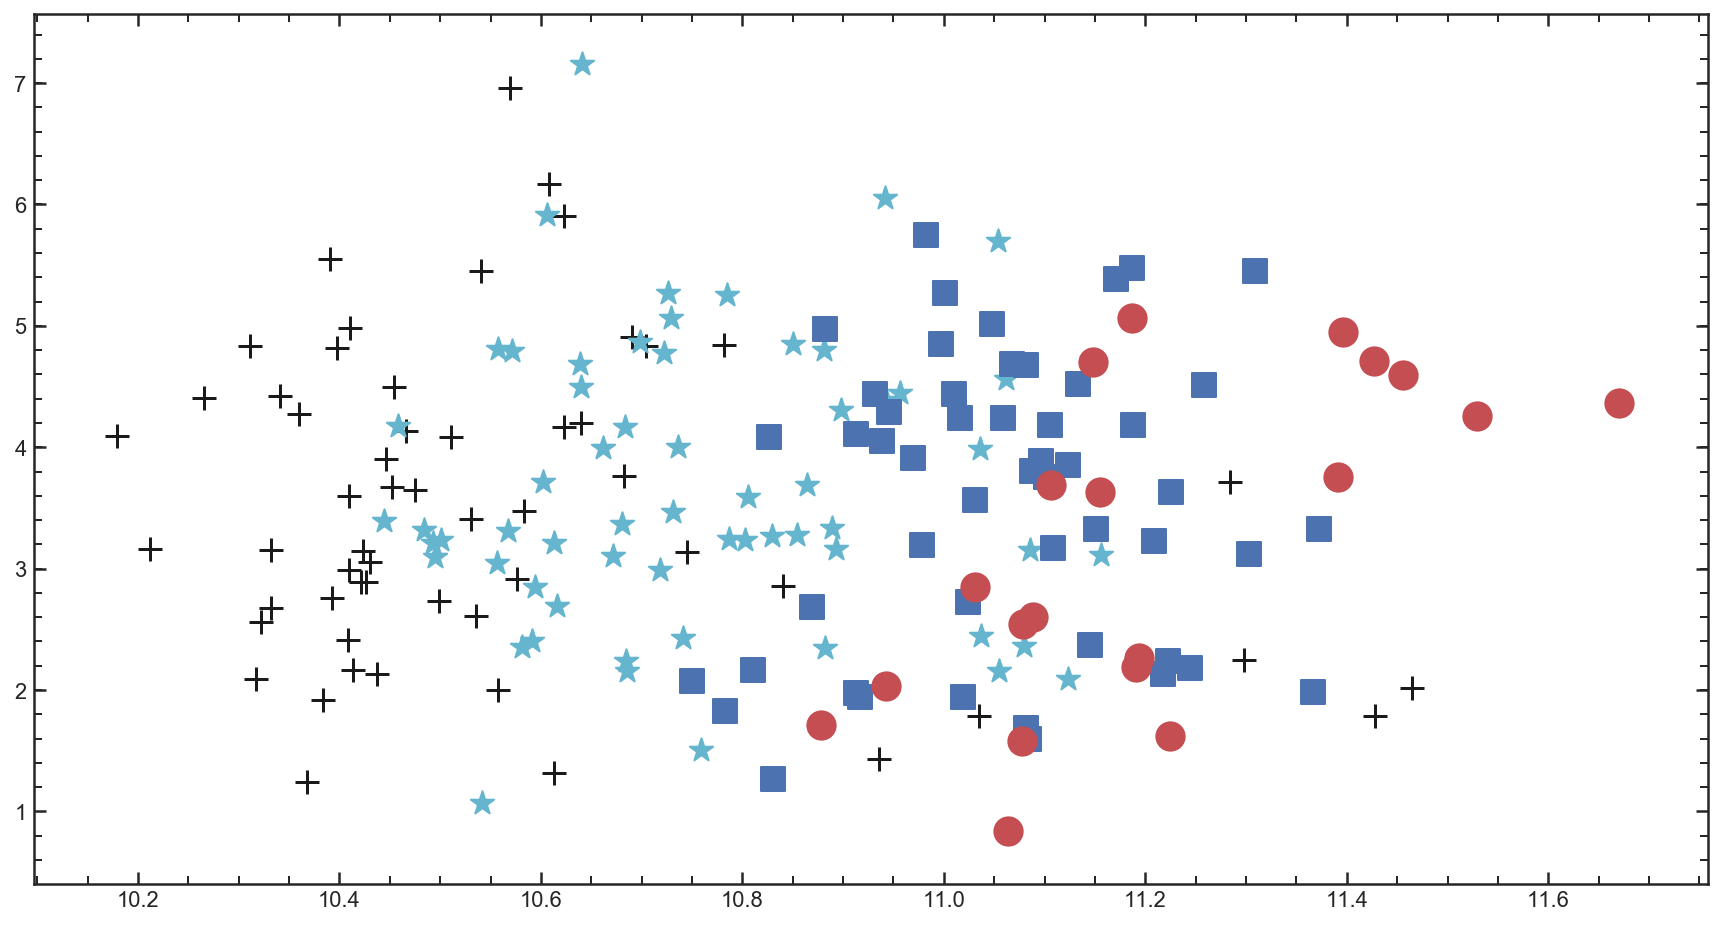

In [883]:
plt.figure(figsize=[15,8])
ax1 = plt.subplot()

ax1.scatter(c4db.lmass, c4db.t_50, color = 'k', marker = '+', s=150, label = '9.5 < log($\Sigma_1$) < 9.75')
ax1.scatter(c3db.lmass, c3db.t_50, color = 'c', marker = '*', s=150, label = '9.75 < log($\Sigma_1$) < 10.0')
ax1.scatter(c2db.lmass, c2db.t_50, color = 'b', marker = 's', s=150, label = '10.0 < log($\Sigma_1$) < 10.25')
ax1.scatter(c1db.lmass, c1db.t_50, color = 'r', marker = 'o', s=200, label = 'log($\Sigma_1$) > 10.25 ')

In [7]:
cosmo = FlatLambdaCDM(H0=74.62, Om0=0.3)
sim_curve = cosmo.age(np.linspace(0.3,3,1000)).value - 1.22

In [72]:
ndx = [0.6, 0.61796432, 0.71674852, 0.81553271, 0.91431691, 1.01310111, 1.1118853,
 1.2106695,  1.30945369, 1.40823789, 1.50702209, 1.60580628, 1.70459048,
 1.80337468, 1.90215887, 2.00094307, 2.09972727, 2.19851146, 2.29729566,
 2.39607986,2.5] 
ndy = [21.73290068,21.73290068, 20.02264362, 18.36194567, 16.76407205, 15.2553624,  14.05997006,
 13.43233581, 12.692396,   11.95048395, 10.98004395, 10.13452753,  9.36988171,
  9.04101404,  9.24397231,  9.46474917,  9.71777641, 10.01323645, 10.37144486,
 10.81226734, 10.81226734]

isnr = interp1d(ndx, ndy)

def sim_pop(num_sim_gals, H0, toff, V, zrange):
    z = np.linspace(0.3,3,1000)
    cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
    limcurve = cosmo.age(z).value

    cosmo = FlatLambdaCDM(H0=H0, Om0=0.3)
    curve = cosmo.age(z).value - toff

    zdist = np.random.rand(num_sim_gals)*(zrange[1] - zrange[0]) + zrange[0]
    icurve = interp1d(z, curve)(zdist)
    ilimcurve = interp1d(z, limcurve)(zdist)

    Voffset = []

    while len(Voffset) < num_sim_gals:
        initoff = np.random.normal(loc = 0, scale= np.sqrt(V))
        if 0 < icurve[len(Voffset)] + initoff < ilimcurve[len(Voffset)]:
            Voffset.append(initoff)
        else:
            pass
      
    initsnr = []
    print('at snr')
    while len(initsnr) < num_sim_gals:
        initerr = np.random.normal(isnr(zdist[len(initsnr)]), 5.5)
        if initerr > 5:
            initsnr.append(initerr)
        else:
            pass
    rerr = (icurve + Voffset)/np.array(initsnr)
    Soffset = []

    while len(Soffset) < num_sim_gals:
        initoff = np.random.normal(loc = 0, scale= rerr[len(Soffset)])
        if 0 < icurve[len(Soffset)] + Voffset[len(Soffset)] + initoff < ilimcurve[len(Soffset)]:
            Soffset.append(initoff)
        else:
            pass
    
    return zdist, icurve + np.array(Voffset) + np.array(Soffset), rerr

at snr


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


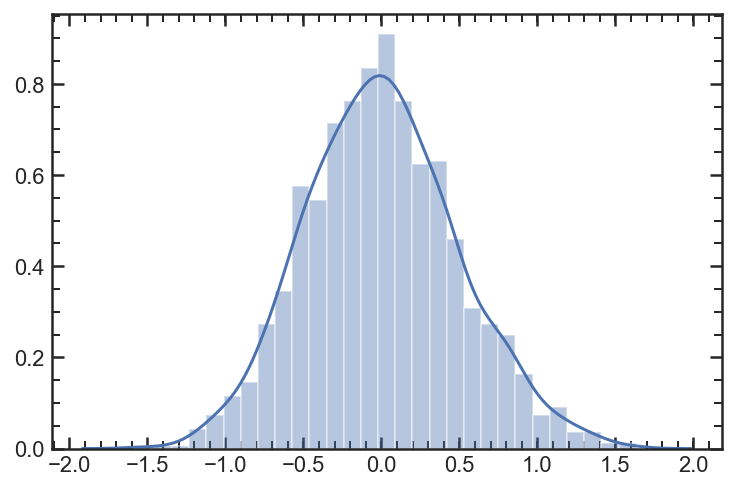

In [74]:
sim_z, sim_t50, sim_err= sim_pop(1500, 74.62, 1.22, 0.44**2,[0.6,2.5])
cosmo = FlatLambdaCDM(H0=74.62, Om0=0.3)
sim_curve = cosmo.age(np.linspace(0.3,3,1000)).value - 1.22

plt.figure()
sea.distplot(sim_t50 - (cosmo.age(sim_z).value - 1.22))
# sea.distplot(t50s - (cosmo.age(rshifts).value - 1.22))


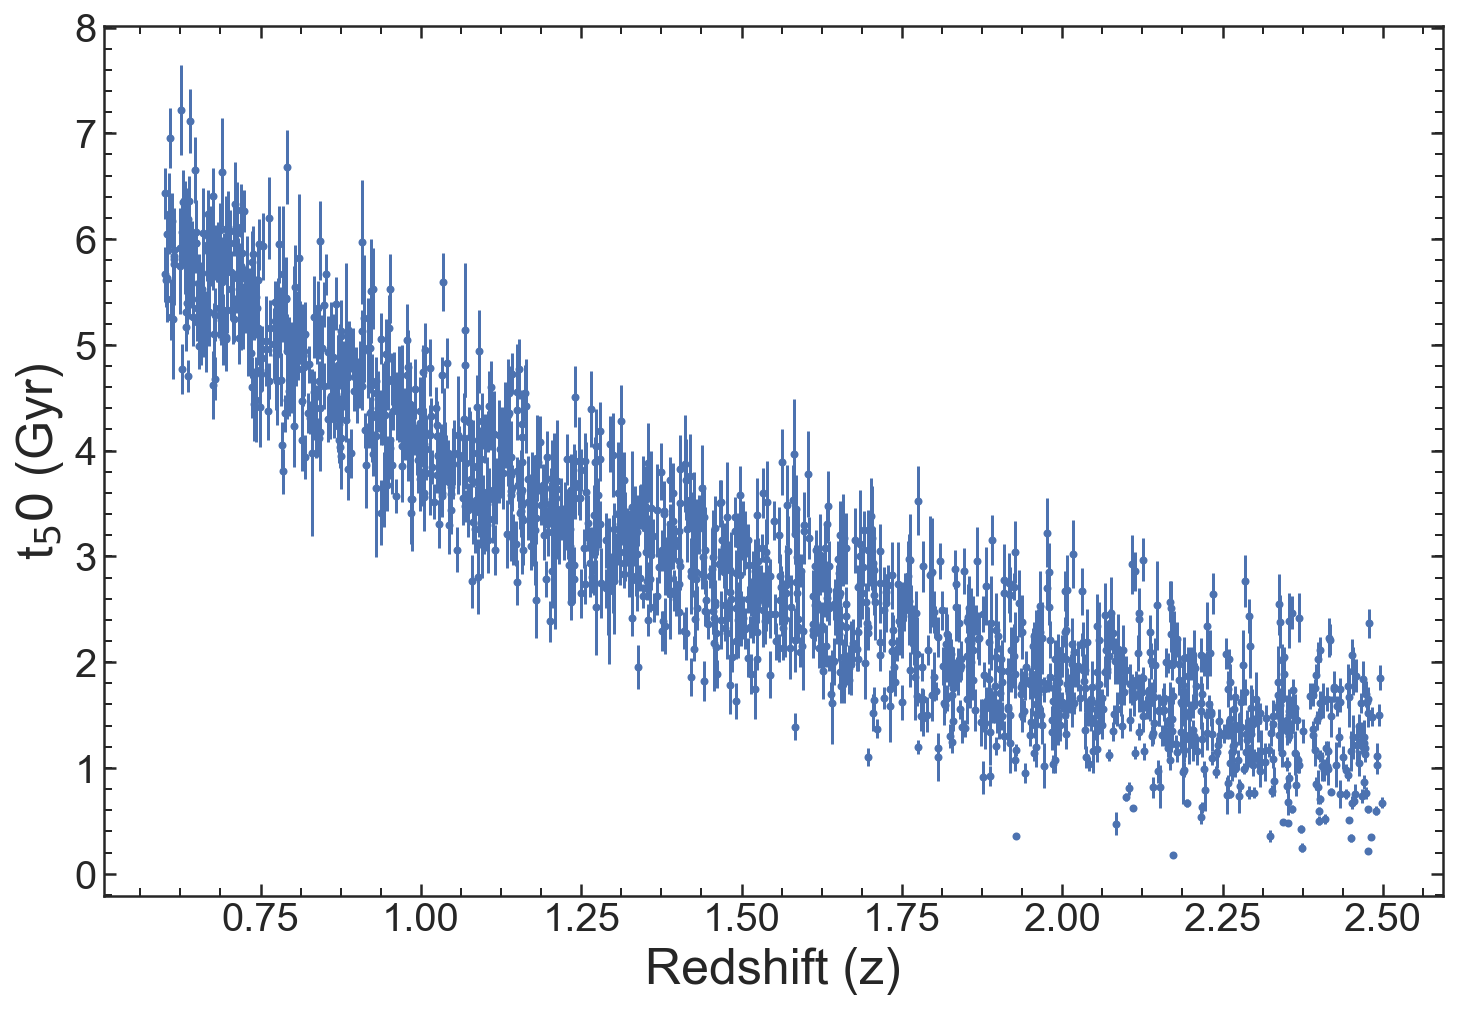

In [80]:
plt.figure(figsize = [12,8])
plt.errorbar(sim_z, sim_t50, sim_err, linestyle = 'none', marker = 'o', ms=3)

plt.xlabel('Redshift (z)', fontsize=25)
plt.ylabel('t$_50$ (Gyr)', fontsize=25)
plt.tick_params(axis='both', which='major', labelsize=20)
# plt.savefig('../plots/research_update/H0_measurements.png', bbox_inches = 'tight')    

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:93: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:105: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



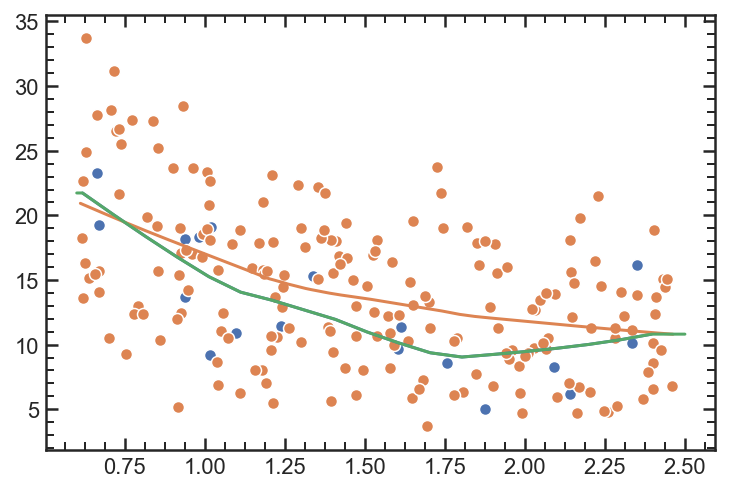

In [146]:
six, siy = LOWESS_trend(sim_z, sim_t50/ sim_err, alpha = 0.6666)

dx, dy = LOWESS_trend(rshifts[t50s/serr < 30], (t50s/serr)[t50s/serr < 30], alpha =0.6666)

sea.scatterplot(rshifts[t50s/serr < 30], (t50s/serr)[t50s/serr < 30],)
plt.plot(dx,dy)
sea.scatterplot(sim_z, sim_t50/ sim_err)
plt.plot(six,siy)
plt.plot(ndx,ndy)


In [133]:
print(dx, dy)

ndx = [0.6, 0.61796432, 0.71674852, 0.81553271, 0.91431691, 1.01310111, 1.1118853,
 1.2106695,  1.30945369, 1.40823789, 1.50702209, 1.60580628, 1.70459048,
 1.80337468, 1.90215887, 2.00094307, 2.09972727, 2.19851146, 2.29729566,
 2.39607986,2.5] 
ndy = [21.73290068,21.73290068, 20.02264362, 18.36194567, 16.76407205, 15.2553624,  14.05997006,
 13.43233581, 12.692396,   11.95048395, 10.98004395, 10.13452753,  9.36988171,
  9.04101404,  9.24397231,  9.46474917,  9.71777641, 10.01323645, 10.37144486,
 10.81226734, 10.81226734]

[0.61796432 0.71674852 0.81553271 0.91431691 1.01310111 1.1118853
 1.2106695  1.30945369 1.40823789 1.50702209 1.60580628 1.70459048
 1.80337468 1.90215887 2.00094307 2.09972727 2.19851146 2.29729566
 2.39607986] [21.73290068 20.02264362 18.36194567 16.76407205 15.2553624  14.05997006
 13.43233581 12.692396   11.95048395 10.98004395 10.13452753  9.36988171
  9.04101404  9.24397231  9.46474917  9.71777641 10.01323645 10.37144486
 10.81226734]


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


5.039538217278922
12.564179840570304
3.9484100855654507
6.679905384471056


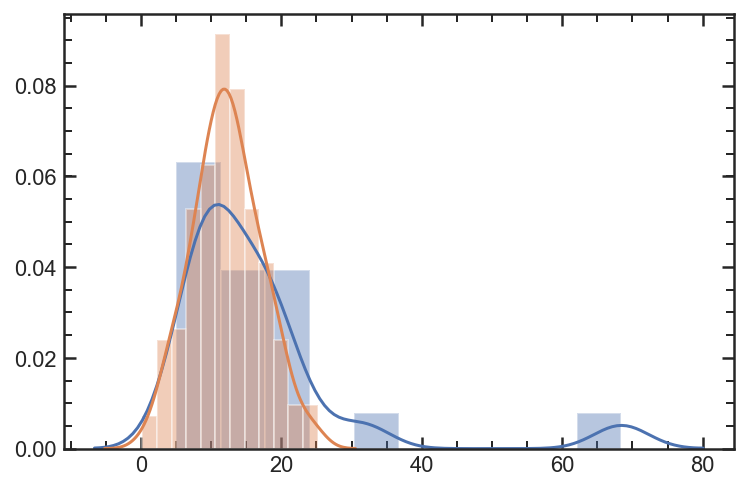

In [92]:
sea.distplot(t50s/serr)
sea.distplot(sim_t50/ sim_err)
# sea.distplot(np.random.normal(0.08, 0.0315, 1000))
print(min(t50s/serr))

print(np.percentile(t50s/serr, 50))
print(np.percentile(t50s/serr, 50) - np.percentile(t50s/serr, 16))
print(np.percentile(t50s/serr, 84) - np.percentile(t50s/serr, 50))

In [929]:
sim_z, sim_t50, sim_err = sim_pop(100, 74.62, 1.22, 0.44**2, serr, [0.5,2.5])

def sim_ln_likelihood(pars):
    """ The likelihood function evaluation requires a particular set of model parameters and the data """
    H, toff, Va, lnVb = pars
    
    cosmo = FlatLambdaCDM(H0=H, Om0=0.3)
    V = -Va * sim_z + np.exp(lnVb)
    V[V<0] = 0

    N = len(sim_t50)
    dy = sim_t50 - (cosmo.age(sim_z).value - toff)
    ivar = 1 / (sim_err**2 + V) # inverse-variance now includes intrinsic scatter
    
    return -0.5 * (N*np.log(2*np.pi) - np.sum(np.log(ivar)) + np.sum(dy**2 * ivar))

def sim_prior(u):
    H = Gaussian_prior(u[0], [50, 90], 70, 5)
    toff = 3*u[1]
    Va = Gaussian_prior(u[2], [-0.5, 0.5], 0, 0.25)
    lnVb = Gaussian_prior(u[3], [0, -3], -1.5, 0.5)
    
    return H, toff, Va, lnVb

In [930]:
sampler = dynesty.DynamicNestedSampler(sim_ln_likelihood, sim_prior, ndim = 4, bound = 'multi')

In [931]:
sampler.run_nested(wt_kwargs={'pfrac': 1.0}, dlogz_init=0.01, print_progress=True)

20267it [30:58, 10.72it/s, batch: 10 | bound: 93 | nc: 2 | ncall: 90775 | eff(%): 22.327 | loglstar: -101.814 < -95.932 < -96.477 | logz: -101.958 +/-  0.127 | stop:  0.960]


(<Figure size 698.4x698.4 with 16 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1af16b3c88>,
       dtype=object))

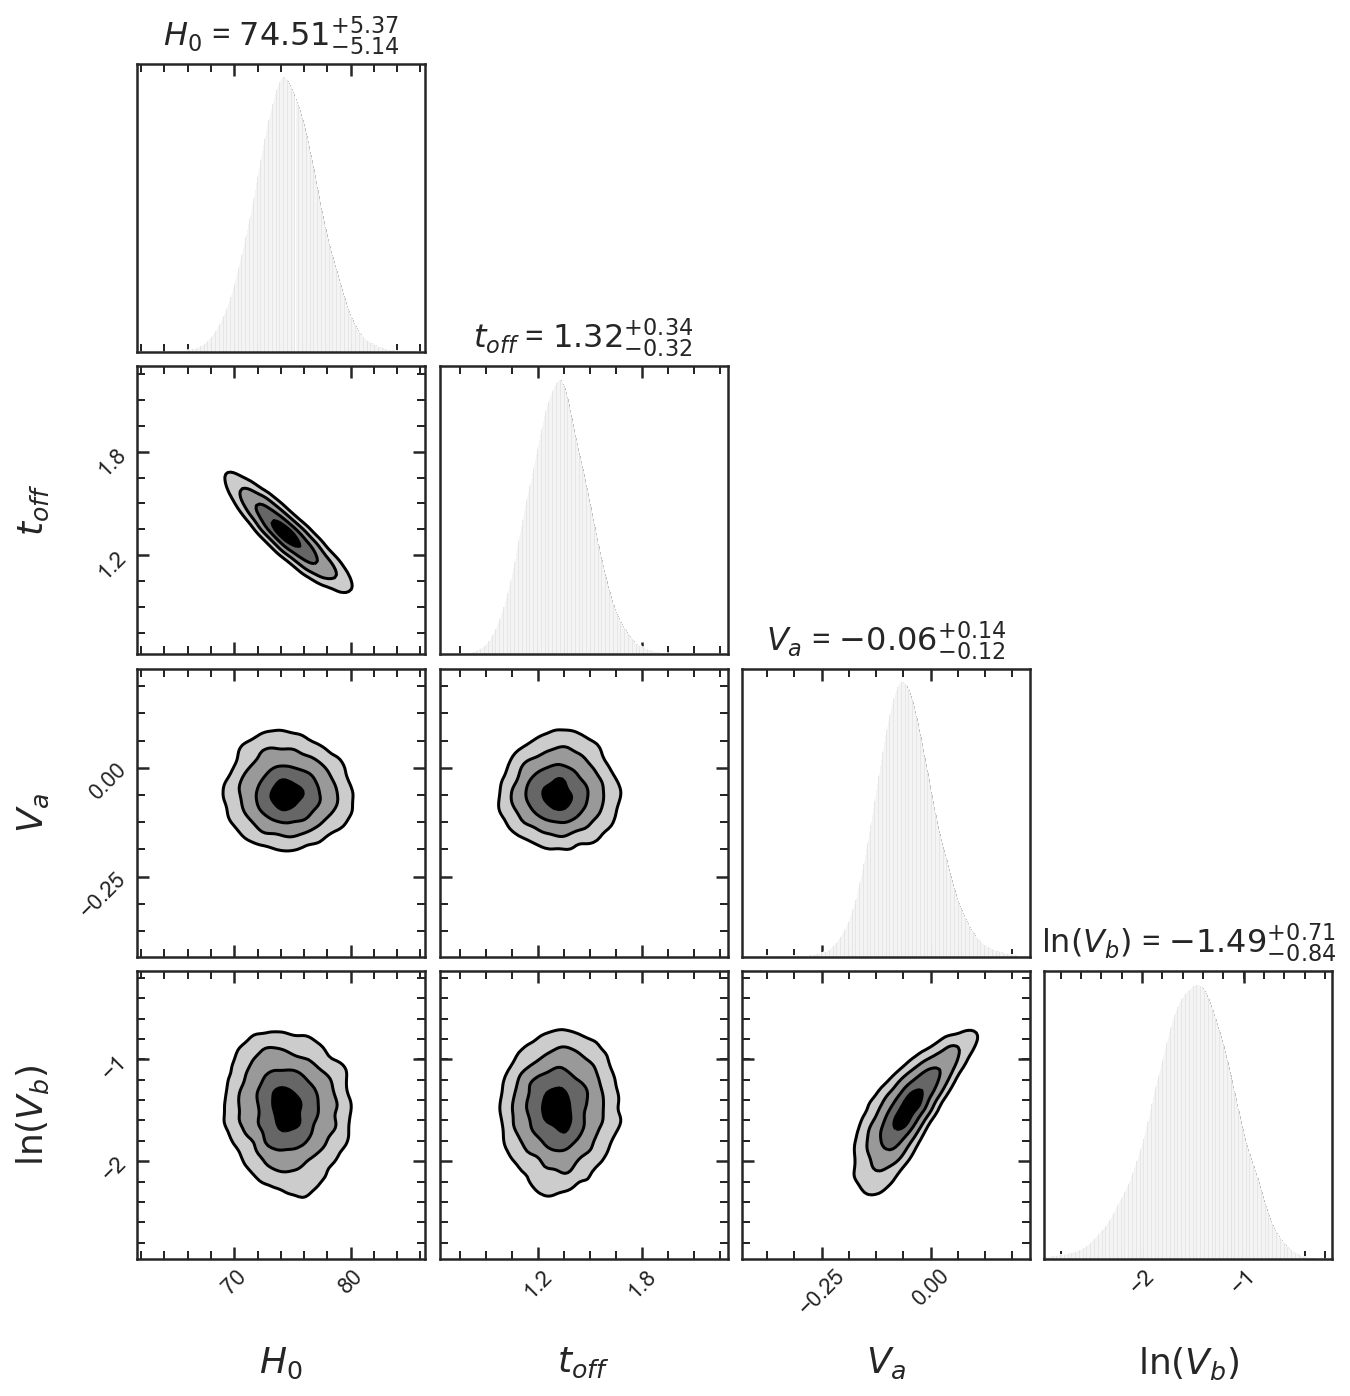

In [934]:
dres = sampler.results

labels = [r'$H_0$', r'$t_{off}$', r'$V_a$', r'$\ln(V_b)$']

dyplot.cornerplot(dres,show_titles=True, max_n_ticks=3, title_kwargs={'y': 1.02,'fontsize':16},
                           quantiles=[], labels = labels, label_kwargs = {'fontsize':18})

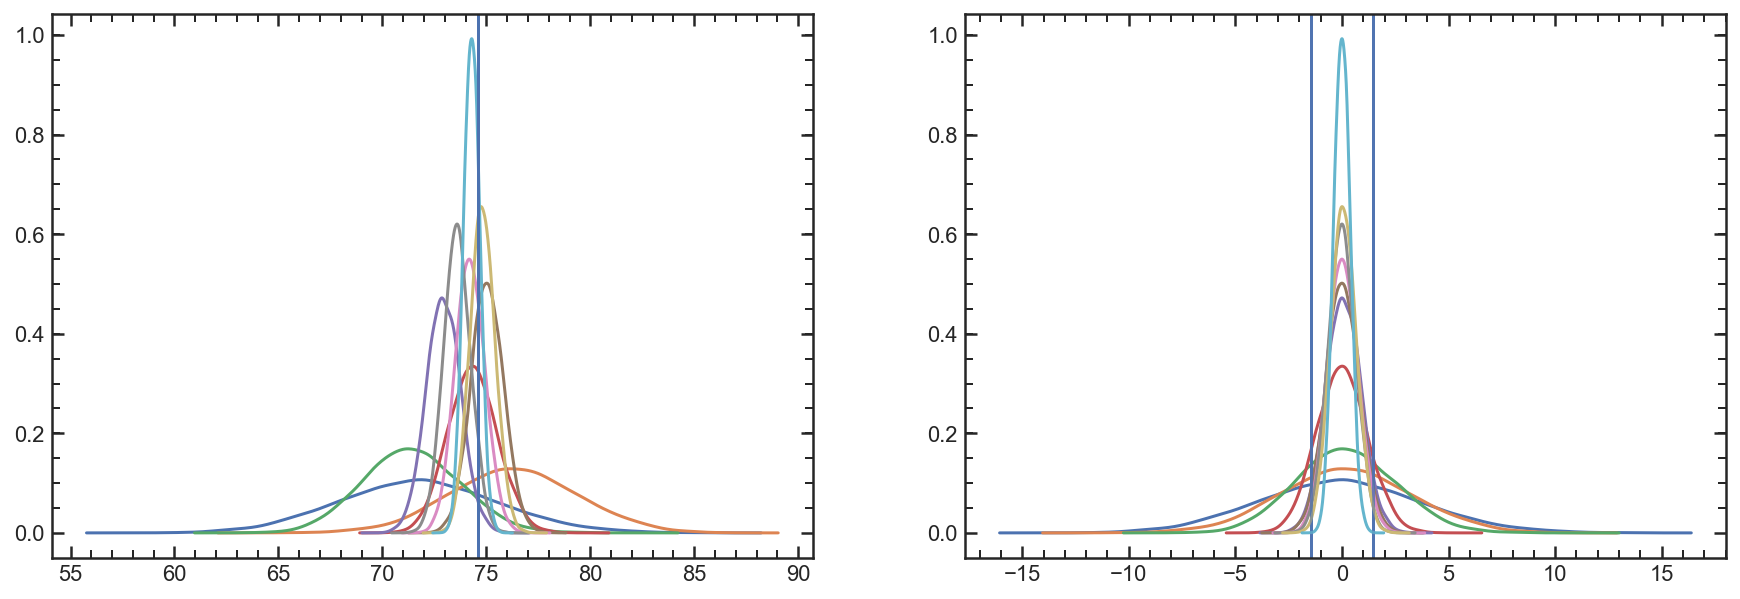

In [164]:
s_nums = [20,50,100,500,1000,1250,1500,1750,2000,5000]

gs = gridspec.GridSpec(1,2)

plt.figure(figsize=[15,5])
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

for s in s_nums:
    dres = np.load('../chidat/sim_H0_n{}.npy'.format(s), allow_pickle = True).item()
    x, Px = Get_posterior(dres, 0)
    med, hdr, mod = Highest_density_region(Px,x)
    ax1.plot(x, Px)
    ax2.plot(x - med, Px)
    ax1.axvline(74.62)
    ax2.axvline(1.44, alpha = 0.3)
    ax2.axvline(-1.44, alpha = 0.3)
    
#     break

In [82]:
(20 / 12) * 100 * 9

1500.0000000000002

In [86]:
(114 / 12) * 100 * 2

1900.0